In [2]:
import pandas as pd
import numpy as np
import os
import math
import re
import matplotlib.pyplot as plt
import usaddress
import pickle

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, SGDRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import optuna
from optuna.samplers import TPESampler
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
# Added to work with google colab instance.
#from google.colab import drive
#drive.mount('/content/gdrive')
#data = pd.read_excel('/content/gdrive/MyDrive/data/raw/nyc_benchmarking_disclosure_2017_consumption_data.xlsx', sheet_name='Information and Metrics')

Mounted at /content/gdrive


In [5]:
# reading the corresponding sheet from a data excel
#data = pd.read_excel('../data/raw/nyc_benchmarking_disclosure_2017_consumption_data.xlsx', sheet_name='Information and Metrics')

# EAD

In [6]:
print(f'The original raw dataset has {len(data)} rows.')

The original raw dataset has 34355 rows.


In [7]:
# uniforming names of the columns
data_columns =[col.lower().replace(' ', '_').replace('²', '') for col in data.columns]
data.columns = data_columns

### Filtering and basic preprocessing

In [8]:
# Basic information about types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34355 entries, 0 to 34354
Data columns (total 60 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   order                                                      34355 non-null  int64         
 1   property_id                                                34355 non-null  int64         
 2   property_name                                              34355 non-null  object        
 3   parent_property_id                                         1723 non-null   object        
 4   parent_property_name                                       1723 non-null   object        
 5   bbl_-_10_digits                                            33625 non-null  float64       
 6   nyc_borough,_block_and_lot_(bbl)_self-reported             33626 non-null  object        
 7   nyc_building_identification_num

In [9]:
# drop colums if they contain more than 70% NAs and rows with NA target variable
data_cleaned = data.dropna(thresh=int(0.7*len(data)),axis=1)
data_cleaned.dropna(subset=['energy_star_score'], inplace=True)

In [10]:
print(f'After basic filtering we get {len(data_cleaned)} rows.')

After basic filtering we get 25454 rows.


In [11]:
# if a column has one value, we should drop it:
for col in data_cleaned.columns:
    if len(data_cleaned[col].unique())==1:
        print(f'One Value {col}-{data_cleaned[col].unique()}')

One Value street_number-['Not found']
One Value street_name-['Not found']
One Value dof_gross_floor_area_(ft)-['Not found']
One Value water_required?-['Not found']
One Value dof_benchmarking_submission_status-['Not found']


In [12]:
# Columns 'bbl_-_10_digits', 'nyc_borough,_block_and_lot_(bbl)_self-reported are almost the same, right?
def bbl(x):
    if type(x) == int:
        return x
    elif type(x) == float and math.isnan(x):
        return x
    else:
        return int(re.sub(r"\D","", x))

data_cleaned[data_cleaned['bbl_-_10_digits']!=data_cleaned['nyc_borough,_block_and_lot_(bbl)_self-reported'].apply(bbl)]

,order,property_id,property_name,bbl_-_10_digits,"nyc_borough,_block_and_lot_(bbl)_self-reported",nyc_building_identification_number_(bin),address_1_(self-reported),postal_code,street_number,street_name,...,weather_normalized_site_natural_gas_use_(therms),electricity_use_-_grid_purchase_(kbtu),electricity_use_-_grid_purchase_(kwh),weather_normalized_site_electricity_(kwh),total_ghg_emissions_(metric_tons_co2e),direct_ghg_emissions_(metric_tons_co2e),indirect_ghg_emissions_(metric_tons_co2e),water_required?,generation_date,dof_benchmarking_submission_status
39,42,6143730,Jay Cee of New York Corp.,NaN,NaN,NaN,35 WEST 31ST STREET,10001,Not found,Not found,...,NaN,870169.5,255032.1,NaN,160.7,83.5,77.1,Not found,2018-02-20,Not found
40,43,6143720,New York Midtown Corp,NaN,NaN,NaN,222 West 37th Street,10018,Not found,Not found,...,NaN,NaN,NaN,NaN,185.7,77.8,NaN,Not found,2018-02-20,Not found
48,51,6182209,Staples,NaN,NaN,NaN,24-41 31st St,11102,Not found,Not found,...,1642.9,1051476.0,308170.0,305505.5,101.0,7.7,93.2,Not found,2018-02-21,Not found
163,168,6168561,South Bronx Charter School,2.025460e+09,25460027,NaN,164 Bruckner Blvd,10454,Not found,Not found,...,77814.1,2422656.4,710039.9,724986.0,580.3,365.5,214.8,Not found,2018-03-09,Not found
165,170,6153751,8201 Associates,NaN,NaN,NaN,8201 Bay Parkway,11724,Not found,Not found,...,360.4,85664.2,25106.7,25969.8,15.5,1.8,13.7,Not found,2018-03-09,Not found
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34084,34416,6705801,360 Neptune,NaN,NaN,3424564,350 Neptune Ave,11235,Not found,Not found,...,NaN,1621291.2,475173.2,475173.2,137.3,0.0,137.3,Not found,2019-02-27,Not found
34333,34665,6700794,OAR FAILE LLC,2.027630e+09,2-002763-00215,2006551,770 Faile St.,10474,Not found,Not found,...,43260.2,909215.2,266475.7,264941.1,294.2,217.2,77.0,Not found,2019-02-27,Not found
34335,34667,6700864,1661 St johns LLc,3.014700e+09,3-001470-0080,3039446,1661 St johns Pl,11233,Not found,Not found,...,NaN,517823.8,151765.5,150904.6,43.9,0.0,43.9,Not found,2019-02-27,Not found
34336,34668,6700879,1677 St johns LLC,3.014700e+09,3-001470-0060,3039445,1677 St Johns Pl,11233,Not found,Not found,...,NaN,406278.4,119073.4,118636.7,34.4,0.0,34.4,Not found,2019-02-27,Not found


### Dropping non useful columns

* Dropping <code> property_id, order, property_name </code> since they are not informative for prediction
* Dropping <code>dof_gross_floor_area_(ft),  water_required?, dof_benchmarking_submission_status </code>, since they only
 contain one value.
* <code>street_number</code> and <code>stret_name</code> will be filled up later
* <code>nyc_borough,_block_and_lot_(bbl)_self-reported</code> will be skipped since it repeats <code>bbl_-_10_digits</code>, the last will delete as well since it is an id.
* <code>nyc_building_identification_number_(bin)</code> will be deleted as it is and identifier.
* <code>generation_date</code> will be removed since it does not bring any information.
* <code>electricity_use_-_grid_purchase_(kbtu)</code> will be removed since it is the same value in another units as <code>electricity_use_-_grid_purchase_(kwh)</code>:
  <code>data_cleaned['electricity_use_-_grid_purchase_(kbtu)']*0.2930710702 = data_cleaned['electricity_use_-_grid_purchase_(kwh)'] </code>


In [13]:
columns_to_drop = ['order',
                   'property_id',
                   'property_name',
                   'dof_gross_floor_area_(ft)',
                   'dof_benchmarking_submission_status',
                   'water_required?',
                   'nyc_borough,_block_and_lot_(bbl)_self-reported',
                   'bbl_-_10_digits',
                   'nyc_building_identification_number_(bin)',
                   'generation_date',
                   'street_name',
                   'street_number',
                  'electricity_use_-_grid_purchase_(kbtu)']
data_cleaned.drop(columns=columns_to_drop, inplace=True)

In [14]:
data_cleaned = data_cleaned[data_cleaned['indirect_ghg_emissions_(metric_tons_co2e)']>0]

In [15]:
print(f'We have removed {set(data.columns)-set(data_cleaned.columns)}')

We have removed {'property_name', 'property_id', 'fuel_oil_#2_use_(kbtu)', 'street_number', 'fuel_oil_#1_use_(kbtu)', 'order', 'dof_benchmarking_submission_status', 'generation_date', '2nd_largest_property_use_-_gross_floor_area_(ft)', 'water_use_(all_water_sources)_(kgal)', 'bbl_-_10_digits', 'propane_use_(kbtu)', 'district_hot_water_use_(kbtu)', 'fuel_oil_#4_use_(kbtu)', 'annual_maximum_demand_(mm/yyyy)', '2nd_largest_property_use_type', 'dof_gross_floor_area_(ft)', 'diesel_#2_use_(kbtu)', 'street_name', '3rd_largest_property_use_type', 'water_use_intensity_(all_water_sources)_(gal/ft)', 'nyc_borough,_block_and_lot_(bbl)_self-reported', 'address_2_(self-reported)', 'nyc_building_identification_number_(bin)', '3rd_largest_property_use_type_-_gross_floor_area_(ft)', 'annual_maximum_demand_(kw)', 'parent_property_id', 'metered_areas__(water)', 'water_required?', 'parent_property_name', 'district_steam_use_(kbtu)', 'fuel_oil_#5_&_6_use_(kbtu)', 'district_chilled_water_use_(kbtu)', 'elect

### Basic info about cleaned dataset

In [16]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24963 entries, 0 to 34353
Data columns (total 26 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   address_1_(self-reported)                                  24963 non-null  object 
 1   postal_code                                                24963 non-null  object 
 2   borough                                                    24963 non-null  object 
 3   self-reported_gross_floor_area_(ft)                        24963 non-null  int64  
 4   primary_property_type_-_self_selected                      24963 non-null  object 
 5   list_of_all_property_use_types_at_property                 24963 non-null  object 
 6   largest_property_use_type                                  24963 non-null  object 
 7   largest_property_use_type_-_gross_floor_area_(ft)          24963 non-null  float64
 8   year_b

## Separating columns into categorical and numerical

#### Numerical

In [17]:
from numpy import dtype
numerical_columns = []

for col in data_cleaned.columns:
    if data_cleaned[col].dtype == dtype('float64'):
        numerical_columns.append(col)

In [18]:
numerical_columns.extend(['occupancy', 'number_of_buildings', 'self-reported_gross_floor_area_(ft)'])
numerical_columns

['largest_property_use_type_-_gross_floor_area_(ft)',
 'energy_star_score',
 'source_eui_(kbtu/ft)',
 'weather_normalized_source_eui_(kbtu/ft)',
 'site_eui_(kbtu/ft)',
 'weather_normalized_site_eui_(kbtu/ft)',
 'weather_normalized_site_electricity_intensity_(kwh/ft)',
 'weather_normalized_site_natural_gas_intensity_(therms/ft)',
 'natural_gas_use_(kbtu)',
 'weather_normalized_site_natural_gas_use_(therms)',
 'electricity_use_-_grid_purchase_(kwh)',
 'weather_normalized_site_electricity_(kwh)',
 'total_ghg_emissions_(metric_tons_co2e)',
 'direct_ghg_emissions_(metric_tons_co2e)',
 'indirect_ghg_emissions_(metric_tons_co2e)',
 'occupancy',
 'number_of_buildings',
 'self-reported_gross_floor_area_(ft)']

In [19]:
#year_build is not informative, lets define an age.
data_cleaned['age'] = 2023 - data_cleaned['year_built']
data_cleaned.drop(columns=['year_built'], inplace=True)
numerical_columns.append('age')

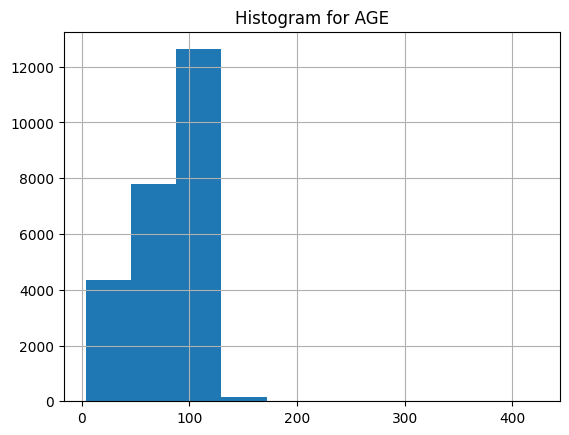

In [20]:
data_cleaned.age.hist()
plt.title('Histogram for AGE');

### Range of values, basic distribution statistics for numerical variables

In [21]:
data_cleaned[numerical_columns].describe()

,largest_property_use_type_-_gross_floor_area_(ft),energy_star_score,source_eui_(kbtu/ft),weather_normalized_source_eui_(kbtu/ft),site_eui_(kbtu/ft),weather_normalized_site_eui_(kbtu/ft),weather_normalized_site_electricity_intensity_(kwh/ft),weather_normalized_site_natural_gas_intensity_(therms/ft),natural_gas_use_(kbtu),weather_normalized_site_natural_gas_use_(therms),electricity_use_-_grid_purchase_(kwh),weather_normalized_site_electricity_(kwh),total_ghg_emissions_(metric_tons_co2e),direct_ghg_emissions_(metric_tons_co2e),indirect_ghg_emissions_(metric_tons_co2e),occupancy,number_of_buildings,self-reported_gross_floor_area_(ft),age
count,2.496300e+04,24963.000000,2.496300e+04,2.236800e+04,2.496300e+04,2.236800e+04,24552.000000,22199.000000,2.275000e+04,2.219900e+04,2.496200e+04,2.455200e+04,2.496300e+04,2.485900e+04,2.496300e+04,24963.000000,24963.000000,2.496300e+04,24963.000000
mean,1.113899e+05,53.246445,1.365993e+03,1.494926e+03,1.108264e+03,1.215270e+03,7.525969,0.748475,7.421022e+06,7.731313e+04,1.017376e+06,1.018673e+06,2.267785e+04,4.281894e+02,2.225103e+04,98.950246,1.172615,1.141769e+05,77.401715
std,1.763444e+05,32.366303,1.832007e+05,1.935345e+05,1.522829e+05,1.608726e+05,9.012192,16.787674,2.109843e+08,2.142158e+06,2.740457e+06,2.742179e+06,3.388917e+06,1.072210e+04,3.388902e+06,5.866597,2.946300,1.828074e+05,31.395949
min,2.350000e+03,1.000000,1.000000e-01,1.000000e-01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,6.182000e+02,6.182000e+02,3.000000e-01,0.000000e+00,2.000000e-01,0.000000,0.000000,2.350000e+03,4.000000
25%,4.350000e+04,24.000000,9.570000e+01,9.990000e+01,6.070000e+01,6.350000e+01,3.800000,0.100000,9.403000e+05,9.763450e+03,2.012968e+05,2.014774e+05,2.127000e+02,1.049000e+02,5.910000e+01,100.000000,1.000000,4.390950e+04,60.000000
50%,6.589500e+04,55.000000,1.216000e+02,1.266000e+02,8.050000e+01,8.450000e+01,5.000000,0.600000,3.209438e+06,3.444710e+04,3.534128e+05,3.545364e+05,3.495000e+02,2.111000e+02,1.048000e+02,100.000000,1.000000,6.700000e+04,90.000000
75%,1.127015e+05,82.000000,1.577000e+02,1.632000e+02,1.024000e+02,1.071250e+02,8.400000,0.800000,5.529771e+06,5.939910e+04,7.783550e+05,7.823492e+05,6.161000e+02,3.479000e+02,2.373000e+02,100.000000,1.000000,1.139710e+05,98.000000
max,8.942176e+06,100.000000,2.894294e+07,2.894295e+07,2.405806e+07,2.405806e+07,284.800000,2060.400000,2.866952e+10,2.866952e+08,9.414487e+07,9.326559e+07,5.354297e+08,1.522776e+06,5.354297e+08,100.000000,161.000000,8.942176e+06,423.000000


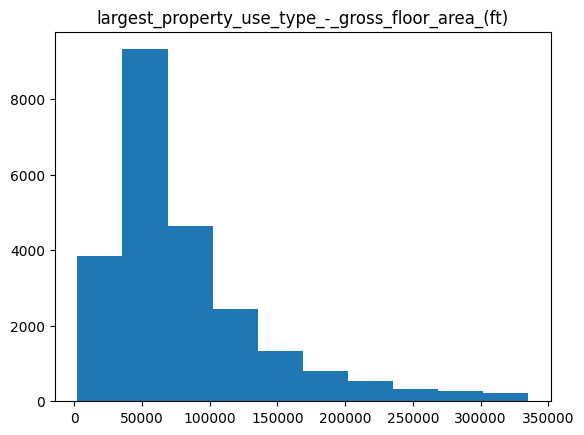

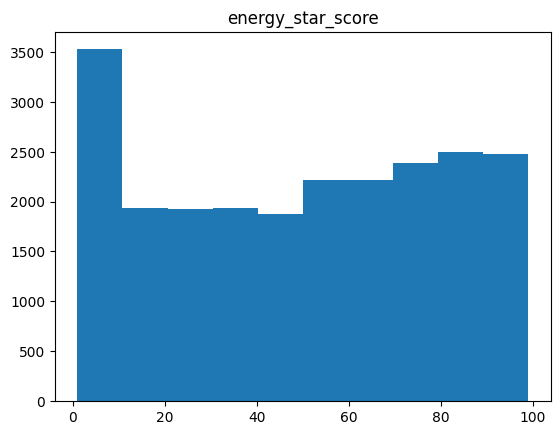

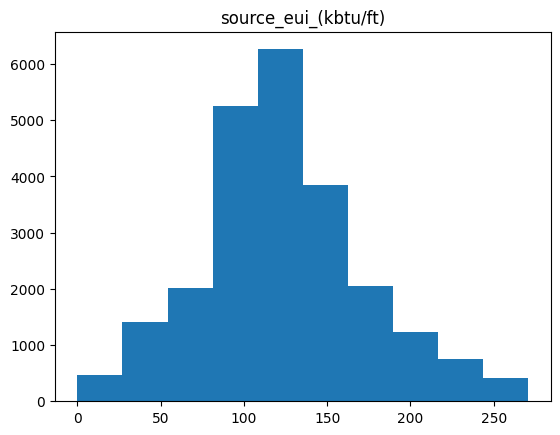

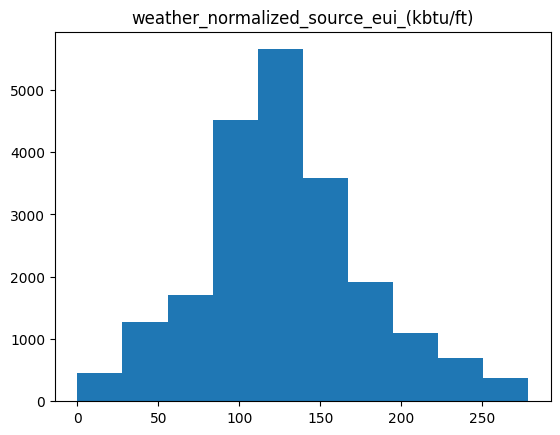

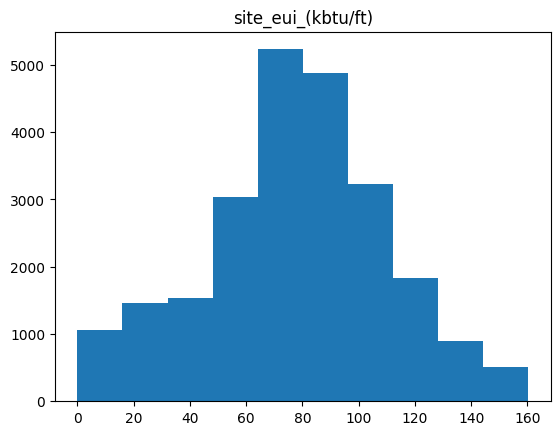

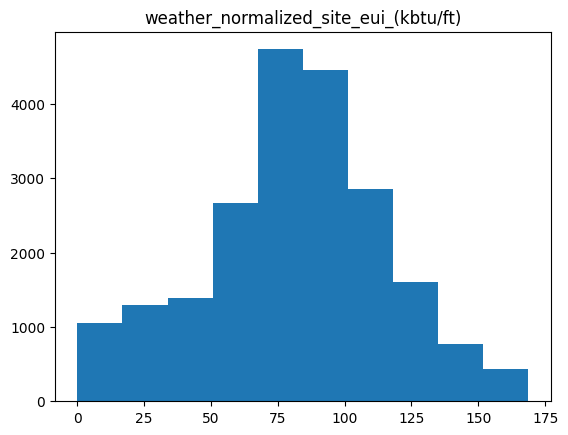

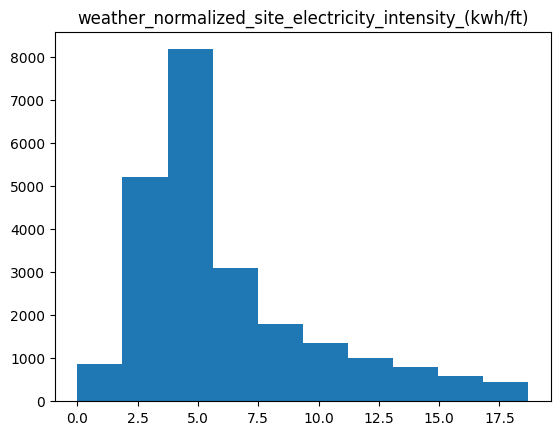

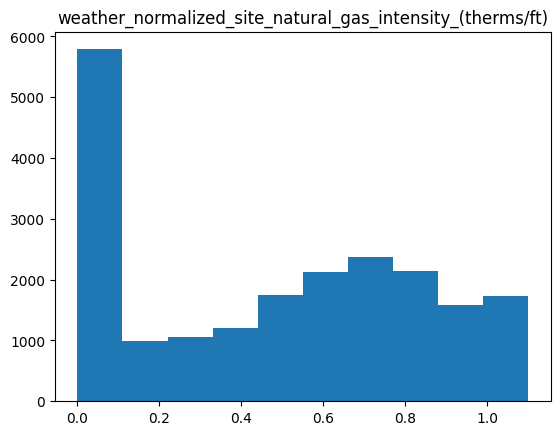

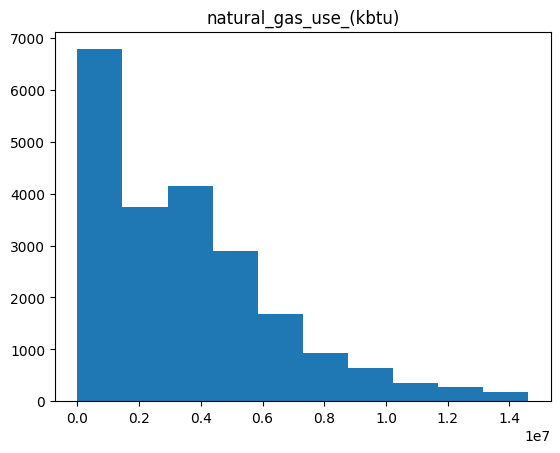

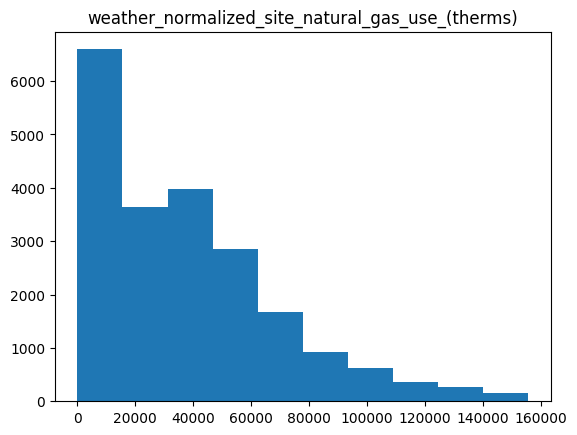

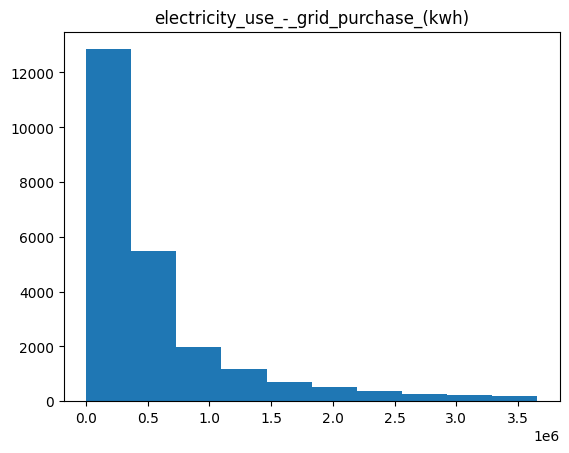

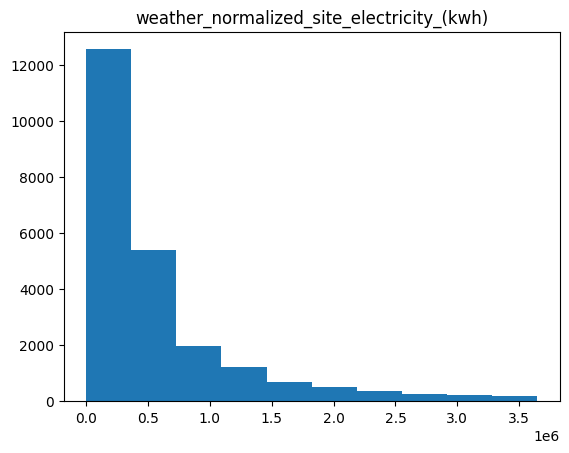

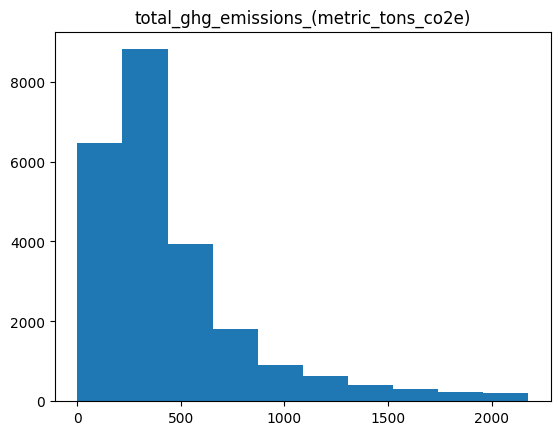

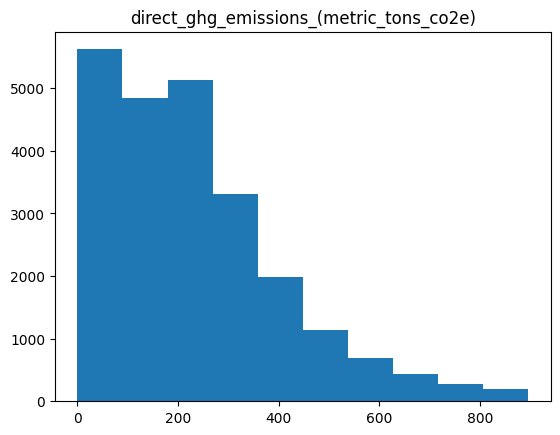

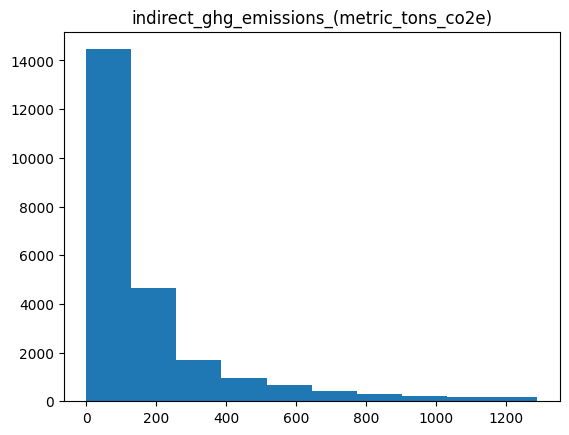

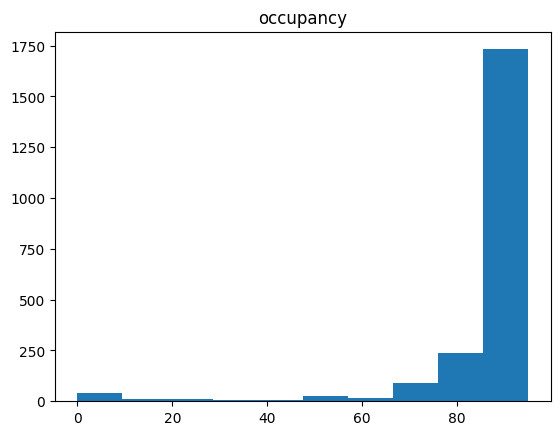

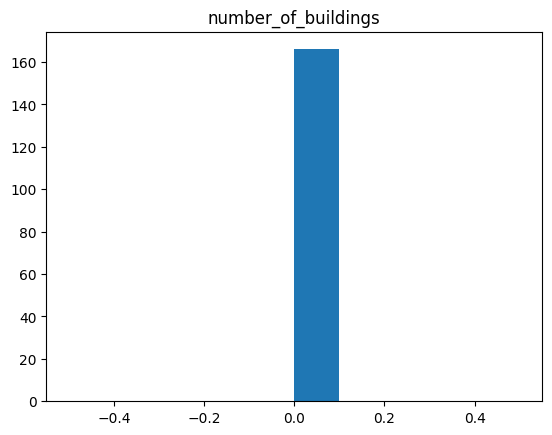

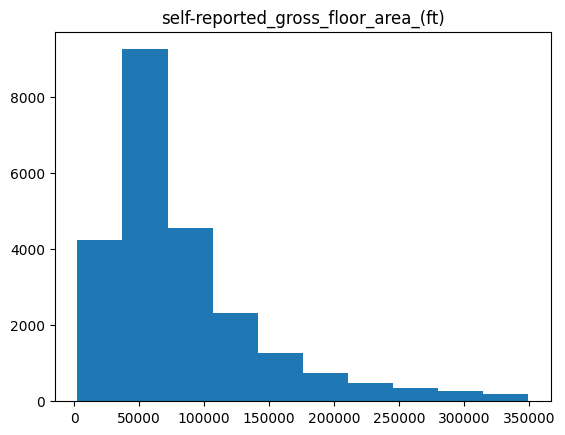

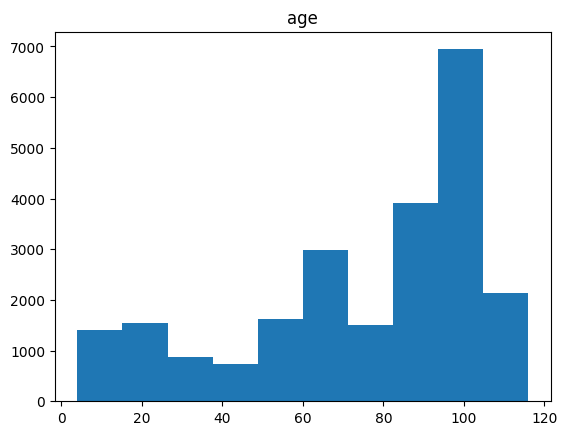

In [22]:
# max is much larger than median, so in order histogram to be infomative consider df[df[col]<df[col].qunatile(0.95)].hist()
for col in numerical_columns:
    plt.hist(data_cleaned[data_cleaned[col]<data_cleaned[col].quantile(0.95)][col])
    plt.title(col)
    plt.show()

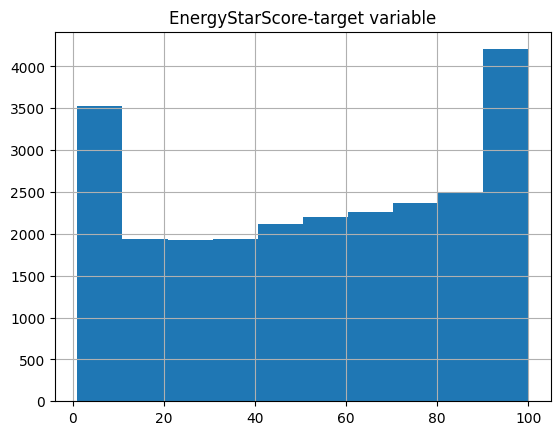

In [23]:
plt.title('EnergyStarScore-target variable')
data_cleaned['energy_star_score'].hist();

*Conclusion:*
1. There are no weird values in feature objects.
2. Some of them are normally distributed, some of them have are biased to the left.
3. Energy star score has "near" to uniform distribution on [0, 100]. No need to transform it, etc.

### Feature importance analysis

In [24]:
data_cleaned[numerical_columns].corrwith(data_cleaned['energy_star_score'])

largest_property_use_type_-_gross_floor_area_(ft)            0.077666
energy_star_score                                            1.000000
source_eui_(kbtu/ft)                                        -0.011098
weather_normalized_source_eui_(kbtu/ft)                     -0.011600
site_eui_(kbtu/ft)                                          -0.011062
weather_normalized_site_eui_(kbtu/ft)                       -0.011563
weather_normalized_site_electricity_intensity_(kwh/ft)      -0.294972
weather_normalized_site_natural_gas_intensity_(therms/ft)   -0.031643
natural_gas_use_(kbtu)                                      -0.025255
weather_normalized_site_natural_gas_use_(therms)            -0.025078
electricity_use_-_grid_purchase_(kwh)                       -0.044099
weather_normalized_site_electricity_(kwh)                   -0.042686
total_ghg_emissions_(metric_tons_co2e)                      -0.010522
direct_ghg_emissions_(metric_tons_co2e)                     -0.025906
indirect_ghg_emissio

Using mutual info regression:

In [25]:
dict(zip(numerical_columns, mutual_info_regression(data_cleaned[numerical_columns].fillna(0), data_cleaned['energy_star_score'], random_state=42)))

{'largest_property_use_type_-_gross_floor_area_(ft)': 0.6197155688851677,
 'energy_star_score': 4.461531253026823,
 'source_eui_(kbtu/ft)': 1.1826489511380132,
 'weather_normalized_source_eui_(kbtu/ft)': 0.9945039662515507,
 'site_eui_(kbtu/ft)': 1.0125403573656264,
 'weather_normalized_site_eui_(kbtu/ft)': 0.8841155381980981,
 'weather_normalized_site_electricity_intensity_(kwh/ft)': 0.3325947773113702,
 'weather_normalized_site_natural_gas_intensity_(therms/ft)': 0.2876696263347185,
 'natural_gas_use_(kbtu)': 0.6691538307481455,
 'weather_normalized_site_natural_gas_use_(therms)': 0.6547277253615951,
 'electricity_use_-_grid_purchase_(kwh)': 0.6631701386106998,
 'weather_normalized_site_electricity_(kwh)': 0.6611670800142795,
 'total_ghg_emissions_(metric_tons_co2e)': 0.7026285472294953,
 'direct_ghg_emissions_(metric_tons_co2e)': 0.6226544308153708,
 'indirect_ghg_emissions_(metric_tons_co2e)': 0.5590859990035524,
 'occupancy': 0.01619908919743729,
 'number_of_buildings': 0.00312692

*Conclusion:*

weather_normalized_site_electricity_intensity_(kwh/ft) column has comparatively high correlation with enery_star_score, the other variables have low correlation with the targen variable -> perhaps we need to leave some of them out.

Three variables seem to have large mutual info score: source_eui_(kbtu/ft), weather_normalized_site_eui_(kbtu/ft), site_eui_(kbtu/ft), weather_normalized_site_eui_(kbtu/ft)

#### Categorical variables

In [26]:
categorical_variables = list(set(data_cleaned.columns)-set(numerical_columns))

In [27]:
categorical_variables

['primary_property_type_-_self_selected',
 'largest_property_use_type',
 'postal_code',
 'borough',
 'address_1_(self-reported)',
 'list_of_all_property_use_types_at_property',
 'metered_areas_(energy)']

In [28]:

# Postal code is not 'unique' feature
len(data_cleaned['postal_code'].unique())/len(data_cleaned)

0.011817489885029845

In [29]:
# What is in column metered_areas_(energy)?
data_cleaned['metered_areas_(energy)'].unique()

array(['Whole Building', nan], dtype=object)

In [30]:
def dict_modified(l: list) -> dict:
    return {el[1]:el[0] for el in l}

In [31]:
list_of_parsed_address =[]
for k in range(0, len(data_cleaned)):
    try:
       list_of_parsed_address.append(dict_modified(usaddress.parse(data_cleaned['address_1_(self-reported)'].iloc[k])))
    except:
        list_of_parsed_address.append({'AddressNumber': data_cleaned['address_1_(self-reported)'].iloc[k]})

In [32]:
address_dataframe = pd.DataFrame(list_of_parsed_address).dropna(thresh=0.2*len(data_cleaned), axis=1).reset_index(drop=True)
address_dataframe.drop(columns=['StreetNamePreDirectional', 'StreetNamePostType'], inplace=True)

In [33]:

def proceed_categorical_columns(df):
     df_copy = df.copy()
     # to make a preprocessing easier we drop 'list_of_all_property_use_types_at_property' column;
     # 'address_1_(self-reported)' column is dropped since it has been parsed to multiple columns.
     # TODO: consider deleting postal code
     df_copy.drop(columns=['list_of_all_property_use_types_at_property', 'address_1_(self-reported)'], inplace=True)
     df_copy['metered_areas_(energy)'].fillna('NA', inplace=True)
     return df_copy.reset_index(drop=True)


In [34]:
data_categorical = pd.concat([proceed_categorical_columns(data_cleaned[categorical_variables]), address_dataframe], axis=1)

In [35]:
categorical_variables = data_categorical.columns

In [36]:
data_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24963 entries, 0 to 24962
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   primary_property_type_-_self_selected  24963 non-null  object
 1   largest_property_use_type              24963 non-null  object
 2   postal_code                            24963 non-null  object
 3   borough                                24963 non-null  object
 4   metered_areas_(energy)                 24963 non-null  object
 5   AddressNumber                          24864 non-null  object
 6   StreetName                             24878 non-null  object
dtypes: object(7)
memory usage: 1.3+ MB


What are the unique values for categorical columns

In [37]:
for cat in categorical_variables:
    print('===================')
    print(data_categorical[cat].value_counts())

Multifamily Housing                           18620
Office                                         2354
K-12 School                                    1474
Hotel                                           461
Residence Hall/Dormitory                        410
Non-Refrigerated Warehouse                      368
College/University                              249
Senior Care Community                           176
Retail Store                                    158
Distribution Center                             118
Worship Facility                                101
Supermarket/Grocery Store                       101
Hospital (General Medical & Surgical)            84
Medical Office                                   77
Refrigerated Warehouse                           39
Other                                            36
Mixed Use Property                               36
Courthouse                                       25
Financial Office                                 17
Other - Educ

In [38]:
categorical_variables = list(categorical_variables)

#### Producing pre final dataset after cleaning

In [39]:
data_full =  pd.concat([data_cleaned[numerical_columns].reset_index(drop=True), data_categorical.reset_index(drop=True).astype(str)], axis=1)

In [40]:
data_full

,largest_property_use_type_-_gross_floor_area_(ft),energy_star_score,source_eui_(kbtu/ft),weather_normalized_source_eui_(kbtu/ft),site_eui_(kbtu/ft),weather_normalized_site_eui_(kbtu/ft),weather_normalized_site_electricity_intensity_(kwh/ft),weather_normalized_site_natural_gas_intensity_(therms/ft),natural_gas_use_(kbtu),weather_normalized_site_natural_gas_use_(therms),...,number_of_buildings,self-reported_gross_floor_area_(ft),age,primary_property_type_-_self_selected,largest_property_use_type,postal_code,borough,metered_areas_(energy),AddressNumber,StreetName
0,164754.0,90.0,138.4,141.0,53.8,56.2,11.3,0.1,1435754.7,16672.2,...,1,169416,114,Office,Office,10019,Manhattan,Whole Building,224,57th
1,94380.0,100.0,43.5,46.8,28.4,31.3,2.0,0.2,2068300.1,23243.7,...,1,94380,60,K-12 School,K-12 School,11373,Queens,Whole Building,56-25,92nd
2,125000.0,83.0,271.1,274.7,130.2,133.7,18.8,0.7,8245445.1,86776.9,...,1,125000,24,Hotel,Hotel,10001-7507,Manhattan,Whole Building,1170,Broadway
3,50000.0,27.0,163.0,167.9,76.5,80.8,11.7,0.4,1848519.4,20520.9,...,1,50000,29,Hotel,Hotel,10001,Manhattan,Whole Building,1155,Broadway
4,50000.0,99.0,64.2,64.2,20.5,20.5,6.0,NaN,NaN,NaN,...,1,50000,11,Hotel,Hotel,10038,Manhattan,Whole Building,24,John
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24958,51960.0,43.0,129.8,136.3,107.7,113.8,2.8,1.0,5099274.9,54191.7,...,1,51960,60,Multifamily Housing,Multifamily Housing,11209,Brooklyn,Whole Building,8301,Ridge
24959,32800.0,47.0,123.6,132.6,101.6,110.2,2.8,1.0,3017000.3,32981.3,...,1,32800,92,Multifamily Housing,Multifamily Housing,11226,Brooklyn,Whole Building,2802,Clarendon
24960,32350.0,61.0,120.4,129.3,100.4,108.8,2.5,1.0,2969100.0,32420.7,...,1,32350,98,Multifamily Housing,Multifamily Housing,11225,Brooklyn,Whole Building,1116,Carroll
24961,33800.0,17.0,155.7,162.3,117.2,123.6,5.5,1.0,3333200.0,35467.9,...,1,33800,97,Multifamily Housing,Multifamily Housing,11235,Brooklyn,Whole Building,3033,13


# Validation Strategy

1. We will use 70% for training, 20% validation and 10% for testing of the final model.
2. To optimize hyperparameters we use cross validation on 5 folds, after this the model is validated on the validation set and we assess whether the results on cv and on validation set are comparable.

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
_bins = [0, np.quantile(data_full['energy_star_score'], 0.3), np.quantile(data_full['energy_star_score'], 0.6), max(data_full['energy_star_score'])]

data_full['label_for_target_var'] = pd.cut(data_full['energy_star_score'], bins=_bins, labels=False)

In [43]:
train_full, test_full = train_test_split(data_full, test_size=0.1, stratify=data_full['label_for_target_var'])

In [44]:
train_full.to_csv('/content/gdrive/MyDrive/data/train_full.csv', index=False)

In [45]:
test_full.to_csv('/content/gdrive/MyDrive/data/test_full.csv', index=False)

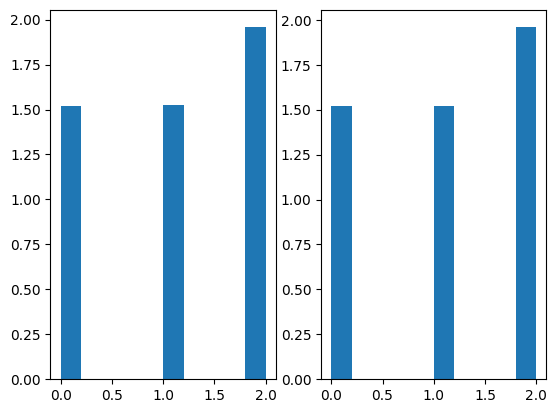

In [46]:
# We indeed have stratified samples:
fig, ax = plt.subplots(1,2)
ax[0].hist(train_full.label_for_target_var, density=True);
ax[1].hist(test_full.label_for_target_var, density=True);

In [47]:
train, val = train_test_split(train_full, test_size=0.3, stratify=train_full.label_for_target_var)

In [48]:
train.to_csv('/content/gdrive/MyDrive/data/train.csv', index=False)

In [49]:
val.to_csv('/content/gdrive/MyDrive/data/val.csv', index=False)

### Feature preprocessing

I could not think about good new features, so we use just preprocessing. Moreover I have tried lots of possibilities for preprocessing

In [50]:
numerical_columns.remove('energy_star_score')

In [51]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value=0)), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="constant", fill_value='No')),
        ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=3)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_columns),
        ("cat", categorical_transformer, categorical_variables),
    ],
    remainder='drop'
)

In [52]:
X_train = train.drop(columns=['energy_star_score', 'label_for_target_var'])
y_train = train['energy_star_score']

X_val = val.drop(columns=['energy_star_score', 'label_for_target_var'])
y_val = val['energy_star_score']

In [53]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['largest_property_use_type_-_gross_floor_area_(ft)',
                                  'source_eui_(kbtu/ft)',
                                  'weather_normalized_source_eui_(kbtu/ft)',
                                  'site_eui_(kbtu/ft)',
                                  'weather_normalized_site_eui_(kbtu/ft)',
                                  'weather_normalized_site_e...
                                  'self-reported_gross_floor_area_(ft)',
                                  'age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='No',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=3))]),
                                 ['primary_property_type_-_self_selected',
                                  'largest_property_use_type', 'postal_code',
                                  'borough', 'metered_areas_(energy)',
                                  'AddressNumber', 'StreetName'])])

In [54]:
# Change the directory if run on another device
with open('/content/gdrive/MyDrive/data/preprocess.pkl', 'wb') as f_in:
  pickle.dump(preprocessor, f_in)

In [55]:
X_train_preprocessed = preprocessor.transform(X_train)

In [56]:
X_val_preprocessed  = preprocessor.transform(X_val)

### Attempt 0: Lasso Regression

In [57]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='constant', fill_value='Missed')),
        ("encoder", TargetEncoder(target_type='continuous', random_state=42)),
        ("scaler", StandardScaler())
            ]
)
preprocessor_lasso = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_columns),
        ("cat", categorical_transformer, categorical_variables),
    ],
    remainder='drop'
)

In [58]:
preprocessor_lasso.fit(X_train, y_train)
X_train_preprocessed_lasso = preprocessor_lasso.transform(X_train)
X_val_preprocessed_lasso  = preprocessor_lasso.transform(X_val)

In [59]:
lasso = Lasso(random_state=42, max_iter=5000)
param_lasso = {
    'alpha': [10**(-4), 10**(-3), 10**(-2), 10**(-1), 1, 5, 10,100]
}

In [60]:
grid_search = GridSearchCV(lasso,
                 param_lasso,
                 scoring='neg_mean_squared_error',
                 n_jobs=-1,
                 refit=True,
                 cv=5,
                 verbose=2)

In [61]:
grid_search.fit(X_train_preprocessed_lasso, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Lasso(max_iter=5000, random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100]},
             scoring='neg_mean_squared_error', verbose=2)

In [62]:
grid_search.best_score_, grid_search.best_params_

(-495.0738433849172, {'alpha': 0.01})

In [63]:
mean_squared_error(grid_search.best_estimator_.predict(X_val_preprocessed_lasso), y_val, squared=False)

73.90718549641579

In [64]:
r2_score(y_val, grid_search.best_estimator_.predict(X_val_preprocessed_lasso))

-4.257784712409077

Conclusion: it is **a very bad model**, that predicts worth than a constant model. This is not surprising, since we even have a warning from

### Attempt 1: SGD Regressor

In [65]:
sgd = SGDRegressor(random_state=42, penalty='l2', learning_rate='constant', max_iter=3000)
param_sgd = {
    'alpha': [10**2, 10**3, 5*10**2],
    'eta0': [10**(-7), 10**(-6), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 1, 5, 10],
    'learning_rate': ['constant', 'optimal', 'adaptive']
}

In [66]:
grid_search = GridSearchCV(sgd,
                 param_sgd,
                 scoring='neg_mean_squared_error',
                 n_jobs=-1,
                 refit=True,
                 cv=5)

In [67]:
grid_search.fit(X_train_preprocessed_lasso, y_train)

GridSearchCV(cv=5,
             estimator=SGDRegressor(learning_rate='constant', max_iter=3000,
                                    random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [100, 1000, 500],
                         'eta0': [1e-07, 1e-06, 0.0001, 0.001, 0.01, 0.1, 1, 5,
                                  10],
                         'learning_rate': ['constant', 'optimal', 'adaptive']},
             scoring='neg_mean_squared_error')

In [68]:
grid_search.best_score_, grid_search.best_params_

(-1029.3624007812864,
 {'alpha': 100, 'eta0': 0.001, 'learning_rate': 'constant'})

In [69]:
y_val_predicted = grid_search.best_estimator_.predict(X_val_preprocessed_lasso)

In [70]:
mean_squared_error(y_val, y_val_predicted, squared=False)

32.15534823493566

### 2. RandomForestRegressor

Here I use optuna to tune parameters instead of GridSearchCV

In [71]:
k_folds = KFold(n_splits=3, random_state=42, shuffle=True)
kfolds = k_folds.get_n_splits(X_train_preprocessed)

def objective(trial):
        print(trial)
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 3000, 100),
            'max_depth': trial.suggest_int('max_depth', 10, 20, 5),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, 2),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 15, 40, 2),
            'random_state': 42,
            'n_jobs': -1
        }
        rf = RandomForestRegressor(**params)
        rf.fit(X_train_preprocessed, y_train)
        scores = cross_val_score(rf, X_train_preprocessed, y_train, cv=kfolds,
        scoring="neg_root_mean_squared_error")
        print(scores)
        return scores.mean()



In [72]:
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=5)

[I 2023-11-03 13:54:29,553] A new study created in memory with name: no-name-e4ba0ca4-0ac4-497b-a5d1-333e44afde8a
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [15, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [15, 39].
  warnings.warn(


[I 2023-11-03 14:00:52,791] Trial 0 finished with value: -14.070967471145613 and parameters: {'n_estimators': 1400, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 29}. Best is trial 0 with value: -14.070967471145613.


[-14.02866122 -14.30482632 -13.87941487]


/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [15, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [15, 39].
  warnings.warn(
[I 2023-11-03 14:04:21,986] Trial 1 finished with value: -14.254358700571887 and parameters: {'n_estimators': 900, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 37}. Best is trial 1 with value: -14.254358700571887.


[-14.22338592 -14.46883765 -14.07085254]


/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [15, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [15, 39].
  warnings.warn(
[I 2023-11-03 14:12:08,717] Trial 2 finished with value: -14.275762846195862 and parameters: {'n_estimators': 2000, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 39}. Best is trial 2 with value: -14.275762846195862.


[-14.24109506 -14.49021897 -14.0959745 ]


/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [15, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [15, 39].
  warnings.warn(
[I 2023-11-03 14:23:57,662] Trial 3 finished with value: -13.69101636328697 and parameters: {'n_estimators': 2600, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 19}. Best is trial 2 with value: -14.275762846195862.


[-13.64061732 -13.95935092 -13.47308085]


/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [15, 40] and step=2, but the range is not divisible by `step`. It will be replaced by [15, 39].
  warnings.warn(
[I 2023-11-03 14:30:01,133] Trial 4 finished with value: -13.716523515303658 and parameters: {'n_estimators': 1200, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 21}. Best is trial 2 with value: -14.275762846195862.


[-13.67061853 -13.96987628 -13.50907574]


In [73]:
study.best_params

{'n_estimators': 2000,
 'max_depth': 20,
 'min_samples_split': 2,
 'min_samples_leaf': 39}

In [74]:
rf_best = RandomForestRegressor(**study.best_params)
rf_best.fit(X_train_preprocessed, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=39, n_estimators=2000)

In [75]:
mean_squared_error(rf_best.predict(X_val_preprocessed), y_val, squared=False)

14.26854839633058

In [76]:
r2_score(y_val, rf_best.predict(X_val_preprocessed))

0.8040302418536889

### Attempt 3: GradientBoosting.LightGBM

Here we use an optuna integration with lightgbm to tune parameters
I refer to https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.lightgbm.train.html for more details

In [77]:
train_lgb_data = lgb.Dataset(X_train_preprocessed, label=y_train, free_raw_data=True)

In [78]:
val_lgb_data = lgb.Dataset(X_val_preprocessed, label=y_val, reference=train_lgb_data, free_raw_data=True)

In [79]:
params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        'max_depth': 3,
        'max_bin': 3000
    }

In [80]:
model = lgb.train(
        params,
        train_lgb_data,
        valid_sets=[train_lgb_data, val_lgb_data],
        callbacks=[early_stopping(100), log_evaluation(100)],
        num_boost_round=2000
    )

[I 2023-11-03 14:47:08,762] A new study created in memory with name: no-name-dbeb3084-6efe-4770-b26f-4d5e2d66ef7c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0764	valid_1's rmse: 13.819
[200]	valid_0's rmse: 12.5783	valid_1's rmse: 13.5243
[300]	valid_0's rmse: 12.2913	valid_1's rmse: 13.3717
[400]	valid_0's rmse: 12.1012	valid_1's rmse: 13.2866
[500]	valid_0's rmse: 11.885	valid_1's rmse: 13.2014
[600]	valid_0's rmse: 11.6722	valid_1's rmse: 13.1036
[700]	valid_0's rmse: 11.4649	valid_1's rmse: 13.0238
[800]	valid_0's rmse: 11.2614	valid_1's rmse: 12.954
[900]	valid_0's rmse: 11.0859	valid_1's rmse: 12.877
[1000]	valid_0's rmse: 10.9291	valid_1's rmse: 12.8202
[1100]	valid_0's rmse: 10.7563	valid_1's rmse: 12.7674
[1200]	valid_0's rmse: 10.5678	valid_1's rmse: 12.6989
[1300]	valid_0's rmse: 10.4216	valid_1's rmse: 12.6574
[1400]	valid_0's rmse: 10.2723	valid_1's rmse: 12.6192
[1500]	valid_0's rmse: 10.1347	valid_1's rmse: 12.5765
[1600]	valid_0's rmse: 10.0163	valid_1's rmse: 12.5466
[1700]	valid_0's rmse: 9.8911	valid_1's rmse: 12.5173
[1800]	valid_0's 

feature_fraction, val_score: 12.427824:  14%|#4        | 1/7 [00:07<00:43,  7.21s/it]

[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.1732	valid_1's rmse: 13.9474
[200]	valid_0's rmse: 12.5781	valid_1's rmse: 13.5588
[300]	valid_0's rmse: 12.292	valid_1's rmse: 13.3963
[400]	valid_0's rmse: 12.0158	valid_1's rmse: 13.2684
[500]	valid_0's rmse: 11.8259	valid_1's rmse: 13.1875
[600]	valid_0's rmse: 11.6191	valid_1's rmse: 13.0921
[700]	valid_0's rmse: 11.4353	valid_1's rmse: 13.0267
[800]	valid_0's rmse: 11.2549	valid_1's rmse: 12.958
[900]	valid_0's rmse: 11.0853	valid_1's rmse: 12.9028
[1000]	valid_0's rmse: 10.9304	valid_1's rmse: 12.8458
[1100]	valid_0's rmse: 10.7689	valid_1's rmse: 12.7968
[1200]	valid_0's rmse: 10.6252	valid_1's rmse: 12.7645
[1300]	valid_0's rmse: 10.4788	valid_1's rmse: 12.7151
[1400]	valid_0's rmse: 10.3409	valid_1's rmse: 12.6717
[1500]	valid_0's rmse

feature_fraction, val_score: 12.427824:  29%|##8       | 2/7 [00:12<00:31,  6.30s/it]

[2000]	valid_0's rmse: 9.55616	valid_1's rmse: 12.4885
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.55616	valid_1's rmse: 12.4885
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0661	valid_1's rmse: 13.8644
[200]	valid_0's rmse: 12.6005	valid_1's rmse: 13.5904
[300]	valid_0's rmse: 12.2989	valid_1's rmse: 13.4248
[400]	valid_0's rmse: 12.0843	valid_1's rmse: 13.317
[500]	valid_0's rmse: 11.8574	valid_1's rmse: 13.2157
[600]	valid_0's rmse: 11.6332	valid_1's rmse: 13.1308
[700]	valid_0's rmse: 11.4132	valid_1's rmse: 13.0389
[800]	valid_0's rmse: 11.192	valid_1's rmse: 12.9544
[900]	valid_0's rmse: 10.9797	valid_1's rmse: 12.8818
[1000]	valid_0's rmse: 10.8132	valid_1's rmse: 12.8328
[1100]	valid_0's rmse: 10.6437	valid_1's rmse: 12.7778
[1200]	valid_0's rmse: 10.4575	valid_1's rmse: 12.7254
[1300]	valid_0's rmse: 10.2892	valid_1's rmse: 12.6661
[1400]	valid_0's rmse: 10.1592	valid_1's rmse: 12.6333
[1500]	valid_0's rmse

feature_fraction, val_score: 12.427824:  43%|####2     | 3/7 [00:20<00:28,  7.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0665	valid_1's rmse: 13.8377
[200]	valid_0's rmse: 12.5912	valid_1's rmse: 13.5444
[300]	valid_0's rmse: 12.2986	valid_1's rmse: 13.4052
[400]	valid_0's rmse: 12.0556	valid_1's rmse: 13.3035
[500]	valid_0's rmse: 11.808	valid_1's rmse: 13.2004
[600]	valid_0's rmse: 11.61	valid_1's rmse: 13.1199
[700]	valid_0's rmse: 11.3822	valid_1's rmse: 13.0318
[800]	valid_0's rmse: 11.1639	valid_1's rmse: 12.9508
[900]	valid_0's rmse: 10.9855	valid_1's rmse: 12.8859
[1000]	valid_0's rmse: 10.8277	valid_1's rmse: 12.8354
[1100]	valid_0's rmse: 10.6361	valid_1's rmse: 12.7748
[1200]	valid_0's rmse: 10.4785	valid_1's rmse: 12.7255
[1300]	valid_0's rmse: 10.3513	valid_1's rmse: 12.6856
[1400]	valid_0's rmse: 10.2107	valid_1's rmse: 12.6432
[1500]	valid_0's rmse: 10.0688	valid_1's rmse: 12.5976
[1600]	valid_0's rmse: 9.95543	valid_1's rmse: 12.5722
[1700]	valid_0's rmse: 9.82572	valid_1's rmse: 12.5446
[1800]	valid_0'

feature_fraction, val_score: 12.427824:  57%|#####7    | 4/7 [00:24<00:17,  5.83s/it]

[2000]	valid_0's rmse: 9.47044	valid_1's rmse: 12.4634
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.47044	valid_1's rmse: 12.4634
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0747	valid_1's rmse: 13.8652
[200]	valid_0's rmse: 12.6285	valid_1's rmse: 13.616
[300]	valid_0's rmse: 12.3722	valid_1's rmse: 13.4917
[400]	valid_0's rmse: 12.1017	valid_1's rmse: 13.3459
[500]	valid_0's rmse: 11.8613	valid_1's rmse: 13.2329
[600]	valid_0's rmse: 11.6328	valid_1's rmse: 13.1215
[700]	valid_0's rmse: 11.442	valid_1's rmse: 13.0451
[800]	valid_0's rmse: 11.2089	valid_1's rmse: 12.9626
[900]	valid_0's rmse: 11.0199	valid_1's rmse: 12.8986
[1000]	valid_0's rmse: 10.8384	valid_1's rmse: 12.845
[1100]	valid_0's rmse: 10.6587	valid_1's rmse: 12.7795
[1200]	valid_0's rmse: 10.4756	valid_1's rmse: 12.7073
[1300]	valid_0's rmse: 10.3452	valid_1's rmse: 12.6728
[1400]	valid_0's rmse: 10.2043	valid_1's rmse: 12.6306
[1500]	valid_0's rmse:

feature_fraction, val_score: 12.427824:  71%|#######1  | 5/7 [00:28<00:10,  5.24s/it]

[2000]	valid_0's rmse: 9.41418	valid_1's rmse: 12.4383
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.41418	valid_1's rmse: 12.4383
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0653	valid_1's rmse: 13.8045
[200]	valid_0's rmse: 12.5665	valid_1's rmse: 13.5063
[300]	valid_0's rmse: 12.2919	valid_1's rmse: 13.3731
[400]	valid_0's rmse: 12.0963	valid_1's rmse: 13.28
[500]	valid_0's rmse: 11.8681	valid_1's rmse: 13.1826
[600]	valid_0's rmse: 11.6857	valid_1's rmse: 13.106
[700]	valid_0's rmse: 11.4514	valid_1's rmse: 13.0096
[800]	valid_0's rmse: 11.2776	valid_1's rmse: 12.9372
[900]	valid_0's rmse: 11.1022	valid_1's rmse: 12.862
[1000]	valid_0's rmse: 10.9309	valid_1's rmse: 12.8011
[1100]	valid_0's rmse: 10.7526	valid_1's rmse: 12.7447
[1200]	valid_0's rmse: 10.6097	valid_1's rmse: 12.7035
[1300]	valid_0's rmse: 10.4584	valid_1's rmse: 12.6691
[1400]	valid_0's rmse: 10.3122	valid_1's rmse: 12.6288
[1500]	valid_0's rmse: 

feature_fraction, val_score: 12.427824:  86%|########5 | 6/7 [00:38<00:06,  6.83s/it]

[2000]	valid_0's rmse: 9.56628	valid_1's rmse: 12.4448
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.56628	valid_1's rmse: 12.4448
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.035	valid_1's rmse: 13.8233
[200]	valid_0's rmse: 12.5659	valid_1's rmse: 13.5521
[300]	valid_0's rmse: 12.3022	valid_1's rmse: 13.4212
[400]	valid_0's rmse: 12.0579	valid_1's rmse: 13.3026
[500]	valid_0's rmse: 11.849	valid_1's rmse: 13.2148
[600]	valid_0's rmse: 11.634	valid_1's rmse: 13.1255
[700]	valid_0's rmse: 11.4565	valid_1's rmse: 13.0584
[800]	valid_0's rmse: 11.2002	valid_1's rmse: 12.9519
[900]	valid_0's rmse: 11.0399	valid_1's rmse: 12.8932
[1000]	valid_0's rmse: 10.8337	valid_1's rmse: 12.8063
[1100]	valid_0's rmse: 10.6922	valid_1's rmse: 12.7592
[1200]	valid_0's rmse: 10.5112	valid_1's rmse: 12.7056
[1300]	valid_0's rmse: 10.3871	valid_1's rmse: 12.6656
[1400]	valid_0's rmse: 10.2415	valid_1's rmse: 12.6152
[1500]	valid_0's rmse:

feature_fraction, val_score: 12.427824: 100%|##########| 7/7 [00:43<00:00,  6.16s/it]


[2000]	valid_0's rmse: 9.48221	valid_1's rmse: 12.4433
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.48221	valid_1's rmse: 12.4433


num_leaves, val_score: 12.427824:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0764	valid_1's rmse: 13.819
[200]	valid_0's rmse: 12.5783	valid_1's rmse: 13.5243
[300]	valid_0's rmse: 12.2913	valid_1's rmse: 13.3717
[400]	valid_0's rmse: 12.1012	valid_1's rmse: 13.2866
[500]	valid_0's rmse: 11.885	valid_1's rmse: 13.2014
[600]	valid_0's rmse: 11.6722	valid_1's rmse: 13.1036
[700]	valid_0's rmse: 11.4649	valid_1's rmse: 13.0238
[800]	valid_0's rmse: 11.2614	valid_1's rmse: 12.954
[900]	valid_0's rmse: 11.0859	valid_1's rmse: 12.877
[1000]	valid_0's rmse: 10.9291	valid_1's rmse: 12.8202
[1100]	valid_0's rmse: 10.7563	valid_1's rmse: 12.7674
[1200]	valid_0's rmse: 10.5678	valid_1's rmse: 12.6989
[1300]	valid_0's rmse: 10.4216	valid_1's rmse: 12.6574
[1400]	valid_0's rmse: 10.2723	valid_1's rmse: 12.6192
[1500]	valid_0's rmse: 10.1347	valid_1's rmse: 12.5765
[1600]	valid_0's rmse: 10.0163	valid_1's rmse: 12.5466
[1700]	valid_0's rmse: 9.8911	valid_1's rmse: 12.5173
[1800]	valid_0's 

num_leaves, val_score: 12.427824:   5%|5         | 1/20 [00:09<02:53,  9.11s/it]

[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.452	valid_1's rmse: 14.1252
[200]	valid_0's rmse: 12.8988	valid_1's rmse: 13.7284
[300]	valid_0's rmse: 12.619	valid_1's rmse: 13.5729
[400]	valid_0's rmse: 12.3943	valid_1's rmse: 13.449
[500]	valid_0's rmse: 12.195	valid_1's rmse: 13.3527
[600]	valid_0's rmse: 12.0018	valid_1's rmse: 13.2722
[700]	valid_0's rmse: 11.844	valid_1's rmse: 13.2042
[800]	valid_0's rmse: 11.6725	valid_1's rmse: 13.1257
[900]	valid_0's rmse: 11.5209	valid_1's rmse: 13.0651
[1000]	valid_0's rmse: 11.3867	valid_1's rmse: 13.0209
[1100]	valid_0's rmse: 11.2468	valid_1's rmse: 12.9622
[1200]	valid_0's rmse: 11.1277	valid_1's rmse: 12.9147
[1300]	valid_0's rmse: 11.0074	valid_1's rmse: 12.8706
[1400]	valid_0's rmse: 10.8909	valid_1's rmse: 12.8332
[1500]	valid_0's rmse: 1

num_leaves, val_score: 12.427824:  10%|#         | 2/20 [00:14<02:02,  6.80s/it]

[2000]	valid_0's rmse: 10.2721	valid_1's rmse: 12.6599
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 10.2721	valid_1's rmse: 12.6599
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 16.0795	valid_1's rmse: 16.3987
[200]	valid_0's rmse: 15.1372	valid_1's rmse: 15.5866
[300]	valid_0's rmse: 14.7563	valid_1's rmse: 15.2905
[400]	valid_0's rmse: 14.5484	valid_1's rmse: 15.1379
[500]	valid_0's rmse: 14.4094	valid_1's rmse: 15.0395
[600]	valid_0's rmse: 14.3062	valid_1's rmse: 14.9653
[700]	valid_0's rmse: 14.226	valid_1's rmse: 14.9153
[800]	valid_0's rmse: 14.1616	valid_1's rmse: 14.8726
[900]	valid_0's rmse: 14.1079	valid_1's rmse: 14.841
[1000]	valid_0's rmse: 14.062	valid_1's rmse: 14.8188
[1100]	valid_0's rmse: 14.0217	valid_1's rmse: 14.796
[1200]	valid_0's rmse: 13.9859	valid_1's rmse: 14.7762
[1300]	valid_0's rmse: 13.9538	valid_1's rmse: 14.7571
[1400]	valid_0's rmse: 13.9247	valid_1's rmse: 14.7451
[1500]	valid_0's rmse: 

num_leaves, val_score: 12.427824:  15%|#5        | 3/20 [00:17<01:30,  5.33s/it]

[2000]	valid_0's rmse: 13.7911	valid_1's rmse: 14.671
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 13.7911	valid_1's rmse: 14.671
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 16.0795	valid_1's rmse: 16.3987
[200]	valid_0's rmse: 15.1372	valid_1's rmse: 15.5866
[300]	valid_0's rmse: 14.7563	valid_1's rmse: 15.2905
[400]	valid_0's rmse: 14.5484	valid_1's rmse: 15.1379
[500]	valid_0's rmse: 14.4094	valid_1's rmse: 15.0395
[600]	valid_0's rmse: 14.3062	valid_1's rmse: 14.9653
[700]	valid_0's rmse: 14.226	valid_1's rmse: 14.9153
[800]	valid_0's rmse: 14.1616	valid_1's rmse: 14.8726
[900]	valid_0's rmse: 14.1079	valid_1's rmse: 14.841
[1000]	valid_0's rmse: 14.062	valid_1's rmse: 14.8188
[1100]	valid_0's rmse: 14.0217	valid_1's rmse: 14.796
[1200]	valid_0's rmse: 13.9859	valid_1's rmse: 14.7762
[1300]	valid_0's rmse: 13.9538	valid_1's rmse: 14.7571
[1400]	valid_0's rmse: 13.9247	valid_1's rmse: 14.7451
[1500]	valid_0's rmse: 13

num_leaves, val_score: 12.427824:  20%|##        | 4/20 [00:24<01:35,  5.99s/it]

[2000]	valid_0's rmse: 13.7911	valid_1's rmse: 14.671
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 13.7911	valid_1's rmse: 14.671
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0764	valid_1's rmse: 13.819
[200]	valid_0's rmse: 12.5783	valid_1's rmse: 13.5243
[300]	valid_0's rmse: 12.2913	valid_1's rmse: 13.3717
[400]	valid_0's rmse: 12.1012	valid_1's rmse: 13.2866
[500]	valid_0's rmse: 11.885	valid_1's rmse: 13.2014
[600]	valid_0's rmse: 11.6722	valid_1's rmse: 13.1036
[700]	valid_0's rmse: 11.4649	valid_1's rmse: 13.0238
[800]	valid_0's rmse: 11.2614	valid_1's rmse: 12.954
[900]	valid_0's rmse: 11.0859	valid_1's rmse: 12.877
[1000]	valid_0's rmse: 10.9291	valid_1's rmse: 12.8202
[1100]	valid_0's rmse: 10.7563	valid_1's rmse: 12.7674
[1200]	valid_0's rmse: 10.5678	valid_1's rmse: 12.6989
[1300]	valid_0's rmse: 10.4216	valid_1's rmse: 12.6574
[1400]	valid_0's rmse: 10.2723	valid_1's rmse: 12.6192
[1500]	valid_0's rmse: 10

num_leaves, val_score: 12.427824:  25%|##5       | 5/20 [00:30<01:28,  5.90s/it]

[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0764	valid_1's rmse: 13.819
[200]	valid_0's rmse: 12.5783	valid_1's rmse: 13.5243
[300]	valid_0's rmse: 12.2913	valid_1's rmse: 13.3717
[400]	valid_0's rmse: 12.1012	valid_1's rmse: 13.2866
[500]	valid_0's rmse: 11.885	valid_1's rmse: 13.2014
[600]	valid_0's rmse: 11.6722	valid_1's rmse: 13.1036
[700]	valid_0's rmse: 11.4649	valid_1's rmse: 13.0238
[800]	valid_0's rmse: 11.2614	valid_1's rmse: 12.954
[900]	valid_0's rmse: 11.0859	valid_1's rmse: 12.877
[1000]	valid_0's rmse: 10.9291	valid_1's rmse: 12.8202
[1100]	valid_0's rmse: 10.7563	valid_1's rmse: 12.7674
[1200]	valid_0's rmse: 10.5678	valid_1's rmse: 12.6989
[1300]	valid_0's rmse: 10.4216	valid_1's rmse: 12.6574
[1400]	valid_0's rmse: 10.2723	valid_1's rmse: 12.6192
[1500]	valid_0's rmse: 

num_leaves, val_score: 12.427824:  30%|###       | 6/20 [00:36<01:20,  5.75s/it]

[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.2671	valid_1's rmse: 13.9715
[200]	valid_0's rmse: 12.7563	valid_1's rmse: 13.6472
[300]	valid_0's rmse: 12.4888	valid_1's rmse: 13.4908
[400]	valid_0's rmse: 12.2335	valid_1's rmse: 13.3521
[500]	valid_0's rmse: 12.0347	valid_1's rmse: 13.2791
[600]	valid_0's rmse: 11.8369	valid_1's rmse: 13.1951
[700]	valid_0's rmse: 11.6615	valid_1's rmse: 13.1239
[800]	valid_0's rmse: 11.4773	valid_1's rmse: 13.0612
[900]	valid_0's rmse: 11.3129	valid_1's rmse: 13.0026
[1000]	valid_0's rmse: 11.1648	valid_1's rmse: 12.9517
[1100]	valid_0's rmse: 11.0165	valid_1's rmse: 12.907
[1200]	valid_0's rmse: 10.895	valid_1's rmse: 12.8628
[1300]	valid_0's rmse: 10.7483	valid_1's rmse: 12.8021
[1400]	valid_0's rmse: 10.6363	valid_1's rmse: 12.7642
[1500]	valid_0's rmse

num_leaves, val_score: 12.427824:  35%|###5      | 7/20 [00:45<01:30,  6.97s/it]

[2000]	valid_0's rmse: 9.9371	valid_1's rmse: 12.5559
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.9371	valid_1's rmse: 12.5559
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.2671	valid_1's rmse: 13.9715
[200]	valid_0's rmse: 12.7563	valid_1's rmse: 13.6472
[300]	valid_0's rmse: 12.4888	valid_1's rmse: 13.4908
[400]	valid_0's rmse: 12.2335	valid_1's rmse: 13.3521
[500]	valid_0's rmse: 12.0347	valid_1's rmse: 13.2791
[600]	valid_0's rmse: 11.8369	valid_1's rmse: 13.1951
[700]	valid_0's rmse: 11.6615	valid_1's rmse: 13.1239
[800]	valid_0's rmse: 11.4773	valid_1's rmse: 13.0612
[900]	valid_0's rmse: 11.3129	valid_1's rmse: 13.0026
[1000]	valid_0's rmse: 11.1648	valid_1's rmse: 12.9517
[1100]	valid_0's rmse: 11.0165	valid_1's rmse: 12.907
[1200]	valid_0's rmse: 10.895	valid_1's rmse: 12.8628
[1300]	valid_0's rmse: 10.7483	valid_1's rmse: 12.8021
[1400]	valid_0's rmse: 10.6363	valid_1's rmse: 12.7642
[1500]	valid_0's rmse: 

num_leaves, val_score: 12.427824:  40%|####      | 8/20 [00:50<01:17,  6.45s/it]

[2000]	valid_0's rmse: 9.9371	valid_1's rmse: 12.5559
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.9371	valid_1's rmse: 12.5559
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.8357	valid_1's rmse: 14.4459
[200]	valid_0's rmse: 13.165	valid_1's rmse: 13.9428
[300]	valid_0's rmse: 12.8421	valid_1's rmse: 13.74
[400]	valid_0's rmse: 12.6228	valid_1's rmse: 13.6178
[500]	valid_0's rmse: 12.4543	valid_1's rmse: 13.5273
[600]	valid_0's rmse: 12.2764	valid_1's rmse: 13.4215
[700]	valid_0's rmse: 12.1227	valid_1's rmse: 13.351
[800]	valid_0's rmse: 11.9664	valid_1's rmse: 13.2673
[900]	valid_0's rmse: 11.838	valid_1's rmse: 13.194
[1000]	valid_0's rmse: 11.7273	valid_1's rmse: 13.1411
[1100]	valid_0's rmse: 11.6193	valid_1's rmse: 13.0957
[1200]	valid_0's rmse: 11.5186	valid_1's rmse: 13.053
[1300]	valid_0's rmse: 11.4044	valid_1's rmse: 13.0045
[1400]	valid_0's rmse: 11.2991	valid_1's rmse: 12.9628
[1500]	valid_0's rmse: 11.20

num_leaves, val_score: 12.427824:  45%|####5     | 9/20 [00:59<01:18,  7.10s/it]

[2000]	valid_0's rmse: 10.7837	valid_1's rmse: 12.7949
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 10.7837	valid_1's rmse: 12.7949
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.1681	valid_1's rmse: 13.9166
[200]	valid_0's rmse: 12.6375	valid_1's rmse: 13.5659
[300]	valid_0's rmse: 12.3608	valid_1's rmse: 13.4414
[400]	valid_0's rmse: 12.1517	valid_1's rmse: 13.3409
[500]	valid_0's rmse: 11.9445	valid_1's rmse: 13.2291
[600]	valid_0's rmse: 11.7399	valid_1's rmse: 13.1442
[700]	valid_0's rmse: 11.5109	valid_1's rmse: 13.0596
[800]	valid_0's rmse: 11.3181	valid_1's rmse: 12.9778
[900]	valid_0's rmse: 11.1438	valid_1's rmse: 12.9163
[1000]	valid_0's rmse: 10.9674	valid_1's rmse: 12.861
[1100]	valid_0's rmse: 10.8046	valid_1's rmse: 12.7955
[1200]	valid_0's rmse: 10.6538	valid_1's rmse: 12.7461
[1300]	valid_0's rmse: 10.5073	valid_1's rmse: 12.71
[1400]	valid_0's rmse: 10.3765	valid_1's rmse: 12.6632
[1500]	valid_0's rmse:

num_leaves, val_score: 12.427824:  50%|#####     | 10/20 [01:04<01:06,  6.61s/it]

[2000]	valid_0's rmse: 9.64359	valid_1's rmse: 12.4935
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.64359	valid_1's rmse: 12.4935
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.8357	valid_1's rmse: 14.4459
[200]	valid_0's rmse: 13.165	valid_1's rmse: 13.9428
[300]	valid_0's rmse: 12.8421	valid_1's rmse: 13.74
[400]	valid_0's rmse: 12.6228	valid_1's rmse: 13.6178
[500]	valid_0's rmse: 12.4543	valid_1's rmse: 13.5273
[600]	valid_0's rmse: 12.2764	valid_1's rmse: 13.4215
[700]	valid_0's rmse: 12.1227	valid_1's rmse: 13.351
[800]	valid_0's rmse: 11.9664	valid_1's rmse: 13.2673
[900]	valid_0's rmse: 11.838	valid_1's rmse: 13.194
[1000]	valid_0's rmse: 11.7273	valid_1's rmse: 13.1411
[1100]	valid_0's rmse: 11.6193	valid_1's rmse: 13.0957
[1200]	valid_0's rmse: 11.5186	valid_1's rmse: 13.053
[1300]	valid_0's rmse: 11.4044	valid_1's rmse: 13.0045
[1400]	valid_0's rmse: 11.2991	valid_1's rmse: 12.9628
[1500]	valid_0's rmse: 11.

num_leaves, val_score: 12.427824:  55%|#####5    | 11/20 [01:09<00:54,  6.10s/it]

[2000]	valid_0's rmse: 10.7837	valid_1's rmse: 12.7949
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 10.7837	valid_1's rmse: 12.7949
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.1681	valid_1's rmse: 13.9166
[200]	valid_0's rmse: 12.6375	valid_1's rmse: 13.5659
[300]	valid_0's rmse: 12.3608	valid_1's rmse: 13.4414
[400]	valid_0's rmse: 12.1517	valid_1's rmse: 13.3409
[500]	valid_0's rmse: 11.9445	valid_1's rmse: 13.2291
[600]	valid_0's rmse: 11.7399	valid_1's rmse: 13.1442
[700]	valid_0's rmse: 11.5109	valid_1's rmse: 13.0596
[800]	valid_0's rmse: 11.3181	valid_1's rmse: 12.9778
[900]	valid_0's rmse: 11.1438	valid_1's rmse: 12.9163
[1000]	valid_0's rmse: 10.9674	valid_1's rmse: 12.861
[1100]	valid_0's rmse: 10.8046	valid_1's rmse: 12.7955
[1200]	valid_0's rmse: 10.6538	valid_1's rmse: 12.7461
[1300]	valid_0's rmse: 10.5073	valid_1's rmse: 12.71
[1400]	valid_0's rmse: 10.3765	valid_1's rmse: 12.6632
[1500]	valid_0's rmse:

num_leaves, val_score: 12.427824:  60%|######    | 12/20 [01:19<00:56,  7.05s/it]

[2000]	valid_0's rmse: 9.64359	valid_1's rmse: 12.4935
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.64359	valid_1's rmse: 12.4935
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.8357	valid_1's rmse: 14.4459
[200]	valid_0's rmse: 13.165	valid_1's rmse: 13.9428
[300]	valid_0's rmse: 12.8421	valid_1's rmse: 13.74
[400]	valid_0's rmse: 12.6228	valid_1's rmse: 13.6178
[500]	valid_0's rmse: 12.4543	valid_1's rmse: 13.5273
[600]	valid_0's rmse: 12.2764	valid_1's rmse: 13.4215
[700]	valid_0's rmse: 12.1227	valid_1's rmse: 13.351
[800]	valid_0's rmse: 11.9664	valid_1's rmse: 13.2673
[900]	valid_0's rmse: 11.838	valid_1's rmse: 13.194
[1000]	valid_0's rmse: 11.7273	valid_1's rmse: 13.1411
[1100]	valid_0's rmse: 11.6193	valid_1's rmse: 13.0957
[1200]	valid_0's rmse: 11.5186	valid_1's rmse: 13.053
[1300]	valid_0's rmse: 11.4044	valid_1's rmse: 13.0045
[1400]	valid_0's rmse: 11.2991	valid_1's rmse: 12.9628
[1500]	valid_0's rmse: 11.

num_leaves, val_score: 12.427824:  65%|######5   | 13/20 [01:24<00:44,  6.40s/it]

[2000]	valid_0's rmse: 10.7837	valid_1's rmse: 12.7949
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 10.7837	valid_1's rmse: 12.7949
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.1681	valid_1's rmse: 13.9166
[200]	valid_0's rmse: 12.6375	valid_1's rmse: 13.5659
[300]	valid_0's rmse: 12.3608	valid_1's rmse: 13.4414
[400]	valid_0's rmse: 12.1517	valid_1's rmse: 13.3409
[500]	valid_0's rmse: 11.9445	valid_1's rmse: 13.2291
[600]	valid_0's rmse: 11.7399	valid_1's rmse: 13.1442
[700]	valid_0's rmse: 11.5109	valid_1's rmse: 13.0596
[800]	valid_0's rmse: 11.3181	valid_1's rmse: 12.9778
[900]	valid_0's rmse: 11.1438	valid_1's rmse: 12.9163
[1000]	valid_0's rmse: 10.9674	valid_1's rmse: 12.861
[1100]	valid_0's rmse: 10.8046	valid_1's rmse: 12.7955
[1200]	valid_0's rmse: 10.6538	valid_1's rmse: 12.7461
[1300]	valid_0's rmse: 10.5073	valid_1's rmse: 12.71
[1400]	valid_0's rmse: 10.3765	valid_1's rmse: 12.6632
[1500]	valid_0's rmse:

num_leaves, val_score: 12.427824:  70%|#######   | 14/20 [01:32<00:43,  7.18s/it]

[2000]	valid_0's rmse: 9.64359	valid_1's rmse: 12.4935
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.64359	valid_1's rmse: 12.4935
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0764	valid_1's rmse: 13.819
[200]	valid_0's rmse: 12.5783	valid_1's rmse: 13.5243
[300]	valid_0's rmse: 12.2913	valid_1's rmse: 13.3717
[400]	valid_0's rmse: 12.1012	valid_1's rmse: 13.2866
[500]	valid_0's rmse: 11.885	valid_1's rmse: 13.2014
[600]	valid_0's rmse: 11.6722	valid_1's rmse: 13.1036
[700]	valid_0's rmse: 11.4649	valid_1's rmse: 13.0238
[800]	valid_0's rmse: 11.2614	valid_1's rmse: 12.954
[900]	valid_0's rmse: 11.0859	valid_1's rmse: 12.877
[1000]	valid_0's rmse: 10.9291	valid_1's rmse: 12.8202
[1100]	valid_0's rmse: 10.7563	valid_1's rmse: 12.7674
[1200]	valid_0's rmse: 10.5678	valid_1's rmse: 12.6989
[1300]	valid_0's rmse: 10.4216	valid_1's rmse: 12.6574
[1400]	valid_0's rmse: 10.2723	valid_1's rmse: 12.6192
[1500]	valid_0's rmse: 

num_leaves, val_score: 12.427824:  75%|#######5  | 15/20 [01:38<00:33,  6.77s/it]

[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0764	valid_1's rmse: 13.819
[200]	valid_0's rmse: 12.5783	valid_1's rmse: 13.5243
[300]	valid_0's rmse: 12.2913	valid_1's rmse: 13.3717
[400]	valid_0's rmse: 12.1012	valid_1's rmse: 13.2866
[500]	valid_0's rmse: 11.885	valid_1's rmse: 13.2014
[600]	valid_0's rmse: 11.6722	valid_1's rmse: 13.1036
[700]	valid_0's rmse: 11.4649	valid_1's rmse: 13.0238
[800]	valid_0's rmse: 11.2614	valid_1's rmse: 12.954
[900]	valid_0's rmse: 11.0859	valid_1's rmse: 12.877
[1000]	valid_0's rmse: 10.9291	valid_1's rmse: 12.8202
[1100]	valid_0's rmse: 10.7563	valid_1's rmse: 12.7674
[1200]	valid_0's rmse: 10.5678	valid_1's rmse: 12.6989
[1300]	valid_0's rmse: 10.4216	valid_1's rmse: 12.6574
[1400]	valid_0's rmse: 10.2723	valid_1's rmse: 12.6192
[1500]	valid_0's rmse: 

num_leaves, val_score: 12.427824:  80%|########  | 16/20 [01:46<00:27,  6.96s/it]

[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.2671	valid_1's rmse: 13.9715
[200]	valid_0's rmse: 12.7563	valid_1's rmse: 13.6472
[300]	valid_0's rmse: 12.4888	valid_1's rmse: 13.4908
[400]	valid_0's rmse: 12.2335	valid_1's rmse: 13.3521
[500]	valid_0's rmse: 12.0347	valid_1's rmse: 13.2791
[600]	valid_0's rmse: 11.8369	valid_1's rmse: 13.1951
[700]	valid_0's rmse: 11.6615	valid_1's rmse: 13.1239
[800]	valid_0's rmse: 11.4773	valid_1's rmse: 13.0612
[900]	valid_0's rmse: 11.3129	valid_1's rmse: 13.0026
[1000]	valid_0's rmse: 11.1648	valid_1's rmse: 12.9517
[1100]	valid_0's rmse: 11.0165	valid_1's rmse: 12.907
[1200]	valid_0's rmse: 10.895	valid_1's rmse: 12.8628
[1300]	valid_0's rmse: 10.7483	valid_1's rmse: 12.8021
[1400]	valid_0's rmse: 10.6363	valid_1's rmse: 12.7642
[1500]	valid_0's rmse

num_leaves, val_score: 12.427824:  85%|########5 | 17/20 [01:53<00:20,  6.99s/it]

[2000]	valid_0's rmse: 9.9371	valid_1's rmse: 12.5559
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.9371	valid_1's rmse: 12.5559
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0764	valid_1's rmse: 13.819
[200]	valid_0's rmse: 12.5783	valid_1's rmse: 13.5243
[300]	valid_0's rmse: 12.2913	valid_1's rmse: 13.3717
[400]	valid_0's rmse: 12.1012	valid_1's rmse: 13.2866
[500]	valid_0's rmse: 11.885	valid_1's rmse: 13.2014
[600]	valid_0's rmse: 11.6722	valid_1's rmse: 13.1036
[700]	valid_0's rmse: 11.4649	valid_1's rmse: 13.0238
[800]	valid_0's rmse: 11.2614	valid_1's rmse: 12.954
[900]	valid_0's rmse: 11.0859	valid_1's rmse: 12.877
[1000]	valid_0's rmse: 10.9291	valid_1's rmse: 12.8202
[1100]	valid_0's rmse: 10.7563	valid_1's rmse: 12.7674
[1200]	valid_0's rmse: 10.5678	valid_1's rmse: 12.6989
[1300]	valid_0's rmse: 10.4216	valid_1's rmse: 12.6574
[1400]	valid_0's rmse: 10.2723	valid_1's rmse: 12.6192
[1500]	valid_0's rmse: 10

num_leaves, val_score: 12.427824:  90%|######### | 18/20 [01:58<00:13,  6.55s/it]

[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.52445	valid_1's rmse: 12.4278
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.1681	valid_1's rmse: 13.9166
[200]	valid_0's rmse: 12.6375	valid_1's rmse: 13.5659
[300]	valid_0's rmse: 12.3608	valid_1's rmse: 13.4414
[400]	valid_0's rmse: 12.1517	valid_1's rmse: 13.3409
[500]	valid_0's rmse: 11.9445	valid_1's rmse: 13.2291
[600]	valid_0's rmse: 11.7399	valid_1's rmse: 13.1442
[700]	valid_0's rmse: 11.5109	valid_1's rmse: 13.0596
[800]	valid_0's rmse: 11.3181	valid_1's rmse: 12.9778
[900]	valid_0's rmse: 11.1438	valid_1's rmse: 12.9163
[1000]	valid_0's rmse: 10.9674	valid_1's rmse: 12.861
[1100]	valid_0's rmse: 10.8046	valid_1's rmse: 12.7955
[1200]	valid_0's rmse: 10.6538	valid_1's rmse: 12.7461
[1300]	valid_0's rmse: 10.5073	valid_1's rmse: 12.71
[1400]	valid_0's rmse: 10.3765	valid_1's rmse: 12.6632
[1500]	valid_0's rmse:

num_leaves, val_score: 12.427824:  95%|#########5| 19/20 [02:08<00:07,  7.36s/it]

[2000]	valid_0's rmse: 9.64359	valid_1's rmse: 12.4935
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.64359	valid_1's rmse: 12.4935
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.452	valid_1's rmse: 14.1252
[200]	valid_0's rmse: 12.8988	valid_1's rmse: 13.7284
[300]	valid_0's rmse: 12.619	valid_1's rmse: 13.5729
[400]	valid_0's rmse: 12.3943	valid_1's rmse: 13.449
[500]	valid_0's rmse: 12.195	valid_1's rmse: 13.3527
[600]	valid_0's rmse: 12.0018	valid_1's rmse: 13.2722
[700]	valid_0's rmse: 11.844	valid_1's rmse: 13.2042
[800]	valid_0's rmse: 11.6725	valid_1's rmse: 13.1257
[900]	valid_0's rmse: 11.5209	valid_1's rmse: 13.0651
[1000]	valid_0's rmse: 11.3867	valid_1's rmse: 13.0209
[1100]	valid_0's rmse: 11.2468	valid_1's rmse: 12.9622
[1200]	valid_0's rmse: 11.1277	valid_1's rmse: 12.9147
[1300]	valid_0's rmse: 11.0074	valid_1's rmse: 12.8706
[1400]	valid_0's rmse: 10.8909	valid_1's rmse: 12.8332
[1500]	valid_0's rmse: 1

num_leaves, val_score: 12.427824: 100%|##########| 20/20 [02:13<00:00,  6.66s/it]


[2000]	valid_0's rmse: 10.2721	valid_1's rmse: 12.6599
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 10.2721	valid_1's rmse: 12.6599


bagging, val_score: 12.427824:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.1095	valid_1's rmse: 13.8656
[200]	valid_0's rmse: 12.5858	valid_1's rmse: 13.5303
[300]	valid_0's rmse: 12.281	valid_1's rmse: 13.3807
[400]	valid_0's rmse: 12.0047	valid_1's rmse: 13.2426
[500]	valid_0's rmse: 11.775	valid_1's rmse: 13.1583
[600]	valid_0's rmse: 11.5789	valid_1's rmse: 13.0667
[700]	valid_0's rmse: 11.3996	valid_1's rmse: 13.035
[800]	valid_0's rmse: 11.1836	valid_1's rmse: 12.9519
[900]	valid_0's rmse: 10.9982	valid_1's rmse: 12.8762
[1000]	valid_0's rmse: 10.8261	valid_1's rmse: 12.8299
[1100]	valid_0's rmse: 10.7029	valid_1's rmse: 12.795
[1200]	valid_0's rmse: 10.5377	valid_1's rmse: 12.7274
[1300]	valid_0's rmse: 10.4075	valid_1's rmse: 12.685
[1400]	valid_0's rmse: 10.2863	valid_1's rmse: 12.6349
[1500]	valid_0's rmse: 10.1421	valid_1's rmse: 12.5928
[1600]	valid_0's rmse: 10.0362	valid_1's rmse: 12.5689
[1700]	valid_0's rmse: 9.91488	valid_1's rmse: 12.527
[1800]	valid_0's r

bagging, val_score: 12.427824:  10%|#         | 1/10 [00:18<02:46, 18.46s/it]

[2000]	valid_0's rmse: 9.58228	valid_1's rmse: 12.4519
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.58228	valid_1's rmse: 12.4519
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.2627	valid_1's rmse: 13.9492
[200]	valid_0's rmse: 12.8109	valid_1's rmse: 13.6682
[300]	valid_0's rmse: 12.4927	valid_1's rmse: 13.5241
[400]	valid_0's rmse: 12.2165	valid_1's rmse: 13.4418
[500]	valid_0's rmse: 12.0255	valid_1's rmse: 13.3258
[600]	valid_0's rmse: 11.8281	valid_1's rmse: 13.2315
[700]	valid_0's rmse: 11.6383	valid_1's rmse: 13.1431
[800]	valid_0's rmse: 11.4738	valid_1's rmse: 13.097
[900]	valid_0's rmse: 11.3149	valid_1's rmse: 13.0305
[1000]	valid_0's rmse: 11.1794	valid_1's rmse: 13.0026
[1100]	valid_0's rmse: 11.0532	valid_1's rmse: 12.9589
[1200]	valid_0's rmse: 10.9471	valid_1's rmse: 12.9084
[1300]	valid_0's rmse: 10.8294	valid_1's rmse: 12.8808
[1400]	valid_0's rmse: 10.7168	valid_1's rmse: 12.8485
[1500]	valid_0's rms

bagging, val_score: 12.427824:  20%|##        | 2/10 [00:26<01:40, 12.58s/it]

[2000]	valid_0's rmse: 10.0984	valid_1's rmse: 12.723
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 10.0984	valid_1's rmse: 12.723
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0784	valid_1's rmse: 13.8285
[200]	valid_0's rmse: 12.5436	valid_1's rmse: 13.5056
[300]	valid_0's rmse: 12.2598	valid_1's rmse: 13.3789
[400]	valid_0's rmse: 12.0654	valid_1's rmse: 13.2902
[500]	valid_0's rmse: 11.8413	valid_1's rmse: 13.2056
[600]	valid_0's rmse: 11.6802	valid_1's rmse: 13.1321
[700]	valid_0's rmse: 11.482	valid_1's rmse: 13.0469
[800]	valid_0's rmse: 11.2878	valid_1's rmse: 12.9675
[900]	valid_0's rmse: 11.1296	valid_1's rmse: 12.9207
[1000]	valid_0's rmse: 10.9731	valid_1's rmse: 12.8749
[1100]	valid_0's rmse: 10.8178	valid_1's rmse: 12.8203
[1200]	valid_0's rmse: 10.674	valid_1's rmse: 12.7674
[1300]	valid_0's rmse: 10.5321	valid_1's rmse: 12.7268
[1400]	valid_0's rmse: 10.392	valid_1's rmse: 12.6776
[1500]	valid_0's rmse: 1

bagging, val_score: 12.427824:  30%|###       | 3/10 [00:40<01:29, 12.84s/it]

[2000]	valid_0's rmse: 9.66678	valid_1's rmse: 12.4816
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.66678	valid_1's rmse: 12.4816
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0583	valid_1's rmse: 13.7832
[200]	valid_0's rmse: 12.5421	valid_1's rmse: 13.4677
[300]	valid_0's rmse: 12.294	valid_1's rmse: 13.3439
[400]	valid_0's rmse: 12.0563	valid_1's rmse: 13.2267
[500]	valid_0's rmse: 11.8433	valid_1's rmse: 13.1198
[600]	valid_0's rmse: 11.6316	valid_1's rmse: 13.0218
[700]	valid_0's rmse: 11.4673	valid_1's rmse: 12.9636
[800]	valid_0's rmse: 11.2997	valid_1's rmse: 12.9082
[900]	valid_0's rmse: 11.1309	valid_1's rmse: 12.8476
[1000]	valid_0's rmse: 10.9681	valid_1's rmse: 12.8001
[1100]	valid_0's rmse: 10.8245	valid_1's rmse: 12.7601
[1200]	valid_0's rmse: 10.6704	valid_1's rmse: 12.7225
[1300]	valid_0's rmse: 10.5095	valid_1's rmse: 12.6666
[1400]	valid_0's rmse: 10.3644	valid_1's rmse: 12.6161
[1500]	valid_0's rms

bagging, val_score: 12.426118:  40%|####      | 4/10 [00:45<01:00, 10.07s/it]

[2000]	valid_0's rmse: 9.62829	valid_1's rmse: 12.4261
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.62829	valid_1's rmse: 12.4261
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.1047	valid_1's rmse: 13.8292
[200]	valid_0's rmse: 12.6191	valid_1's rmse: 13.5282
[300]	valid_0's rmse: 12.3314	valid_1's rmse: 13.3741
[400]	valid_0's rmse: 12.108	valid_1's rmse: 13.2716
[500]	valid_0's rmse: 11.9123	valid_1's rmse: 13.1882
[600]	valid_0's rmse: 11.7013	valid_1's rmse: 13.0972
[700]	valid_0's rmse: 11.5332	valid_1's rmse: 13.0406
[800]	valid_0's rmse: 11.3593	valid_1's rmse: 12.9756
[900]	valid_0's rmse: 11.1859	valid_1's rmse: 12.9131
[1000]	valid_0's rmse: 11.0254	valid_1's rmse: 12.8524
[1100]	valid_0's rmse: 10.868	valid_1's rmse: 12.8143
[1200]	valid_0's rmse: 10.7151	valid_1's rmse: 12.7508
[1300]	valid_0's rmse: 10.592	valid_1's rmse: 12.7141
[1400]	valid_0's rmse: 10.4468	valid_1's rmse: 12.6609
[1500]	valid_0's rmse:

bagging, val_score: 12.426118:  50%|#####     | 5/10 [00:55<00:49,  9.96s/it]

[2000]	valid_0's rmse: 9.67828	valid_1's rmse: 12.4489
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.67828	valid_1's rmse: 12.4489
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

bagging, val_score: 12.364375:  60%|######    | 6/10 [01:09<00:45, 11.42s/it]

[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0686	valid_1's rmse: 13.8079
[200]	valid_0's rmse: 12.5394	valid_1's rmse: 13.483
[300]	valid_0's rmse: 12.2684	valid_1's rmse: 13.3315
[400]	valid_0's rmse: 12.012	valid_1's rmse: 13.2237
[500]	valid_0's rmse: 11.8023	valid_1's rmse: 13.1277
[600]	valid_0's rmse: 11.5924	valid_1's rmse: 13.0448
[700]	valid_0's rmse: 11.4205	valid_1's rmse: 12.9815
[800]	valid_0's rmse: 11.2258	valid_1's rmse: 12.9111
[900]	valid_0's rmse: 11.0436	valid_1's rmse: 12.8576
[1000]	valid_0's rmse: 10.8641	valid_1's rmse: 12.8005
[1100]	valid_0's rmse: 10.6978	valid_1's rmse: 12.7465
[1200]	valid_0's rmse: 10.5441	valid_1's rmse: 12.7014
[1300]	valid_0's rmse: 10.4024	valid_1's rmse: 12.6586
[1400]	valid_0's rmse: 10.2659	valid_1's rmse: 12.6286
[1500]	valid_0's rmse

bagging, val_score: 12.364375:  70%|#######   | 7/10 [01:24<00:37, 12.37s/it]

[2000]	valid_0's rmse: 9.51897	valid_1's rmse: 12.4188
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.51897	valid_1's rmse: 12.4188
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0362	valid_1's rmse: 13.7745
[200]	valid_0's rmse: 12.5298	valid_1's rmse: 13.4803
[300]	valid_0's rmse: 12.2591	valid_1's rmse: 13.3424
[400]	valid_0's rmse: 11.9886	valid_1's rmse: 13.2243
[500]	valid_0's rmse: 11.7777	valid_1's rmse: 13.1178
[600]	valid_0's rmse: 11.5521	valid_1's rmse: 13.0248
[700]	valid_0's rmse: 11.3733	valid_1's rmse: 12.9518
[800]	valid_0's rmse: 11.1742	valid_1's rmse: 12.876
[900]	valid_0's rmse: 10.9988	valid_1's rmse: 12.8217
[1000]	valid_0's rmse: 10.8195	valid_1's rmse: 12.7729
[1100]	valid_0's rmse: 10.6489	valid_1's rmse: 12.7265
[1200]	valid_0's rmse: 10.5018	valid_1's rmse: 12.6855
[1300]	valid_0's rmse: 10.3677	valid_1's rmse: 12.6513
[1400]	valid_0's rmse: 10.2239	valid_1's rmse: 12.6118
[1500]	valid_0's rms

bagging, val_score: 12.364375:  80%|########  | 8/10 [01:38<00:25, 12.97s/it]

[2000]	valid_0's rmse: 9.48055	valid_1's rmse: 12.4016
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.48055	valid_1's rmse: 12.4016
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0384	valid_1's rmse: 13.7678
[200]	valid_0's rmse: 12.5242	valid_1's rmse: 13.4707
[300]	valid_0's rmse: 12.2446	valid_1's rmse: 13.3337
[400]	valid_0's rmse: 11.9907	valid_1's rmse: 13.2293
[500]	valid_0's rmse: 11.783	valid_1's rmse: 13.1296
[600]	valid_0's rmse: 11.5818	valid_1's rmse: 13.0485
[700]	valid_0's rmse: 11.3797	valid_1's rmse: 12.9651
[800]	valid_0's rmse: 11.1896	valid_1's rmse: 12.8908
[900]	valid_0's rmse: 11.0188	valid_1's rmse: 12.8335
[1000]	valid_0's rmse: 10.8158	valid_1's rmse: 12.7696
[1100]	valid_0's rmse: 10.6378	valid_1's rmse: 12.7148
[1200]	valid_0's rmse: 10.4924	valid_1's rmse: 12.6822
[1300]	valid_0's rmse: 10.3534	valid_1's rmse: 12.6417
[1400]	valid_0's rmse: 10.2056	valid_1's rmse: 12.5945
[1500]	valid_0's rms

bagging, val_score: 12.364375:  90%|######### | 9/10 [01:52<00:13, 13.36s/it]

[2000]	valid_0's rmse: 9.48317	valid_1's rmse: 12.3978
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.48317	valid_1's rmse: 12.3978
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0405	valid_1's rmse: 13.7827
[200]	valid_0's rmse: 12.5317	valid_1's rmse: 13.469
[300]	valid_0's rmse: 12.2393	valid_1's rmse: 13.3252
[400]	valid_0's rmse: 11.9989	valid_1's rmse: 13.2292
[500]	valid_0's rmse: 11.7806	valid_1's rmse: 13.1377
[600]	valid_0's rmse: 11.5662	valid_1's rmse: 13.0471
[700]	valid_0's rmse: 11.3674	valid_1's rmse: 12.9776
[800]	valid_0's rmse: 11.1867	valid_1's rmse: 12.916
[900]	valid_0's rmse: 10.9927	valid_1's rmse: 12.8441
[1000]	valid_0's rmse: 10.8114	valid_1's rmse: 12.7887
[1100]	valid_0's rmse: 10.6472	valid_1's rmse: 12.7309
[1200]	valid_0's rmse: 10.5085	valid_1's rmse: 12.7048
[1300]	valid_0's rmse: 10.3726	valid_1's rmse: 12.6704
[1400]	valid_0's rmse: 10.2117	valid_1's rmse: 12.6172
[1500]	valid_0's rmse

bagging, val_score: 12.364375: 100%|##########| 10/10 [02:04<00:00, 12.46s/it]


[2000]	valid_0's rmse: 9.46551	valid_1's rmse: 12.4322
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.46551	valid_1's rmse: 12.4322


feature_fraction_stage2, val_score: 12.364375:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0556	valid_1's rmse: 13.7844
[200]	valid_0's rmse: 12.5409	valid_1's rmse: 13.4769
[300]	valid_0's rmse: 12.2561	valid_1's rmse: 13.3488
[400]	valid_0's rmse: 11.9951	valid_1's rmse: 13.2423
[500]	valid_0's rmse: 11.7885	valid_1's rmse: 13.1556
[600]	valid_0's rmse: 11.5885	valid_1's rmse: 13.0836
[700]	valid_0's rmse: 11.3851	valid_1's rmse: 13.0081
[800]	valid_0's rmse: 11.2065	valid_1's rmse: 12.9527
[900]	valid_0's rmse: 11.0369	valid_1's rmse: 12.8912
[1000]	valid_0's rmse: 10.8673	valid_1's rmse: 12.8376
[1100]	valid_0's rmse: 10.702	valid_1's rmse: 12.7878
[1200]	valid_0's rmse: 10.5651	valid_1's rmse: 12.7504
[1300]	valid_0's rmse: 10.424	valid_1's rmse: 12.7097
[1400]	valid_0's rmse: 10.2623	valid_1's rmse: 12.6659
[1500]	valid_0's rmse: 10.1289	valid_1's rmse: 12.6189
[1600]	valid_0's rmse: 10.0068	valid_1's rmse: 12.5743
[1700]	valid_0's rmse: 9.88787	valid_1's rmse: 12.5441
[1800]	valid_0

feature_fraction_stage2, val_score: 12.364375:  17%|#6        | 1/6 [00:13<01:05, 13.08s/it]

[2000]	valid_0's rmse: 9.54905	valid_1's rmse: 12.4602
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.54905	valid_1's rmse: 12.4602
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0948	valid_1's rmse: 13.8227
[200]	valid_0's rmse: 12.5232	valid_1's rmse: 13.4855
[300]	valid_0's rmse: 12.2268	valid_1's rmse: 13.3357
[400]	valid_0's rmse: 11.9952	valid_1's rmse: 13.2375
[500]	valid_0's rmse: 11.7754	valid_1's rmse: 13.1503
[600]	valid_0's rmse: 11.5593	valid_1's rmse: 13.0824
[700]	valid_0's rmse: 11.3763	valid_1's rmse: 13.0085
[800]	valid_0's rmse: 11.2141	valid_1's rmse: 12.953
[900]	valid_0's rmse: 11.0403	valid_1's rmse: 12.8814
[1000]	valid_0's rmse: 10.8785	valid_1's rmse: 12.8361
[1100]	valid_0's rmse: 10.7107	valid_1's rmse: 12.7805
[1200]	valid_0's rmse: 10.5704	valid_1's rmse: 12.7428
[1300]	valid_0's rmse: 10.4261	valid_1's rmse: 12.6894
[1400]	valid_0's rmse: 10.2778	valid_1's rmse: 12.643
[1500]	valid_0's rmse

feature_fraction_stage2, val_score: 12.364375:  33%|###3      | 2/6 [00:27<00:55, 13.92s/it]

[2000]	valid_0's rmse: 9.53495	valid_1's rmse: 12.4179
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.53495	valid_1's rmse: 12.4179
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0621	valid_1's rmse: 13.8008
[200]	valid_0's rmse: 12.541	valid_1's rmse: 13.4846
[300]	valid_0's rmse: 12.2153	valid_1's rmse: 13.3153
[400]	valid_0's rmse: 11.9585	valid_1's rmse: 13.2072
[500]	valid_0's rmse: 11.76	valid_1's rmse: 13.1215
[600]	valid_0's rmse: 11.5407	valid_1's rmse: 13.0219
[700]	valid_0's rmse: 11.3574	valid_1's rmse: 12.9594
[800]	valid_0's rmse: 11.1883	valid_1's rmse: 12.9065
[900]	valid_0's rmse: 11.0125	valid_1's rmse: 12.8302
[1000]	valid_0's rmse: 10.8574	valid_1's rmse: 12.7883
[1100]	valid_0's rmse: 10.6881	valid_1's rmse: 12.7319
[1200]	valid_0's rmse: 10.551	valid_1's rmse: 12.7074
[1300]	valid_0's rmse: 10.4111	valid_1's rmse: 12.675
[1400]	valid_0's rmse: 10.2561	valid_1's rmse: 12.6307
[1500]	valid_0's rmse: 1

feature_fraction_stage2, val_score: 12.364375:  50%|#####     | 3/6 [00:41<00:41, 13.76s/it]

[2000]	valid_0's rmse: 9.5132	valid_1's rmse: 12.4247
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.5132	valid_1's rmse: 12.4247
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0489	valid_1's rmse: 13.7995
[200]	valid_0's rmse: 12.5673	valid_1's rmse: 13.5026
[300]	valid_0's rmse: 12.2783	valid_1's rmse: 13.3585
[400]	valid_0's rmse: 12.0055	valid_1's rmse: 13.2415
[500]	valid_0's rmse: 11.7835	valid_1's rmse: 13.1509
[600]	valid_0's rmse: 11.5639	valid_1's rmse: 13.0599
[700]	valid_0's rmse: 11.3482	valid_1's rmse: 12.9678
[800]	valid_0's rmse: 11.1524	valid_1's rmse: 12.903
[900]	valid_0's rmse: 10.9945	valid_1's rmse: 12.8548
[1000]	valid_0's rmse: 10.8299	valid_1's rmse: 12.8001
[1100]	valid_0's rmse: 10.6707	valid_1's rmse: 12.747
[1200]	valid_0's rmse: 10.5466	valid_1's rmse: 12.7152
[1300]	valid_0's rmse: 10.4048	valid_1's rmse: 12.6652
[1400]	valid_0's rmse: 10.2382	valid_1's rmse: 12.6285
[1500]	valid_0's rmse: 

feature_fraction_stage2, val_score: 12.364375:  67%|######6   | 4/6 [00:54<00:26, 13.43s/it]

[2000]	valid_0's rmse: 9.48139	valid_1's rmse: 12.4156
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.48139	valid_1's rmse: 12.4156
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.065	valid_1's rmse: 13.7827
[200]	valid_0's rmse: 12.5358	valid_1's rmse: 13.4532
[300]	valid_0's rmse: 12.2347	valid_1's rmse: 13.2882
[400]	valid_0's rmse: 11.9988	valid_1's rmse: 13.2003
[500]	valid_0's rmse: 11.7789	valid_1's rmse: 13.0962
[600]	valid_0's rmse: 11.5729	valid_1's rmse: 13.0098
[700]	valid_0's rmse: 11.3893	valid_1's rmse: 12.9399
[800]	valid_0's rmse: 11.2042	valid_1's rmse: 12.8738
[900]	valid_0's rmse: 11.0258	valid_1's rmse: 12.8049
[1000]	valid_0's rmse: 10.8601	valid_1's rmse: 12.7691
[1100]	valid_0's rmse: 10.6861	valid_1's rmse: 12.7119
[1200]	valid_0's rmse: 10.5474	valid_1's rmse: 12.6796
[1300]	valid_0's rmse: 10.4023	valid_1's rmse: 12.6366
[1400]	valid_0's rmse: 10.2614	valid_1's rmse: 12.5879
[1500]	valid_0's rms

feature_fraction_stage2, val_score: 12.364375:  83%|########3 | 5/6 [01:08<00:13, 13.63s/it]

[2000]	valid_0's rmse: 9.52748	valid_1's rmse: 12.396
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.52748	valid_1's rmse: 12.396
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0439	valid_1's rmse: 13.7851
[200]	valid_0's rmse: 12.5214	valid_1's rmse: 13.4637
[300]	valid_0's rmse: 12.2033	valid_1's rmse: 13.3008
[400]	valid_0's rmse: 11.9482	valid_1's rmse: 13.1991
[500]	valid_0's rmse: 11.7515	valid_1's rmse: 13.1178
[600]	valid_0's rmse: 11.5543	valid_1's rmse: 13.0339
[700]	valid_0's rmse: 11.353	valid_1's rmse: 12.9729
[800]	valid_0's rmse: 11.1689	valid_1's rmse: 12.8995
[900]	valid_0's rmse: 11.0034	valid_1's rmse: 12.8431
[1000]	valid_0's rmse: 10.8312	valid_1's rmse: 12.7851
[1100]	valid_0's rmse: 10.6668	valid_1's rmse: 12.7357
[1200]	valid_0's rmse: 10.5259	valid_1's rmse: 12.6975
[1300]	valid_0's rmse: 10.3835	valid_1's rmse: 12.6501
[1400]	valid_0's rmse: 10.2304	valid_1's rmse: 12.6011
[1500]	valid_0's rmse:

feature_fraction_stage2, val_score: 12.364375: 100%|##########| 6/6 [01:21<00:00, 13.56s/it]


[2000]	valid_0's rmse: 9.50699	valid_1's rmse: 12.4329
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50699	valid_1's rmse: 12.4329


regularization_factors, val_score: 12.364375:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0641	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4836
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9914	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7792	valid_1's rmse: 13.1448
[600]	valid_0's rmse: 11.5643	valid_1's rmse: 13.0521
[700]	valid_0's rmse: 11.372	valid_1's rmse: 12.9775
[800]	valid_0's rmse: 11.195	valid_1's rmse: 12.9215
[900]	valid_0's rmse: 11.0202	valid_1's rmse: 12.8495
[1000]	valid_0's rmse: 10.8505	valid_1's rmse: 12.81
[1100]	valid_0's rmse: 10.6764	valid_1's rmse: 12.7446
[1200]	valid_0's rmse: 10.5351	valid_1's rmse: 12.7044
[1300]	valid_0's rmse: 10.3997	valid_1's rmse: 12.653
[1400]	valid_0's rmse: 10.248	valid_1's rmse: 12.6113
[1500]	valid_0's rmse: 10.0893	valid_1's rmse: 12.5593
[1600]	valid_0's rmse: 9.96298	valid_1's rmse: 12.5182
[1700]	valid_0's rmse: 9.83635	valid_1's rmse: 12.4916
[1800]	valid_0's rm

regularization_factors, val_score: 12.364375:   5%|5         | 1/20 [00:14<04:38, 14.67s/it]

[2000]	valid_0's rmse: 9.49259	valid_1's rmse: 12.4005
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.49259	valid_1's rmse: 12.4005
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0641	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4836
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9914	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7792	valid_1's rmse: 13.1448
[600]	valid_0's rmse: 11.5582	valid_1's rmse: 13.0466
[700]	valid_0's rmse: 11.3475	valid_1's rmse: 12.9583
[800]	valid_0's rmse: 11.1697	valid_1's rmse: 12.912
[900]	valid_0's rmse: 10.9893	valid_1's rmse: 12.8315
[1000]	valid_0's rmse: 10.8254	valid_1's rmse: 12.7918
[1100]	valid_0's rmse: 10.6748	valid_1's rmse: 12.7386
[1200]	valid_0's rmse: 10.5354	valid_1's rmse: 12.6959
[1300]	valid_0's rmse: 10.3917	valid_1's rmse: 12.6575
[1400]	valid_0's rmse: 10.2413	valid_1's rmse: 12.6162
[1500]	valid_0's rmse

regularization_factors, val_score: 12.364375:  10%|#         | 2/20 [00:29<04:25, 14.75s/it]

[2000]	valid_0's rmse: 9.51488	valid_1's rmse: 12.3977
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.51488	valid_1's rmse: 12.3977
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0641	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5235	valid_1's rmse: 13.4836
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9914	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7654	valid_1's rmse: 13.1305
[600]	valid_0's rmse: 11.5501	valid_1's rmse: 13.0404
[700]	valid_0's rmse: 11.3617	valid_1's rmse: 12.9618
[800]	valid_0's rmse: 11.2006	valid_1's rmse: 12.9058
[900]	valid_0's rmse: 11.021	valid_1's rmse: 12.8322
[1000]	valid_0's rmse: 10.8491	valid_1's rmse: 12.7874
[1100]	valid_0's rmse: 10.6771	valid_1's rmse: 12.7271
[1200]	valid_0's rmse: 10.5358	valid_1's rmse: 12.6945
[1300]	valid_0's rmse: 10.3919	valid_1's rmse: 12.652
[1400]	valid_0's rmse: 10.2525	valid_1's rmse: 12.6101
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  15%|#5        | 3/20 [00:44<04:09, 14.67s/it]

[2000]	valid_0's rmse: 9.51002	valid_1's rmse: 12.4029
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.51002	valid_1's rmse: 12.4029
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0641	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4836
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9914	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7792	valid_1's rmse: 13.1448
[600]	valid_0's rmse: 11.5582	valid_1's rmse: 13.0466
[700]	valid_0's rmse: 11.3475	valid_1's rmse: 12.9583
[800]	valid_0's rmse: 11.1698	valid_1's rmse: 12.912
[900]	valid_0's rmse: 10.9893	valid_1's rmse: 12.8315
[1000]	valid_0's rmse: 10.8254	valid_1's rmse: 12.7918
[1100]	valid_0's rmse: 10.6748	valid_1's rmse: 12.7386
[1200]	valid_0's rmse: 10.5355	valid_1's rmse: 12.6959
[1300]	valid_0's rmse: 10.3917	valid_1's rmse: 12.6575
[1400]	valid_0's rmse: 10.2413	valid_1's rmse: 12.6163
[1500]	valid_0's rmse

regularization_factors, val_score: 12.364375:  20%|##        | 4/20 [00:58<03:54, 14.66s/it]

[2000]	valid_0's rmse: 9.51491	valid_1's rmse: 12.3977
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.51491	valid_1's rmse: 12.3977
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.1042	valid_1's rmse: 13.8109
[200]	valid_0's rmse: 12.5664	valid_1's rmse: 13.4847
[300]	valid_0's rmse: 12.2623	valid_1's rmse: 13.3291
[400]	valid_0's rmse: 12.0067	valid_1's rmse: 13.2297
[500]	valid_0's rmse: 11.7751	valid_1's rmse: 13.128
[600]	valid_0's rmse: 11.5448	valid_1's rmse: 13.0263
[700]	valid_0's rmse: 11.343	valid_1's rmse: 12.9511
[800]	valid_0's rmse: 11.1751	valid_1's rmse: 12.9001
[900]	valid_0's rmse: 11.0075	valid_1's rmse: 12.8305
[1000]	valid_0's rmse: 10.8412	valid_1's rmse: 12.7774
[1100]	valid_0's rmse: 10.6806	valid_1's rmse: 12.7216
[1200]	valid_0's rmse: 10.5284	valid_1's rmse: 12.6783
[1300]	valid_0's rmse: 10.3972	valid_1's rmse: 12.6489
[1400]	valid_0's rmse: 10.246	valid_1's rmse: 12.5986
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  25%|##5       | 5/20 [01:25<04:48, 19.21s/it]

[2000]	valid_0's rmse: 9.48839	valid_1's rmse: 12.3998
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.48839	valid_1's rmse: 12.3998
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0669	valid_1's rmse: 13.7918
[200]	valid_0's rmse: 12.546	valid_1's rmse: 13.4861
[300]	valid_0's rmse: 12.2341	valid_1's rmse: 13.3218
[400]	valid_0's rmse: 11.9765	valid_1's rmse: 13.2141
[500]	valid_0's rmse: 11.7569	valid_1's rmse: 13.1189
[600]	valid_0's rmse: 11.5307	valid_1's rmse: 13.0171
[700]	valid_0's rmse: 11.3521	valid_1's rmse: 12.951
[800]	valid_0's rmse: 11.1714	valid_1's rmse: 12.8863
[900]	valid_0's rmse: 10.9957	valid_1's rmse: 12.8189
[1000]	valid_0's rmse: 10.8245	valid_1's rmse: 12.774
[1100]	valid_0's rmse: 10.6642	valid_1's rmse: 12.7155
[1200]	valid_0's rmse: 10.5262	valid_1's rmse: 12.682
[1300]	valid_0's rmse: 10.3867	valid_1's rmse: 12.6391
[1400]	valid_0's rmse: 10.2369	valid_1's rmse: 12.5946
[1500]	valid_0's rmse: 

regularization_factors, val_score: 12.364375:  30%|###       | 6/20 [01:40<04:08, 17.73s/it]

[2000]	valid_0's rmse: 9.46552	valid_1's rmse: 12.4022
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.46552	valid_1's rmse: 12.4022
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0641	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5235	valid_1's rmse: 13.4836
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9914	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7792	valid_1's rmse: 13.1448
[600]	valid_0's rmse: 11.5582	valid_1's rmse: 13.0466
[700]	valid_0's rmse: 11.3475	valid_1's rmse: 12.9583
[800]	valid_0's rmse: 11.1698	valid_1's rmse: 12.912
[900]	valid_0's rmse: 10.9893	valid_1's rmse: 12.8315
[1000]	valid_0's rmse: 10.8254	valid_1's rmse: 12.7918
[1100]	valid_0's rmse: 10.6748	valid_1's rmse: 12.7386
[1200]	valid_0's rmse: 10.5388	valid_1's rmse: 12.6984
[1300]	valid_0's rmse: 10.3889	valid_1's rmse: 12.642
[1400]	valid_0's rmse: 10.2425	valid_1's rmse: 12.6038
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  35%|###5      | 7/20 [01:55<03:38, 16.78s/it]

[2000]	valid_0's rmse: 9.52254	valid_1's rmse: 12.4063
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.52254	valid_1's rmse: 12.4063
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  40%|####      | 8/20 [02:10<03:13, 16.15s/it]

[2000]	valid_0's rmse: 9.50332	valid_1's rmse: 12.3662
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50332	valid_1's rmse: 12.3662
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.4058	valid_1's rmse: 12.642
[1400]	valid_0's rmse: 10.2463	valid_1's rmse: 12.5887
[1500]	valid_0's rmse: 

regularization_factors, val_score: 12.364375:  45%|####5     | 9/20 [02:25<02:52, 15.71s/it]

[2000]	valid_0's rmse: 9.51936	valid_1's rmse: 12.3932
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.51936	valid_1's rmse: 12.3932
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.4058	valid_1's rmse: 12.642
[1400]	valid_0's rmse: 10.2463	valid_1's rmse: 12.5887
[1500]	valid_0's rmse: 

regularization_factors, val_score: 12.364375:  50%|#####     | 10/20 [02:40<02:35, 15.55s/it]

[2000]	valid_0's rmse: 9.51936	valid_1's rmse: 12.3932
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.51936	valid_1's rmse: 12.3932
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  55%|#####5    | 11/20 [02:55<02:18, 15.40s/it]

[2000]	valid_0's rmse: 9.50332	valid_1's rmse: 12.3662
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50332	valid_1's rmse: 12.3662
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  60%|######    | 12/20 [03:10<02:01, 15.20s/it]

[2000]	valid_0's rmse: 9.50331	valid_1's rmse: 12.3662
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50331	valid_1's rmse: 12.3662
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  65%|######5   | 13/20 [03:25<01:47, 15.36s/it]

[2000]	valid_0's rmse: 9.50331	valid_1's rmse: 12.3662
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50331	valid_1's rmse: 12.3662
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  70%|#######   | 14/20 [03:41<01:32, 15.45s/it]

[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  75%|#######5  | 15/20 [03:56<01:16, 15.29s/it]

[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  80%|########  | 16/20 [04:11<01:00, 15.15s/it]

[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  85%|########5 | 17/20 [04:26<00:45, 15.08s/it]

[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  90%|######### | 18/20 [04:41<00:30, 15.03s/it]

[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375:  95%|#########5| 19/20 [04:55<00:14, 14.96s/it]

[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.064	valid_1's rmse: 13.8116
[200]	valid_0's rmse: 12.5234	valid_1's rmse: 13.4835
[300]	valid_0's rmse: 12.2457	valid_1's rmse: 13.3403
[400]	valid_0's rmse: 11.9913	valid_1's rmse: 13.239
[500]	valid_0's rmse: 11.7552	valid_1's rmse: 13.131
[600]	valid_0's rmse: 11.5551	valid_1's rmse: 13.0504
[700]	valid_0's rmse: 11.3461	valid_1's rmse: 12.9683
[800]	valid_0's rmse: 11.1778	valid_1's rmse: 12.9121
[900]	valid_0's rmse: 10.9989	valid_1's rmse: 12.8349
[1000]	valid_0's rmse: 10.8417	valid_1's rmse: 12.7836
[1100]	valid_0's rmse: 10.6684	valid_1's rmse: 12.7125
[1200]	valid_0's rmse: 10.5373	valid_1's rmse: 12.6773
[1300]	valid_0's rmse: 10.3963	valid_1's rmse: 12.6271
[1400]	valid_0's rmse: 10.2417	valid_1's rmse: 12.5796
[1500]	valid_0's rmse:

regularization_factors, val_score: 12.364375: 100%|##########| 20/20 [05:10<00:00, 15.54s/it]


[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.50205	valid_1's rmse: 12.3644


min_child_samples, val_score: 12.364375:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0879	valid_1's rmse: 13.8026
[200]	valid_0's rmse: 12.5745	valid_1's rmse: 13.497
[300]	valid_0's rmse: 12.2819	valid_1's rmse: 13.3539
[400]	valid_0's rmse: 12.033	valid_1's rmse: 13.2487
[500]	valid_0's rmse: 11.8003	valid_1's rmse: 13.1351
[600]	valid_0's rmse: 11.5982	valid_1's rmse: 13.0485
[700]	valid_0's rmse: 11.4077	valid_1's rmse: 12.9732
[800]	valid_0's rmse: 11.238	valid_1's rmse: 12.9029
[900]	valid_0's rmse: 11.0588	valid_1's rmse: 12.8319
[1000]	valid_0's rmse: 10.8883	valid_1's rmse: 12.7798
[1100]	valid_0's rmse: 10.7235	valid_1's rmse: 12.7311
[1200]	valid_0's rmse: 10.5836	valid_1's rmse: 12.685
[1300]	valid_0's rmse: 10.4467	valid_1's rmse: 12.6467
[1400]	valid_0's rmse: 10.2941	valid_1's rmse: 12.6003
[1500]	valid_0's rmse: 10.1698	valid_1's rmse: 12.5557
[1600]	valid_0's rmse: 10.0504	valid_1's rmse: 12.516
[1700]	valid_0's rmse: 9.93432	valid_1's rmse: 12.4935
[1800]	valid_0's 

min_child_samples, val_score: 12.364375:  20%|##        | 1/5 [00:14<00:56, 14.03s/it]

[2000]	valid_0's rmse: 9.60676	valid_1's rmse: 12.4193
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.60676	valid_1's rmse: 12.4193
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0211	valid_1's rmse: 13.751
[200]	valid_0's rmse: 12.473	valid_1's rmse: 13.4409
[300]	valid_0's rmse: 12.1682	valid_1's rmse: 13.32
[400]	valid_0's rmse: 11.9164	valid_1's rmse: 13.2402
[500]	valid_0's rmse: 11.6924	valid_1's rmse: 13.1648
[600]	valid_0's rmse: 11.5207	valid_1's rmse: 13.09
[700]	valid_0's rmse: 11.3538	valid_1's rmse: 13.0495
[800]	valid_0's rmse: 11.2101	valid_1's rmse: 13.0142
[900]	valid_0's rmse: 11.0425	valid_1's rmse: 12.9556
[1000]	valid_0's rmse: 10.8813	valid_1's rmse: 12.9265
[1100]	valid_0's rmse: 10.7636	valid_1's rmse: 12.8934
[1200]	valid_0's rmse: 10.624	valid_1's rmse: 12.8532
[1300]	valid_0's rmse: 10.5011	valid_1's rmse: 12.808
[1400]	valid_0's rmse: 10.4061	valid_1's rmse: 12.7829
[1500]	valid_0's rmse: 10.3

min_child_samples, val_score: 12.364375:  40%|####      | 2/5 [00:27<00:41, 13.90s/it]

[2000]	valid_0's rmse: 9.88782	valid_1's rmse: 12.6608
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.88782	valid_1's rmse: 12.6608
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.7921	valid_1's rmse: 14.3151
[200]	valid_0's rmse: 13.3468	valid_1's rmse: 14.0787
[300]	valid_0's rmse: 13.0291	valid_1's rmse: 13.9303
[400]	valid_0's rmse: 12.7501	valid_1's rmse: 13.7966
[500]	valid_0's rmse: 12.5219	valid_1's rmse: 13.7054
[600]	valid_0's rmse: 12.2869	valid_1's rmse: 13.594
[700]	valid_0's rmse: 12.11	valid_1's rmse: 13.5274
[800]	valid_0's rmse: 11.9288	valid_1's rmse: 13.4534
[900]	valid_0's rmse: 11.7551	valid_1's rmse: 13.3807
[1000]	valid_0's rmse: 11.5914	valid_1's rmse: 13.3299
[1100]	valid_0's rmse: 11.4531	valid_1's rmse: 13.2819
[1200]	valid_0's rmse: 11.323	valid_1's rmse: 13.2336
[1300]	valid_0's rmse: 11.1927	valid_1's rmse: 13.1952
[1400]	valid_0's rmse: 11.0832	valid_1's rmse: 13.1701
[1500]	valid_0's rmse: 

min_child_samples, val_score: 12.364375:  60%|######    | 3/5 [00:41<00:27, 13.95s/it]

[2000]	valid_0's rmse: 10.4622	valid_1's rmse: 12.9809
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 10.4622	valid_1's rmse: 12.9809
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.0096	valid_1's rmse: 13.7419
[200]	valid_0's rmse: 12.5124	valid_1's rmse: 13.4487
[300]	valid_0's rmse: 12.2144	valid_1's rmse: 13.3081
[400]	valid_0's rmse: 11.9573	valid_1's rmse: 13.2241
[500]	valid_0's rmse: 11.7451	valid_1's rmse: 13.1253
[600]	valid_0's rmse: 11.5417	valid_1's rmse: 13.0531
[700]	valid_0's rmse: 11.3718	valid_1's rmse: 12.9954
[800]	valid_0's rmse: 11.2048	valid_1's rmse: 12.9483
[900]	valid_0's rmse: 11.0348	valid_1's rmse: 12.8961
[1000]	valid_0's rmse: 10.8578	valid_1's rmse: 12.8374
[1100]	valid_0's rmse: 10.7003	valid_1's rmse: 12.7883
[1200]	valid_0's rmse: 10.5528	valid_1's rmse: 12.7458
[1300]	valid_0's rmse: 10.4017	valid_1's rmse: 12.6942
[1400]	valid_0's rmse: 10.2596	valid_1's rmse: 12.6582
[1500]	valid_0's rm

min_child_samples, val_score: 12.364375:  80%|########  | 4/5 [00:55<00:13, 13.94s/it]

[2000]	valid_0's rmse: 9.59381	valid_1's rmse: 12.5084
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.59381	valid_1's rmse: 12.5084
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 13.2756	valid_1's rmse: 13.9489
[200]	valid_0's rmse: 12.7678	valid_1's rmse: 13.6379
[300]	valid_0's rmse: 12.4343	valid_1's rmse: 13.4696
[400]	valid_0's rmse: 12.1573	valid_1's rmse: 13.3485
[500]	valid_0's rmse: 11.9279	valid_1's rmse: 13.2488
[600]	valid_0's rmse: 11.6975	valid_1's rmse: 13.1603
[700]	valid_0's rmse: 11.5134	valid_1's rmse: 13.0928
[800]	valid_0's rmse: 11.3187	valid_1's rmse: 13.0213
[900]	valid_0's rmse: 11.1727	valid_1's rmse: 12.9498
[1000]	valid_0's rmse: 11.0201	valid_1's rmse: 12.9019
[1100]	valid_0's rmse: 10.8467	valid_1's rmse: 12.8442
[1200]	valid_0's rmse: 10.7098	valid_1's rmse: 12.8031
[1300]	valid_0's rmse: 10.5607	valid_1's rmse: 12.7602
[1400]	valid_0's rmse: 10.4241	valid_1's rmse: 12.7122
[1500]	valid_0's rm

min_child_samples, val_score: 12.364375: 100%|##########| 5/5 [01:08<00:00, 13.75s/it]

[2000]	valid_0's rmse: 9.76809	valid_1's rmse: 12.5121
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 9.76809	valid_1's rmse: 12.5121


In [81]:
model.best_score, model.params

(defaultdict(collections.OrderedDict,
             {'valid_0': OrderedDict([('rmse', 9.50205045191354)]),
              'valid_1': OrderedDict([('rmse', 12.364375048732448)])}),
 {'objective': 'regression',
  'metric': 'rmse',
  'verbosity': -1,
  'boosting_type': 'gbdt',
  'max_depth': 3,
  'max_bin': 3000,
  'feature_pre_filter': False,
  'lambda_l1': 0.0,
  'lambda_l2': 0.0,
  'num_leaves': 31,
  'feature_fraction': 0.6,
  'bagging_fraction': 0.8228941486642637,
  'bagging_freq': 4,
  'min_child_samples': 20,
  'num_iterations': 2000})

In [82]:
model.save_model('/content/gdrive/MyDrive/data/model')

In [83]:
type(model)

lightgbm.basic.Booster

In [84]:
y_val_predicted = model.predict(X_val_preprocessed)

In [85]:
from sklearn.metrics import r2_score, mean_absolute_error

In [86]:
r2_score(y_val, y_val_predicted)

0.8528454105207229

In [87]:
mean_absolute_error(y_val, y_val_predicted)

8.934115739250268

### Attempt 4: GradientBoosting.XGBoost

Here optuna is used to tune parameters of xgb model

import xgboost as xgb

In [92]:
def objective(trial):

    dtrain = xgb.DMatrix(X_train_preprocessed, label=y_train)
    dtest = xgb.DMatrix(X_val_preprocessed, label=y_val)

    param = {
        "silent": 1,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }


    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
    rmse = mean_squared_error(y_val, preds, squared=False)
    return rmse

In [93]:
    study_xgb = optuna.create_study(direction="minimize")
    study_xgb.optimize(objective, n_trials=500, timeout=600)

    print("Number of finished trials: ", len(study_xgb.trials))
    print("Best trial:")
    trial = study_xgb.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-11-03 15:06:17,067] A new study created in memory with name: no-name-2e886e5e-5834-44f5-a6c1-8fca4f580d02
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 

[0]	validation-rmse:32.23188
[1]	validation-rmse:32.23186
[2]	validation-rmse:32.23184
[3]	validation-rmse:32.23182
[4]	validation-rmse:32.23180
[5]	validation-rmse:32.23178
[6]	validation-rmse:32.23176
[7]	validation-rmse:32.23174
[8]	validation-rmse:32.23172
[9]	validation-rmse:32.23170


[I 2023-11-03 15:06:19,952] Trial 0 finished with value: 32.231698451619835 and parameters: {'booster': 'dart', 'lambda': 9.140244999617704e-05, 'alpha': 0.0034727080689096815, 'max_depth': 2, 'eta': 1.0061766028478167e-06, 'gamma': 8.697471996371851e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 32.231698451619835.


[0]	validation-rmse:32.23190
[1]	validation-rmse:32.23190
[2]	validation-rmse:32.23190
[3]	validation-rmse:32.23190
[4]	validation-rmse:32.23190
[5]	validation-rmse:32.23190
[6]	validation-rmse:32.23190
[7]	validation-rmse:32.23190


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[8]	validation-rmse:32.23190
[9]	validation-rmse:32.23190


[I 2023-11-03 15:06:20,213] Trial 1 finished with value: 32.231901000937384 and parameters: {'booster': 'dart', 'lambda': 0.010484182328798549, 'alpha': 0.0006286746078570527, 'max_depth': 3, 'eta': 3.220597440227564e-08, 'gamma': 2.26628315490142e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 32.231698451619835.


[0]	validation-rmse:32.23190
[1]	validation-rmse:32.23190
[2]	validation-rmse:32.23190
[3]	validation-rmse:32.23190
[4]	validation-rmse:32.23190
[5]	validation-rmse:32.23189
[6]	validation-rmse:32.23189
[7]	validation-rmse:32.23189
[8]	validation-rmse:32.23189
[9]	validation-rmse:32.23189


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:32.21795
[1]	validation-rmse:32.20804
[2]	validation-rmse:32.20214
[3]	validation-rmse:32.20021
[4]	validation-rmse:32.20221
[5]	validation-rmse:32.20810


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[6]	validation-rmse:32.21786
[7]	validation-rmse:32.23144
[8]	validation-rmse:32.24880
[9]	validation-rmse:32.26989


[I 2023-11-03 15:06:20,451] Trial 3 finished with value: 32.26988757378578 and parameters: {'booster': 'gblinear', 'lambda': 0.23670729667658397, 'alpha': 1.2205785851040137e-08, 'max_depth': 7, 'eta': 0.0010441959526356758, 'gamma': 3.5604553881196057e-07, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 32.231698451619835.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifo

[0]	validation-rmse:27.56525
[1]	validation-rmse:23.90910
[2]	validation-rmse:21.07497
[3]	validation-rmse:18.88450
[4]	validation-rmse:17.25620
[5]	validation-rmse:16.03287
[6]	validation-rmse:15.17950
[7]	validation-rmse:14.51452
[8]	validation-rmse:14.01495
[9]	validation-rmse:13.66254


[I 2023-11-03 15:06:21,412] Trial 4 finished with value: 13.662544405750593 and parameters: {'booster': 'dart', 'lambda': 5.640964609909729e-08, 'alpha': 0.0008958068062470128, 'max_depth': 8, 'eta': 0.17951478063209964, 'gamma': 0.00019036249027680347, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 13.662544405750593.


[0]	validation-rmse:31.84794
[1]	validation-rmse:31.46970
[2]	validation-rmse:31.09939
[3]	validation-rmse:30.73209
[4]	validation-rmse:30.37613
[5]	validation-rmse:30.02542
[6]	validation-rmse:29.68097


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[7]	validation-rmse:29.34429
[8]	validation-rmse:29.01363
[9]	validation-rmse:28.68993


[I 2023-11-03 15:06:21,719] Trial 5 finished with value: 28.6899296775833 and parameters: {'booster': 'dart', 'lambda': 2.4593957007719433e-08, 'alpha': 0.0027809376653948103, 'max_depth': 4, 'eta': 0.01622051645081585, 'gamma': 0.00012432357719141453, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 13.662544405750593.


[0]	validation-rmse:32.21604
[1]	validation-rmse:32.20241
[2]	validation-rmse:32.19099
[3]	validation-rmse:32.18176
[4]	validation-rmse:32.17473
[5]	validation-rmse:32.16986
[6]	validation-rmse:32.16717
[7]	validation-rmse:32.16660
[8]	validation-rmse:32.16818
[9]	validation-rmse:32.17187


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:24.30451
[1]	validation-rmse:19.42963
[2]	validation-rmse:16.52020
[3]	validation-rmse:14.85239
[4]	validation-rmse:13.97165
[5]	validation-rmse:13.47890
[6]	validation-rmse:13.21146
[7]	validation-rmse:13.04268
[8]	validation-rmse:12.97205
[9]	validation-rmse:12.90396


[I 2023-11-03 15:06:22,171] Trial 8 finished with value: 12.903963830035996 and parameters: {'booster': 'gbtree', 'lambda': 5.883444842358174e-05, 'alpha': 0.09610494338788936, 'max_depth': 8, 'eta': 0.31166812696716323, 'gamma': 0.0005072194965679354, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 12.903963830035996.


[0]	validation-rmse:31.66213
[1]	validation-rmse:31.10793
[2]	validation-rmse:30.56863
[3]	validation-rmse:30.04391
[4]	validation-rmse:29.53306
[5]	validation-rmse:29.03662


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[6]	validation-rmse:28.55096
[7]	validation-rmse:28.07810
[8]	validation-rmse:27.61958
[9]	validation-rmse:27.17467


[I 2023-11-03 15:06:22,495] Trial 9 finished with value: 27.174673799060013 and parameters: {'booster': 'dart', 'lambda': 3.260933261772557e-06, 'alpha': 0.0028683530554163145, 'max_depth': 6, 'eta': 0.022286964274524174, 'gamma': 0.00012346927624526513, 'grow_policy': 'lossguide'}. Best is trial 8 with value: 12.903963830035996.


[0]	validation-rmse:14.42783
[1]	validation-rmse:14.15524
[2]	validation-rmse:14.00753
[3]	validation-rmse:13.94499


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[4]	validation-rmse:13.93144
[5]	validation-rmse:13.95168
[6]	validation-rmse:13.94536
[7]	validation-rmse:13.92354
[8]	validation-rmse:13.89071
[9]	validation-rmse:13.88487


[I 2023-11-03 15:06:22,796] Trial 10 finished with value: 13.884869546794983 and parameters: {'booster': 'gbtree', 'lambda': 8.94146522924498e-07, 'alpha': 0.8971371133305015, 'max_depth': 9, 'eta': 0.8972623713677869, 'gamma': 0.5605687538679357, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 12.903963830035996.


[0]	validation-rmse:14.36576


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[1]	validation-rmse:14.12277
[2]	validation-rmse:14.03486
[3]	validation-rmse:13.99674
[4]	validation-rmse:13.95970
[5]	validation-rmse:13.95632
[6]	validation-rmse:13.94769
[7]	validation-rmse:13.97881
[8]	validation-rmse:13.97795
[9]	validation-rmse:13.97687


[I 2023-11-03 15:06:23,164] Trial 11 finished with value: 13.976870219972213 and parameters: {'booster': 'gbtree', 'lambda': 1.8863491445845648e-08, 'alpha': 0.2590902530391049, 'max_depth': 9, 'eta': 0.9168787264990139, 'gamma': 0.001451103684128616, 'grow_policy': 'lossguide'}. Best is trial 8 with value: 12.903963830035996.


[0]	validation-rmse:30.67091
[1]	validation-rmse:29.22451
[2]	validation-rmse:27.87617
[3]	validation-rmse:26.61887


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[4]	validation-rmse:25.46294
[5]	validation-rmse:24.39540
[6]	validation-rmse:23.39945
[7]	validation-rmse:22.48025
[8]	validation-rmse:21.62525
[9]	validation-rmse:20.83636


[I 2023-11-03 15:06:23,509] Trial 12 finished with value: 20.83636263956253 and parameters: {'booster': 'gbtree', 'lambda': 1.2389270318528633e-06, 'alpha': 0.07529371414993676, 'max_depth': 8, 'eta': 0.05912979416983663, 'gamma': 6.428079060848511e-06, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 12.903963830035996.


[0]	validation-rmse:29.81068
[1]	validation-rmse:27.66161
[2]	validation-rmse:25.77608
[3]	validation-rmse:24.08073
[4]	validation-rmse:22.59763


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[5]	validation-rmse:21.29019
[6]	validation-rmse:20.16687
[7]	validation-rmse:19.18149
[8]	validation-rmse:18.30752
[9]	validation-rmse:17.56717


[I 2023-11-03 15:06:23,857] Trial 13 finished with value: 17.567171059974 and parameters: {'booster': 'gbtree', 'lambda': 7.898370814949813e-06, 'alpha': 0.03459722824899258, 'max_depth': 7, 'eta': 0.09351394543702514, 'gamma': 9.663206416285617e-06, 'grow_policy': 'lossguide'}. Best is trial 8 with value: 12.903963830035996.


[0]	validation-rmse:32.19420


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:32.23073


[I 2023-11-03 15:06:24,058] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:26.06366
[1]	validation-rmse:21.69259
[2]	validation-rmse:18.63924
[3]	validation-rmse:16.57920


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation-rmse:15.17202
[5]	validation-rmse:14.26030
[6]	validation-rmse:13.69263
[7]	validation-rmse:13.34467
[8]	validation-rmse:13.13212
[9]	validation-rmse:12.93642


[I 2023-11-03 15:06:24,391] Trial 16 finished with value: 12.936417008995065 and parameters: {'booster': 'gbtree', 'lambda': 1.073028619370795e-08, 'alpha': 0.016468229601665125, 'max_depth': 8, 'eta': 0.23945701580940967, 'gamma': 0.0005527856445250297, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 12.903963830035996.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform 

[0]	validation-rmse:26.89275
[1]	validation-rmse:22.94823
[2]	validation-rmse:20.03892
[3]	validation-rmse:17.92796
[4]	validation-rmse:16.45584
[5]	validation-rmse:15.38883
[6]	validation-rmse:14.61573
[7]	validation-rmse:14.11420
[8]	validation-rmse:13.76855
[9]	validation-rmse:13.52203


[I 2023-11-03 15:06:24,882] Trial 19 finished with value: 13.522029844560583 and parameters: {'booster': 'gbtree', 'lambda': 2.1497165347739245e-05, 'alpha': 0.0092527312829279, 'max_depth': 7, 'eta': 0.2095902914084572, 'gamma': 0.0006594722217023469, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 12.903963830035996.


[0]	validation-rmse:32.10670


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:23.89196


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:18.99925
[2]	validation-rmse:16.26631
[3]	validation-rmse:14.74896
[4]	validation-rmse:13.96960
[5]	validation-rmse:13.53604
[6]	validation-rmse:13.27581
[7]	validation-rmse:13.15598
[8]	validation-rmse:13.09913
[9]	validation-rmse:13.04172


[I 2023-11-03 15:06:25,224] Trial 21 finished with value: 13.041722060660012 and parameters: {'booster': 'gbtree', 'lambda': 2.3278388511714143e-05, 'alpha': 0.007208216358960676, 'max_depth': 7, 'eta': 0.334797192327934, 'gamma': 0.0005744537793198764, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 12.903963830035996.


[0]	validation-rmse:14.72440
[1]	validation-rmse:14.09122
[2]	validation-rmse:14.04837
[3]	validation-rmse:14.02818
[4]	validation-rmse:13.99309
[5]	validation-rmse:13.98786
[6]	validation-rmse:14.00767
[7]	validation-rmse:13.95494
[8]	validation-rmse:13.93325


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[9]	validation-rmse:13.96530


[I 2023-11-03 15:06:25,449] Trial 22 finished with value: 13.965304070180764 and parameters: {'booster': 'gbtree', 'lambda': 0.00032653485295189896, 'alpha': 0.19517457470481175, 'max_depth': 8, 'eta': 0.8656209357986101, 'gamma': 0.0005811323986244792, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 12.903963830035996.


[0]	validation-rmse:27.36656
[1]	validation-rmse:23.65013
[2]	validation-rmse:20.79700
[3]	validation-rmse:18.68215
[4]	validation-rmse:17.13829
[5]	validation-rmse:15.99492
[6]	validation-rmse:15.12626


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[7]	validation-rmse:14.48706
[8]	validation-rmse:14.07876
[9]	validation-rmse:13.75995


[I 2023-11-03 15:06:25,709] Trial 23 finished with value: 13.75994568956652 and parameters: {'booster': 'gbtree', 'lambda': 2.3618656429477793e-06, 'alpha': 0.012326357769892002, 'max_depth': 7, 'eta': 0.19043018294533698, 'gamma': 3.6936559136472955e-05, 'grow_policy': 'depthwise'}. Best is trial 8 with value: 12.903963830035996.


[0]	validation-rmse:30.63244


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:24.99427
[1]	validation-rmse:20.21535
[2]	validation-rmse:17.09992
[3]	validation-rmse:15.22490
[4]	validation-rmse:14.03100
[5]	validation-rmse:13.36337
[6]	validation-rmse:12.96509
[7]	validation-rmse:12.73895
[8]	validation-rmse:12.61090
[9]	validation-rmse:12.53289


[I 2023-11-03 15:06:26,275] Trial 25 finished with value: 12.532890217300599 and parameters: {'booster': 'gbtree', 'lambda': 1.661071867322541e-05, 'alpha': 0.01152027217615902, 'max_depth': 9, 'eta': 0.27948100830573785, 'gamma': 5.2627205250980176e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:34.16089


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:25.77597
[1]	validation-rmse:21.29734
[2]	validation-rmse:18.23587
[3]	validation-rmse:16.24041
[4]	validation-rmse:14.90316
[5]	validation-rmse:14.12329
[6]	validation-rmse:13.60644
[7]	validation-rmse:13.27269
[8]	validation-rmse:13.04384
[9]	validation-rmse:12.91188


[I 2023-11-03 15:06:26,787] Trial 28 finished with value: 12.911877358688209 and parameters: {'booster': 'gbtree', 'lambda': 0.0010294716041291052, 'alpha': 0.0015990194647688806, 'max_depth': 8, 'eta': 0.2511014116364874, 'gamma': 3.5181580706284234e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifor

[0]	validation-rmse:32.27909


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:06:26,927] Trial 30 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:26.30699
[1]	validation-rmse:22.03753
[2]	validation-rmse:18.99406
[3]	validation-rmse:16.87517
[4]	validation-rmse:15.44622
[5]	validation-rmse:14.54978
[6]	validation-rmse:13.91686
[7]	validation-rmse:13.51190
[8]	validation-rmse:13.24061
[9]	validation-rmse:13.05019


[I 2023-11-03 15:06:27,284] Trial 31 finished with value: 13.050192048302204 and parameters: {'booster': 'gbtree', 'lambda': 0.00424078386340233, 'alpha': 0.00713964175674517, 'max_depth': 8, 'eta': 0.22964762697732533, 'gamma': 6.028094996514782e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:19.67902
[1]	validation-rmse:15.11499


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:13.62360
[3]	validation-rmse:13.22237
[4]	validation-rmse:13.11974
[5]	validation-rmse:13.07092
[6]	validation-rmse:13.03586
[7]	validation-rmse:13.02126
[8]	validation-rmse:13.00380
[9]	validation-rmse:12.97486


[I 2023-11-03 15:06:27,642] Trial 32 finished with value: 12.974856859363582 and parameters: {'booster': 'gbtree', 'lambda': 5.227899571818843e-05, 'alpha': 0.0012394963560785714, 'max_depth': 9, 'eta': 0.5120916130635395, 'gamma': 5.5663592412607485e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifor

[0]	validation-rmse:22.64820
[1]	validation-rmse:17.71831
[2]	validation-rmse:15.27831
[3]	validation-rmse:14.13439
[4]	validation-rmse:13.65677
[5]	validation-rmse:13.41814
[6]	validation-rmse:13.29746
[7]	validation-rmse:13.19701
[8]	validation-rmse:13.11247
[9]	validation-rmse:13.02128


[I 2023-11-03 15:06:27,996] Trial 34 finished with value: 13.021275751647867 and parameters: {'booster': 'gbtree', 'lambda': 0.00023095760243393873, 'alpha': 0.0005009313870281631, 'max_depth': 7, 'eta': 0.38930282184710624, 'gamma': 1.9190084473337946e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunif

[0]	validation-rmse:93.98955


[I 2023-11-03 15:06:28,232] Trial 36 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:31.66764


[I 2023-11-03 15:06:28,314] Trial 37 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:31.93797


[I 2023-11-03 15:06:28,413] Trial 38 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:59.32802


[I 2023-11-03 15:06:28,467] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:06:28,585] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:20.00795
[1]	validation-rmse:15.34637
[2]	validation-rmse:13.74024
[3]	validation-rmse:13.28554
[4]	validation-rmse:13.16040
[5]	validation-rmse:13.11423
[6]	validation-rmse:13.12500
[7]	validation-rmse:13.10045
[8]	validation-rmse:13.07937
[9]	validation-rmse:13.02183


[I 2023-11-03 15:06:28,975] Trial 41 finished with value: 13.021831748549019 and parameters: {'booster': 'gbtree', 'lambda': 5.27109653877169e-05, 'alpha': 0.0017004961555405875, 'max_depth': 9, 'eta': 0.49627871253718103, 'gamma': 3.868009424900799e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:14.81787
[1]	validation-rmse:13.85284


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:13.79610
[3]	validation-rmse:13.76835
[4]	validation-rmse:13.74326
[5]	validation-rmse:13.75386
[6]	validation-rmse:13.74312
[7]	validation-rmse:13.74303
[8]	validation-rmse:13.77117
[9]	validation-rmse:13.74326


[I 2023-11-03 15:06:29,298] Trial 42 finished with value: 13.743260271466927 and parameters: {'booster': 'gbtree', 'lambda': 6.681196714514173e-06, 'alpha': 0.0010385904738609009, 'max_depth': 9, 'eta': 0.8333951773412596, 'gamma': 1.132751950731624e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform

[0]	validation-rmse:22.14361
[1]	validation-rmse:17.08648
[2]	validation-rmse:14.83999
[3]	validation-rmse:13.77088
[4]	validation-rmse:13.32453
[5]	validation-rmse:13.14393
[6]	validation-rmse:13.01695
[7]	validation-rmse:12.94590
[8]	validation-rmse:12.91220
[9]	validation-rmse:12.86268


[I 2023-11-03 15:06:29,874] Trial 44 finished with value: 12.862684988998536 and parameters: {'booster': 'gbtree', 'lambda': 0.00012843889666455392, 'alpha': 0.003674663739545337, 'max_depth': 8, 'eta': 0.4044757390564875, 'gamma': 5.308193059702046e-06, 'grow_policy': 'lossguide'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:31.33311


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:31.79608


[I 2023-11-03 15:06:30,115] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:06:30,259] Trial 47 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:14.92875
[1]	validation-rmse:14.25236
[2]	validation-rmse:14.19621
[3]	validation-rmse:14.07984
[4]	validation-rmse:14.03672
[5]	validation-rmse:13.99575
[6]	validation-rmse:13.93886
[7]	validation-rmse:13.94792
[8]	validation-rmse:13.94208


[I 2023-11-03 15:06:30,501] Trial 48 pruned. Trial was pruned at iteration 8.


[0]	validation-rmse:30.34234


[I 2023-11-03 15:06:30,604] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:06:30,707] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.98743
[1]	validation-rmse:17.86414
[2]	validation-rmse:15.16018
[3]	validation-rmse:13.87445
[4]	validation-rmse:13.25779
[5]	validation-rmse:12.93832
[6]	validation-rmse:12.78692
[7]	validation-rmse:12.67977
[8]	validation-rmse:12.64786
[9]	validation-rmse:12.61795


[I 2023-11-03 15:06:31,150] Trial 51 finished with value: 12.617954536230606 and parameters: {'booster': 'gbtree', 'lambda': 8.131968540587424e-05, 'alpha': 0.000651139854720618, 'max_depth': 9, 'eta': 0.3628317156843351, 'gamma': 6.06947559707347e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:21.41236
[1]	validation-rmse:16.33001


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:14.16607
[3]	validation-rmse:13.30496
[4]	validation-rmse:12.96724
[5]	validation-rmse:12.83980
[6]	validation-rmse:12.79276
[7]	validation-rmse:12.75036
[8]	validation-rmse:12.72336
[9]	validation-rmse:12.69522


[I 2023-11-03 15:06:31,534] Trial 52 finished with value: 12.695221267856168 and parameters: {'booster': 'gbtree', 'lambda': 0.00023584509405061708, 'alpha': 0.0005800514327728639, 'max_depth': 9, 'eta': 0.4315102270015314, 'gamma': 1.1271219959837302e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:20.24285
[1]	validation-rmse:15.45128


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:13.77455
[3]	validation-rmse:13.22982
[4]	validation-rmse:13.10945
[5]	validation-rmse:13.04556
[6]	validation-rmse:13.02507
[7]	validation-rmse:12.97779
[8]	validation-rmse:12.95708
[9]	validation-rmse:12.93918


[I 2023-11-03 15:06:31,933] Trial 53 finished with value: 12.939175550811308 and parameters: {'booster': 'gbtree', 'lambda': 0.00017698178750843904, 'alpha': 0.00026555048305314027, 'max_depth': 9, 'eta': 0.48515653180241247, 'gamma': 9.842847328986415e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunif

[0]	validation-rmse:28.93489


[I 2023-11-03 15:06:32,177] Trial 54 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:14.38542
[1]	validation-rmse:14.15248
[2]	validation-rmse:14.04909
[3]	validation-rmse:14.02106
[4]	validation-rmse:14.02598
[5]	validation-rmse:14.06538


[I 2023-11-03 15:06:33,810] Trial 55 pruned. Trial was pruned at iteration 6.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:24.95645
[1]	validation-rmse:20.16676
[2]	validation-rmse:17.05476
[3]	validation-rmse:15.17045
[4]	validation-rmse:14.07022
[5]	validation-rmse:13.40145
[6]	validation-rmse:13.05093
[7]	validation-rmse:12.81691
[8]	validation-rmse:12.70392
[9]	validation-rmse:12.63319


[I 2023-11-03 15:06:35,087] Trial 56 finished with value: 12.633187877116933 and parameters: {'booster': 'gbtree', 'lambda': 0.0010489212951469084, 'alpha': 0.0028595065936684464, 'max_depth': 9, 'eta': 0.28101473398287063, 'gamma': 2.925511724448656e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifor

[0]	validation-rmse:31.03327


[I 2023-11-03 15:06:35,540] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:06:35,685] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:23.92600
[1]	validation-rmse:18.98890
[2]	validation-rmse:16.16977
[3]	validation-rmse:14.62773
[4]	validation-rmse:13.83632
[5]	validation-rmse:13.37378
[6]	validation-rmse:13.10783
[7]	validation-rmse:12.98160
[8]	validation-rmse:12.90380
[9]	validation-rmse:12.84808


[I 2023-11-03 15:06:36,043] Trial 61 finished with value: 12.848078845382934 and parameters: {'booster': 'gbtree', 'lambda': 0.0008604604924999513, 'alpha': 0.0029346176351350123, 'max_depth': 8, 'eta': 0.32755091384158647, 'gamma': 3.15792832958396e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:25.37914


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:18.65403
[1]	validation-rmse:14.72616
[2]	validation-rmse:13.72098
[3]	validation-rmse:13.45611
[4]	validation-rmse:13.30811
[5]	validation-rmse:13.21454
[6]	validation-rmse:13.15913
[7]	validation-rmse:13.12025
[8]	validation-rmse:13.09756
[9]	validation-rmse:13.08729


[I 2023-11-03 15:06:36,749] Trial 63 finished with value: 13.087287935577386 and parameters: {'booster': 'gbtree', 'lambda': 0.0007126198406538344, 'alpha': 0.007123944887625021, 'max_depth': 8, 'eta': 0.5714546468991629, 'gamma': 2.567111279611731e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:28.08253


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:30.68369


[I 2023-11-03 15:06:37,037] Trial 65 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:24.60589


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:19.70545
[2]	validation-rmse:16.63096
[3]	validation-rmse:14.89743
[4]	validation-rmse:13.83716
[5]	validation-rmse:13.30624
[6]	validation-rmse:12.97283
[7]	validation-rmse:12.81267
[8]	validation-rmse:12.68454
[9]	validation-rmse:12.61755


[I 2023-11-03 15:06:37,509] Trial 66 finished with value: 12.61755075780742 and parameters: {'booster': 'gbtree', 'lambda': 0.00011702086091823212, 'alpha': 0.00270242180929875, 'max_depth': 9, 'eta': 0.29532134416286093, 'gamma': 7.362719402624798e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:23.13796
[1]	validation-rmse:18.02490


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:15.26742
[3]	validation-rmse:13.98173
[4]	validation-rmse:13.31879
[5]	validation-rmse:12.98840
[6]	validation-rmse:12.84221
[7]	validation-rmse:12.72737
[8]	validation-rmse:12.66199
[9]	validation-rmse:12.62924


[I 2023-11-03 15:06:37,927] Trial 67 finished with value: 12.629237710418108 and parameters: {'booster': 'gbtree', 'lambda': 0.00013744995142273318, 'alpha': 0.0024213217226840117, 'max_depth': 9, 'eta': 0.35643950764651133, 'gamma': 6.522104215610494e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifo

[0]	validation-rmse:17.84735
[1]	validation-rmse:14.24301
[2]	validation-rmse:13.44306
[3]	validation-rmse:13.19466
[4]	validation-rmse:13.14455
[5]	validation-rmse:13.10979
[6]	validation-rmse:13.09556
[7]	validation-rmse:13.07329
[8]	validation-rmse:13.06910
[9]	validation-rmse:13.05104


[I 2023-11-03 15:06:38,585] Trial 70 finished with value: 13.051044442846509 and parameters: {'booster': 'gbtree', 'lambda': 0.00028677309803683303, 'alpha': 0.009326979329506263, 'max_depth': 9, 'eta': 0.6067691857617603, 'gamma': 7.100334019768857e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:23.84500
[1]	validation-rmse:18.79385
[2]	validation-rmse:15.87633


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[3]	validation-rmse:14.32788
[4]	validation-rmse:13.48330
[5]	validation-rmse:13.06336
[6]	validation-rmse:12.82393
[7]	validation-rmse:12.71109
[8]	validation-rmse:12.65364
[9]	validation-rmse:12.63264


[I 2023-11-03 15:06:38,984] Trial 71 finished with value: 12.632642363658197 and parameters: {'booster': 'gbtree', 'lambda': 0.0001288421072915744, 'alpha': 0.004249272212559084, 'max_depth': 9, 'eta': 0.3267377177546939, 'gamma': 3.92068637111552e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform h

[0]	validation-rmse:25.77321


[I 2023-11-03 15:06:39,253] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:18.53734
[1]	validation-rmse:14.46880
[2]	validation-rmse:13.43296
[3]	validation-rmse:13.15549
[4]	validation-rmse:13.03325
[5]	validation-rmse:12.99228
[6]	validation-rmse:12.92925
[7]	validation-rmse:12.90435
[8]	validation-rmse:12.87422
[9]	validation-rmse:12.87184


[I 2023-11-03 15:06:39,622] Trial 74 finished with value: 12.871844994836316 and parameters: {'booster': 'gbtree', 'lambda': 2.620787680978082e-05, 'alpha': 0.0005253959976232185, 'max_depth': 9, 'eta': 0.5695341745529796, 'gamma': 1.54948172113526e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:24.24671
[1]	validation-rmse:19.26162


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:16.24883
[3]	validation-rmse:14.56262
[4]	validation-rmse:13.70283
[5]	validation-rmse:13.18157
[6]	validation-rmse:12.90918
[7]	validation-rmse:12.78809
[8]	validation-rmse:12.70113
[9]	validation-rmse:12.63440


[I 2023-11-03 15:06:40,073] Trial 75 finished with value: 12.6343978453361 and parameters: {'booster': 'gbtree', 'lambda': 6.642812875709665e-05, 'alpha': 0.0012131060304616918, 'max_depth': 9, 'eta': 0.31008392889066433, 'gamma': 6.65156917276254e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform h

[0]	validation-rmse:16.77605
[1]	validation-rmse:15.78922
[2]	validation-rmse:15.50091


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:06:40,258] Trial 77 pruned. Trial was pruned at iteration 3.
[I 2023-11-03 15:06:40,418] Trial 78 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:29.93399


[I 2023-11-03 15:06:40,578] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:06:40,660] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.82224
[1]	validation-rmse:17.68604
[2]	validation-rmse:15.01539
[3]	validation-rmse:13.73789
[4]	validation-rmse:13.13597
[5]	validation-rmse:12.81905
[6]	validation-rmse:12.68899
[7]	validation-rmse:12.62514
[8]	validation-rmse:12.57375
[9]	validation-rmse:12.56122


[I 2023-11-03 15:06:41,067] Trial 81 finished with value: 12.561219827657947 and parameters: {'booster': 'gbtree', 'lambda': 0.0003918787618615386, 'alpha': 0.002234025035134674, 'max_depth': 9, 'eta': 0.36988328583723445, 'gamma': 5.6289446006102936e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:17.79644
[1]	validation-rmse:14.22485
[2]	validation-rmse:13.44784


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[3]	validation-rmse:13.22762
[4]	validation-rmse:13.15301
[5]	validation-rmse:13.12953
[6]	validation-rmse:13.11996
[7]	validation-rmse:13.08996
[8]	validation-rmse:13.08325


[I 2023-11-03 15:06:41,378] Trial 82 pruned. Trial was pruned at iteration 9.


[0]	validation-rmse:28.08101


[I 2023-11-03 15:06:41,517] Trial 83 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:23.25923
[1]	validation-rmse:18.15334
[2]	validation-rmse:15.35930
[3]	validation-rmse:14.00323
[4]	validation-rmse:13.32095
[5]	validation-rmse:12.97341
[6]	validation-rmse:12.84061
[7]	validation-rmse:12.76277
[8]	validation-rmse:12.70504
[9]	validation-rmse:12.67352


[I 2023-11-03 15:06:42,282] Trial 84 finished with value: 12.67351571203898 and parameters: {'booster': 'gbtree', 'lambda': 0.0001354547591189762, 'alpha': 0.0006639481331350141, 'max_depth': 9, 'eta': 0.3513083368172437, 'gamma': 1.8587424611122054e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform

[0]	validation-rmse:27.90000


[I 2023-11-03 15:06:43,087] Trial 88 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:06:43,178] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:23.48917
[1]	validation-rmse:18.71974
[2]	validation-rmse:16.32409


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:06:43,290] Trial 90 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:14.34463
[1]	validation-rmse:14.28095
[2]	validation-rmse:14.30231
[3]	validation-rmse:14.25734
[4]	validation-rmse:14.29085


[I 2023-11-03 15:06:43,486] Trial 91 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:21.65892
[1]	validation-rmse:16.54226
[2]	validation-rmse:14.28036
[3]	validation-rmse:13.37839
[4]	validation-rmse:12.99750
[5]	validation-rmse:12.84054
[6]	validation-rmse:12.72751
[7]	validation-rmse:12.69293
[8]	validation-rmse:12.64657
[9]	validation-rmse:12.60856


[I 2023-11-03 15:06:44,117] Trial 92 finished with value: 12.60856342778853 and parameters: {'booster': 'gbtree', 'lambda': 0.0005482897016190758, 'alpha': 0.0007493745089527474, 'max_depth': 9, 'eta': 0.4205236754705743, 'gamma': 2.3001264572869565e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:27.03087


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:20.04292
[1]	validation-rmse:15.36808
[2]	validation-rmse:13.74807
[3]	validation-rmse:13.28706
[4]	validation-rmse:13.15865
[5]	validation-rmse:13.11511
[6]	validation-rmse:13.07105
[7]	validation-rmse:13.04207
[8]	validation-rmse:13.00966
[9]	validation-rmse:12.99703


[I 2023-11-03 15:06:44,626] Trial 94 finished with value: 12.997031343792765 and parameters: {'booster': 'gbtree', 'lambda': 0.00014811810942885913, 'alpha': 0.002076122616144069, 'max_depth': 9, 'eta': 0.49461544301699994, 'gamma': 1.1835211267627495e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:24.66807


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:29.54778


[I 2023-11-03 15:06:45,013] Trial 97 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:16.89900
[1]	validation-rmse:13.90539
[2]	validation-rmse:13.51225
[3]	validation-rmse:13.43735
[4]	validation-rmse:13.35170
[5]	validation-rmse:13.30603


[I 2023-11-03 15:06:45,282] Trial 98 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:22.06803
[1]	validation-rmse:16.94745
[2]	validation-rmse:14.55204
[3]	validation-rmse:13.54690
[4]	validation-rmse:13.11969
[5]	validation-rmse:12.90877
[6]	validation-rmse:12.82206
[7]	validation-rmse:12.78192
[8]	validation-rmse:12.75569
[9]	validation-rmse:12.70175


[I 2023-11-03 15:06:45,773] Trial 99 finished with value: 12.701746789523888 and parameters: {'booster': 'dart', 'lambda': 0.0002862535176020678, 'alpha': 0.0016515930571418473, 'max_depth': 9, 'eta': 0.4024960434718143, 'gamma': 3.710628206017066e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform h

[0]	validation-rmse:21.07056
[1]	validation-rmse:16.02577
[2]	validation-rmse:14.09465
[3]	validation-rmse:13.35524
[4]	validation-rmse:13.10652
[5]	validation-rmse:12.94258
[6]	validation-rmse:12.91107
[7]	validation-rmse:12.89554
[8]	validation-rmse:12.84370
[9]	validation-rmse:12.83432


[I 2023-11-03 15:06:46,343] Trial 101 finished with value: 12.834315505773098 and parameters: {'booster': 'gbtree', 'lambda': 0.00016090734918823097, 'alpha': 0.0004376980408451432, 'max_depth': 9, 'eta': 0.4469170542110706, 'gamma': 2.1667521569324352e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:16.45185
[1]	validation-rmse:13.87149


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:13.48294
[3]	validation-rmse:13.36742
[4]	validation-rmse:13.30613
[5]	validation-rmse:13.28784


[I 2023-11-03 15:06:46,637] Trial 102 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:28.86549


[I 2023-11-03 15:06:46,804] Trial 103 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:24.75212


[I 2023-11-03 15:06:46,911] Trial 104 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:06:47,078] Trial 105 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:21.34395
[1]	validation-rmse:16.26525
[2]	validation-rmse:14.27056
[3]	validation-rmse:13.44817
[4]	validation-rmse:13.10037
[5]	validation-rmse:12.93023
[6]	validation-rmse:12.87674
[7]	validation-rmse:12.82408
[8]	validation-rmse:12.75419
[9]	validation-rmse:12.74457


[I 2023-11-03 15:06:49,232] Trial 106 finished with value: 12.744572071211763 and parameters: {'booster': 'gbtree', 'lambda': 0.0005088771982949062, 'alpha': 0.0007061865415328676, 'max_depth': 9, 'eta': 0.43458010224494914, 'gamma': 8.541114159208587e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifo

[0]	validation-rmse:30.22978


[I 2023-11-03 15:06:49,812] Trial 107 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:17.59095
[1]	validation-rmse:14.15054
[2]	validation-rmse:13.53050
[3]	validation-rmse:13.33340
[4]	validation-rmse:13.25538
[5]	validation-rmse:13.21230
[6]	validation-rmse:13.16542


[I 2023-11-03 15:06:50,375] Trial 108 pruned. Trial was pruned at iteration 6.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:06:50,440] Trial 109 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:06:50,570] Trial 110 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:23.76601
[1]	validation-rmse:18.70485
[2]	validation-rmse:15.80810
[3]	validation-rmse:14.28011
[4]	validation-rmse:13.46638
[5]	validation-rmse:13.04599
[6]	validation-rmse:12.81297
[7]	validation-rmse:12.72060
[8]	validation-rmse:12.64240
[9]	validation-rmse:12.61684


[I 2023-11-03 15:06:51,265] Trial 111 finished with value: 12.616844637556646 and parameters: {'booster': 'dart', 'lambda': 0.0002806749503062607, 'alpha': 0.0015447786876970852, 'max_depth': 9, 'eta': 0.3300305154361673, 'gamma': 4.2542478656526965e-05, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:22.24689


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[1]	validation-rmse:17.10419
[2]	validation-rmse:14.62441
[3]	validation-rmse:13.53982
[4]	validation-rmse:13.10034
[5]	validation-rmse:12.87690
[6]	validation-rmse:12.77013
[7]	validation-rmse:12.72344
[8]	validation-rmse:12.69202
[9]	validation-rmse:12.64015


[I 2023-11-03 15:06:51,928] Trial 112 finished with value: 12.640148357273139 and parameters: {'booster': 'dart', 'lambda': 0.0002977161799784997, 'alpha': 0.0005239637137118515, 'max_depth': 9, 'eta': 0.39469265622238864, 'gamma': 3.94302558717799e-06, 'grow_policy': 'depthwise'}. Best is trial 25 with value: 12.532890217300599.


[0]	validation-rmse:23.46284


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[1]	validation-rmse:18.37650
[2]	validation-rmse:15.55033
[3]	validation-rmse:14.10078
[4]	validation-rmse:13.30633
[5]	validation-rmse:12.93647
[6]	validation-rmse:12.77201
[7]	validation-rmse:12.65051
[8]	validation-rmse:12.58016
[9]	validation-rmse:12.52715


[I 2023-11-03 15:06:52,595] Trial 113 finished with value: 12.527148013051628 and parameters: {'booster': 'dart', 'lambda': 0.0010295079905272837, 'alpha': 0.007621561693717452, 'max_depth': 9, 'eta': 0.3427240349027615, 'gamma': 3.6498430928025894e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:29.00417


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:27.25678


[I 2023-11-03 15:06:52,931] Trial 115 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:17.11292
[1]	validation-rmse:14.04070
[2]	validation-rmse:13.48451
[3]	validation-rmse:13.35668
[4]	validation-rmse:13.29391
[5]	validation-rmse:13.24014


[I 2023-11-03 15:06:53,299] Trial 116 pruned. Trial was pruned at iteration 6.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:06:53,421] Trial 117 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:28.67758


[I 2023-11-03 15:06:53,569] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:06:53,681] Trial 119 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:19.81337
[1]	validation-rmse:15.18003
[2]	validation-rmse:13.72207
[3]	validation-rmse:13.26543
[4]	validation-rmse:13.14809
[5]	validation-rmse:13.11533
[6]	validation-rmse:13.06913
[7]	validation-rmse:13.04365
[8]	validation-rmse:13.02754


[I 2023-11-03 15:06:54,160] Trial 120 pruned. Trial was pruned at iteration 8.


[0]	validation-rmse:26.26064


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:06:54,321] Trial 121 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.84455
[1]	validation-rmse:16.71225
[2]	validation-rmse:14.39462
[3]	validation-rmse:13.41383
[4]	validation-rmse:13.04036
[5]	validation-rmse:12.87827
[6]	validation-rmse:12.80890
[7]	validation-rmse:12.74717
[8]	validation-rmse:12.70930
[9]	validation-rmse:12.68708


[I 2023-11-03 15:06:54,842] Trial 122 finished with value: 12.687081881192231 and parameters: {'booster': 'dart', 'lambda': 0.00012178441242189751, 'alpha': 0.0027057904635322417, 'max_depth': 9, 'eta': 0.41231030133173274, 'gamma': 2.5397481849443346e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:23.60080


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:16.61798
[1]	validation-rmse:13.88839
[2]	validation-rmse:13.47997
[3]	validation-rmse:13.27381
[4]	validation-rmse:13.23818
[5]	validation-rmse:13.16421
[6]	validation-rmse:13.17920


[I 2023-11-03 15:06:55,388] Trial 124 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:28.22447


[I 2023-11-03 15:06:55,527] Trial 125 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:23.87336


[I 2023-11-03 15:06:55,655] Trial 126 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:30.75194


[I 2023-11-03 15:06:55,829] Trial 127 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:14.38925
[1]	validation-rmse:14.00439
[2]	validation-rmse:13.99688
[3]	validation-rmse:13.98068
[4]	validation-rmse:13.93702


[I 2023-11-03 15:06:56,019] Trial 128 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:26.83954


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:06:56,174] Trial 129 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.22725


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:06:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:06:56,247] Trial 130 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.63420
[1]	validation-rmse:16.52027
[2]	validation-rmse:14.26746
[3]	validation-rmse:13.36688
[4]	validation-rmse:13.00303
[5]	validation-rmse:12.87566
[6]	validation-rmse:12.71582
[7]	validation-rmse:12.65264
[8]	validation-rmse:12.62934
[9]	validation-rmse:12.62189


[I 2023-11-03 15:06:56,780] Trial 131 finished with value: 12.621887785109795 and parameters: {'booster': 'dart', 'lambda': 0.00012394438133678676, 'alpha': 0.002522801194786287, 'max_depth': 9, 'eta': 0.4216177601312046, 'gamma': 6.674244736689802e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:20.36852
[1]	validation-rmse:15.54032


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:13.81032
[3]	validation-rmse:13.23513
[4]	validation-rmse:13.07055
[5]	validation-rmse:12.99672
[6]	validation-rmse:12.98466
[7]	validation-rmse:12.95703
[8]	validation-rmse:12.94432
[9]	validation-rmse:12.91705


[I 2023-11-03 15:06:57,279] Trial 132 finished with value: 12.917054447948322 and parameters: {'booster': 'dart', 'lambda': 0.0001765766549896424, 'alpha': 0.001842057143740966, 'max_depth': 9, 'eta': 0.4792554107929023, 'gamma': 5.523352581704714e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform 

[0]	validation-rmse:17.72029
[1]	validation-rmse:15.15636
[2]	validation-rmse:14.67602
[3]	validation-rmse:14.45414


[I 2023-11-03 15:06:57,646] Trial 135 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:26.07013


[I 2023-11-03 15:06:57,800] Trial 136 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.79303
[1]	validation-rmse:16.65269
[2]	validation-rmse:14.35359
[3]	validation-rmse:13.38156
[4]	validation-rmse:13.00590
[5]	validation-rmse:12.87675
[6]	validation-rmse:12.79904
[7]	validation-rmse:12.75261
[8]	validation-rmse:12.71410
[9]	validation-rmse:12.68159


[I 2023-11-03 15:06:58,236] Trial 137 finished with value: 12.68159326037447 and parameters: {'booster': 'gbtree', 'lambda': 2.027648358000508e-05, 'alpha': 0.00034695624016687997, 'max_depth': 9, 'eta': 0.4145813216230535, 'gamma': 4.680112676210729e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifo

[0]	validation-rmse:28.10381


[I 2023-11-03 15:06:58,519] Trial 139 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:19.65043
[1]	validation-rmse:15.06455
[2]	validation-rmse:13.62250
[3]	validation-rmse:13.20414
[4]	validation-rmse:13.09783
[5]	validation-rmse:13.01908
[6]	validation-rmse:12.97488
[7]	validation-rmse:12.93726
[8]	validation-rmse:12.90380
[9]	validation-rmse:12.89956


[I 2023-11-03 15:06:59,024] Trial 140 finished with value: 12.89956136912028 and parameters: {'booster': 'dart', 'lambda': 5.7768553976522105e-05, 'alpha': 0.0032298749845804807, 'max_depth': 9, 'eta': 0.5134832006471052, 'gamma': 2.7168799025280458e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:23.12766
[1]	validation-rmse:18.00675


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:15.25987
[3]	validation-rmse:13.94319
[4]	validation-rmse:13.31282
[5]	validation-rmse:13.00485
[6]	validation-rmse:12.82969
[7]	validation-rmse:12.73292
[8]	validation-rmse:12.68066
[9]	validation-rmse:12.64755


[I 2023-11-03 15:06:59,488] Trial 141 finished with value: 12.647552366456258 and parameters: {'booster': 'gbtree', 'lambda': 3.460394768649596e-05, 'alpha': 0.0003584272559508965, 'max_depth': 9, 'eta': 0.35687388672673587, 'gamma': 5.056929655349785e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunif

[0]	validation-rmse:15.97342
[1]	validation-rmse:13.82583
[2]	validation-rmse:13.51385
[3]	validation-rmse:13.44636
[4]	validation-rmse:13.38539
[5]	validation-rmse:13.35796


[I 2023-11-03 15:07:00,025] Trial 144 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:22.31864


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:17.16681
[2]	validation-rmse:14.66537
[3]	validation-rmse:13.57191
[4]	validation-rmse:13.12990
[5]	validation-rmse:12.88554
[6]	validation-rmse:12.75154
[7]	validation-rmse:12.67815
[8]	validation-rmse:12.65649
[9]	validation-rmse:12.60344


[I 2023-11-03 15:07:00,474] Trial 145 finished with value: 12.603436979001188 and parameters: {'booster': 'gbtree', 'lambda': 0.0002104897213727759, 'alpha': 0.0009937115786782529, 'max_depth': 9, 'eta': 0.39157430742412846, 'gamma': 4.960089006803154e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:20.48111
[1]	validation-rmse:15.63232


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:13.88273
[3]	validation-rmse:13.21792
[4]	validation-rmse:13.03641
[5]	validation-rmse:12.91555
[6]	validation-rmse:12.87329
[7]	validation-rmse:12.87112
[8]	validation-rmse:12.82115
[9]	validation-rmse:12.78830


[I 2023-11-03 15:07:00,887] Trial 146 finished with value: 12.788296733442216 and parameters: {'booster': 'gbtree', 'lambda': 0.00052556593517335, 'alpha': 0.0011110246554077278, 'max_depth': 9, 'eta': 0.4740031364947853, 'gamma': 4.576683841382477e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:26.24420


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:29.15766


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:01,136] Trial 148 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:31.36262


[I 2023-11-03 15:07:01,296] Trial 149 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:15.64941
[1]	validation-rmse:13.76702
[2]	validation-rmse:13.57432
[3]	validation-rmse:13.47303
[4]	validation-rmse:13.38324
[5]	validation-rmse:13.32644


[I 2023-11-03 15:07:01,554] Trial 150 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:22.44298
[1]	validation-rmse:17.28430
[2]	validation-rmse:14.77232
[3]	validation-rmse:13.63207
[4]	validation-rmse:13.13013
[5]	validation-rmse:12.87076
[6]	validation-rmse:12.75569
[7]	validation-rmse:12.69462
[8]	validation-rmse:12.66511
[9]	validation-rmse:12.63659


[I 2023-11-03 15:07:01,951] Trial 151 finished with value: 12.63658555113307 and parameters: {'booster': 'gbtree', 'lambda': 0.00010467589984764649, 'alpha': 0.0007145018311570788, 'max_depth': 9, 'eta': 0.3861857719035457, 'gamma': 1.4581778380317925e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:23.28529


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:19.67391
[1]	validation-rmse:15.11433
[2]	validation-rmse:13.62416
[3]	validation-rmse:13.19396
[4]	validation-rmse:13.12628
[5]	validation-rmse:13.06000
[6]	validation-rmse:13.00214
[7]	validation-rmse:12.96399
[8]	validation-rmse:12.92715
[9]	validation-rmse:12.89762


[I 2023-11-03 15:07:02,514] Trial 153 finished with value: 12.897618764647067 and parameters: {'booster': 'gbtree', 'lambda': 7.925287495125547e-05, 'alpha': 0.0005920316507543136, 'max_depth': 9, 'eta': 0.5123399407139082, 'gamma': 5.3413798542661085e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunif

[0]	validation-rmse:14.31083
[1]	validation-rmse:14.20326
[2]	validation-rmse:14.16871
[3]	validation-rmse:14.15381


[I 2023-11-03 15:07:03,091] Trial 156 pruned. Trial was pruned at iteration 3.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:04,282] Trial 157 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:18.74202
[1]	validation-rmse:14.77421
[2]	validation-rmse:13.57803
[3]	validation-rmse:13.32080
[4]	validation-rmse:13.20416
[5]	validation-rmse:13.10963


[I 2023-11-03 15:07:05,001] Trial 158 pruned. Trial was pruned at iteration 6.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:05,091] Trial 159 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:05,758] Trial 160 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:05,934] Trial 161 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:06,191] Trial 162 pruned

[0]	validation-rmse:18.78719
[1]	validation-rmse:14.57945
[2]	validation-rmse:13.47229
[3]	validation-rmse:13.16582
[4]	validation-rmse:13.03121
[5]	validation-rmse:12.98506
[6]	validation-rmse:12.95262
[7]	validation-rmse:12.92342
[8]	validation-rmse:12.89969
[9]	validation-rmse:12.87464


[I 2023-11-03 15:07:06,633] Trial 163 finished with value: 12.874644376564628 and parameters: {'booster': 'gbtree', 'lambda': 0.0001711729735846887, 'alpha': 0.0014714940371674979, 'max_depth': 9, 'eta': 0.5565740877028251, 'gamma': 1.471610141680321e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifo

[0]	validation-rmse:28.03613


[I 2023-11-03 15:07:06,979] Trial 165 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:07,148] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.49772
[1]	validation-rmse:17.33260
[2]	validation-rmse:14.80045
[3]	validation-rmse:13.62330
[4]	validation-rmse:13.13557
[5]	validation-rmse:12.87376
[6]	validation-rmse:12.79784
[7]	validation-rmse:12.72575
[8]	validation-rmse:12.67520
[9]	validation-rmse:12.64973


[I 2023-11-03 15:07:07,695] Trial 167 finished with value: 12.649732988993971 and parameters: {'booster': 'gbtree', 'lambda': 8.06013832149281e-05, 'alpha': 0.0007091311133864213, 'max_depth': 9, 'eta': 0.3838207286211447, 'gamma': 0.0001405137594010952, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:21.70988
[1]	validation-rmse:16.57375


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:14.29423
[3]	validation-rmse:13.33904
[4]	validation-rmse:12.99072
[5]	validation-rmse:12.83890
[6]	validation-rmse:12.76773
[7]	validation-rmse:12.71952
[8]	validation-rmse:12.69006
[9]	validation-rmse:12.65099


[I 2023-11-03 15:07:08,164] Trial 168 finished with value: 12.650986188201385 and parameters: {'booster': 'gbtree', 'lambda': 7.255254167661263e-05, 'alpha': 0.0011988915748704005, 'max_depth': 9, 'eta': 0.41825915461557456, 'gamma': 0.0002065257217262103, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:16.15082
[1]	validation-rmse:13.97718
[2]	validation-rmse:13.66538


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[3]	validation-rmse:13.53301
[4]	validation-rmse:13.54379


[I 2023-11-03 15:07:08,406] Trial 169 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:29.11808


[I 2023-11-03 15:07:08,552] Trial 170 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.64174
[1]	validation-rmse:16.52304
[2]	validation-rmse:14.26784
[3]	validation-rmse:13.36639
[4]	validation-rmse:13.01106
[5]	validation-rmse:12.87886
[6]	validation-rmse:12.81360
[7]	validation-rmse:12.76951
[8]	validation-rmse:12.75632
[9]	validation-rmse:12.71795


[I 2023-11-03 15:07:08,984] Trial 171 finished with value: 12.717950292145082 and parameters: {'booster': 'gbtree', 'lambda': 8.264903167822602e-05, 'alpha': 0.0010180255691156458, 'max_depth': 9, 'eta': 0.42128089109354816, 'gamma': 0.00029444318492564953, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguni

[0]	validation-rmse:25.18427


[I 2023-11-03 15:07:09,253] Trial 173 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.52501
[1]	validation-rmse:16.41862
[2]	validation-rmse:14.21588
[3]	validation-rmse:13.32901
[4]	validation-rmse:12.99217
[5]	validation-rmse:12.83716
[6]	validation-rmse:12.78988
[7]	validation-rmse:12.77275
[8]	validation-rmse:12.72126
[9]	validation-rmse:12.69478


[I 2023-11-03 15:07:09,721] Trial 174 finished with value: 12.694775798183441 and parameters: {'booster': 'gbtree', 'lambda': 3.719678291300476e-05, 'alpha': 0.0007025463571492174, 'max_depth': 9, 'eta': 0.4264745315475376, 'gamma': 0.0002262301652206, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:26.98201


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:14.31533
[1]	validation-rmse:14.25672
[2]	validation-rmse:14.16574
[3]	validation-rmse:14.15875


[I 2023-11-03 15:07:10,091] Trial 176 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:18.14203
[1]	validation-rmse:14.31685


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation-rmse:13.43920
[3]	validation-rmse:13.20370
[4]	validation-rmse:13.13163
[5]	validation-rmse:13.07411


[I 2023-11-03 15:07:10,418] Trial 177 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:32.23183


[I 2023-11-03 15:07:10,578] Trial 178 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:23.97384


[I 2023-11-03 15:07:10,713] Trial 179 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:10,863] Trial 180 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:11,016] Trial 181 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:19.71406
[1]	validation-rmse:15.09390


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation-rmse:13.60774
[3]	validation-rmse:13.22160
[4]	validation-rmse:13.10251
[5]	validation-rmse:13.07399
[6]	validation-rmse:13.04276


[I 2023-11-03 15:07:11,356] Trial 182 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:25.73973


[I 2023-11-03 15:07:11,522] Trial 183 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:11,663] Trial 184 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:16.69033
[1]	validation-rmse:13.89648
[2]	validation-rmse:13.51003
[3]	validation-rmse:13.38251
[4]	validation-rmse:13.32774


[I 2023-11-03 15:07:11,916] Trial 185 pruned. Trial was pruned at iteration 4.
[I 2023-11-03 15:07:12,055] Trial 186 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:30.17343


[I 2023-11-03 15:07:12,259] Trial 187 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:25.72194


[I 2023-11-03 15:07:12,413] Trial 188 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:107.61226


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:12,484] Trial 189 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:12,662] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.31312
[1]	validation-rmse:16.23146
[2]	validation-rmse:14.13865
[3]	validation-rmse:13.30434
[4]	validation-rmse:12.98443
[5]	validation-rmse:12.84763
[6]	validation-rmse:12.76627
[7]	validation-rmse:12.73386
[8]	validation-rmse:12.69462
[9]	validation-rmse:12.64115


[I 2023-11-03 15:07:13,101] Trial 191 finished with value: 12.641154723875157 and parameters: {'booster': 'gbtree', 'lambda': 1.871711987924616e-05, 'alpha': 0.00033203208709363147, 'max_depth': 9, 'eta': 0.4359593889747699, 'gamma': 6.446264447413333e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:21.33739
[1]	validation-rmse:16.26091


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:14.26784
[3]	validation-rmse:13.44934
[4]	validation-rmse:13.08367
[5]	validation-rmse:12.91350
[6]	validation-rmse:12.85604
[7]	validation-rmse:12.79473
[8]	validation-rmse:12.76817
[9]	validation-rmse:12.74253


[I 2023-11-03 15:07:13,505] Trial 192 finished with value: 12.742531805143217 and parameters: {'booster': 'gbtree', 'lambda': 1.3713656836035077e-05, 'alpha': 0.0002860211455461538, 'max_depth': 9, 'eta': 0.4348693220008995, 'gamma': 5.831070420775485e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:15.99124
[1]	validation-rmse:13.82753


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:13.52156
[3]	validation-rmse:13.43260
[4]	validation-rmse:13.36782


[I 2023-11-03 15:07:13,771] Trial 193 pruned. Trial was pruned at iteration 4.
[I 2023-11-03 15:07:13,916] Trial 194 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:14,043] Trial 195 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:32.23057


[I 2023-11-03 15:07:14,179] Trial 196 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:14,334] Trial 197 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:20.54910
[1]	validation-rmse:15.68602
[2]	validation-rmse:13.86817
[3]	validation-rmse:13.29171
[4]	validation-rmse:13.06429
[5]	validation-rmse:13.00423
[6]	validation-rmse:12.96213
[7]	validation-rmse:12.92504
[8]	validation-rmse:12.88964
[9]	validation-rmse:12.86799


[I 2023-11-03 15:07:14,773] Trial 198 finished with value: 12.867989392871971 and parameters: {'booster': 'gbtree', 'lambda': 0.0012974150142725637, 'alpha': 0.0007770342848723573, 'max_depth': 9, 'eta': 0.4708360209903754, 'gamma': 2.0196037501927475e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunif

[0]	validation-rmse:32.20742


[I 2023-11-03 15:07:15,044] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.49122


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:15,205] Trial 201 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:16.04166
[1]	validation-rmse:13.83602
[2]	validation-rmse:13.52008
[3]	validation-rmse:13.43848
[4]	validation-rmse:13.39079


[I 2023-11-03 15:07:15,445] Trial 202 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:23.62878


[I 2023-11-03 15:07:15,583] Trial 203 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:20.47192
[1]	validation-rmse:15.62713
[2]	validation-rmse:13.88311
[3]	validation-rmse:13.22063
[4]	validation-rmse:12.99924
[5]	validation-rmse:12.87995
[6]	validation-rmse:12.83397
[7]	validation-rmse:12.82480
[8]	validation-rmse:12.78882
[9]	validation-rmse:12.78830


[I 2023-11-03 15:07:16,003] Trial 204 finished with value: 12.788302872058345 and parameters: {'booster': 'gbtree', 'lambda': 3.924426714359618e-05, 'alpha': 0.0005848875196774464, 'max_depth': 9, 'eta': 0.4744259958296754, 'gamma': 8.224620497180792e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifo

[0]	validation-rmse:18.27709
[1]	validation-rmse:14.35022
[2]	validation-rmse:13.33230
[3]	validation-rmse:13.11579
[4]	validation-rmse:13.01352
[5]	validation-rmse:12.94854
[6]	validation-rmse:12.90996
[7]	validation-rmse:12.90668
[8]	validation-rmse:12.89133
[9]	validation-rmse:12.86739


[I 2023-11-03 15:07:16,539] Trial 206 finished with value: 12.86739344630245 and parameters: {'booster': 'gbtree', 'lambda': 0.00014365798605388128, 'alpha': 0.0004220588779533889, 'max_depth': 9, 'eta': 0.583314384314212, 'gamma': 2.23102369437817e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:32.23190


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:29.35039


[I 2023-11-03 15:07:16,870] Trial 208 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:16,978] Trial 209 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:17,094] Trial 210 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.78124
[1]	validation-rmse:16.65477
[2]	validation-rmse:14.35490
[3]	validation-rmse:13.40751
[4]	validation-rmse:13.03390
[5]	validation-rmse:12.82957
[6]	validation-rmse:12.72753
[7]	validation-rmse:12.66800
[8]	validation-rmse:12.65984
[9]	validation-rmse:12.64767


[I 2023-11-03 15:07:17,585] Trial 211 finished with value: 12.647674197281917 and parameters: {'booster': 'dart', 'lambda': 0.00010194794592671346, 'alpha': 0.00257820525541382, 'max_depth': 9, 'eta': 0.41510446244856575, 'gamma': 2.5153473529467256e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:20.49675
[1]	validation-rmse:15.64366


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:13.88747
[3]	validation-rmse:13.21964
[4]	validation-rmse:13.03665
[5]	validation-rmse:12.91521
[6]	validation-rmse:12.89471
[7]	validation-rmse:12.88221
[8]	validation-rmse:12.84866
[9]	validation-rmse:12.80824


[I 2023-11-03 15:07:18,098] Trial 212 finished with value: 12.8082435414067 and parameters: {'booster': 'dart', 'lambda': 9.101724922461307e-05, 'alpha': 0.0018842164225454277, 'max_depth': 9, 'eta': 0.4732739153424307, 'gamma': 2.4423742648505097e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:15.25588
[1]	validation-rmse:13.80588
[2]	validation-rmse:13.64422


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[3]	validation-rmse:13.54308
[4]	validation-rmse:13.51266


[I 2023-11-03 15:07:18,344] Trial 213 pruned. Trial was pruned at iteration 4.
[I 2023-11-03 15:07:18,480] Trial 214 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.70117
[1]	validation-rmse:16.57875
[2]	validation-rmse:14.30167
[3]	validation-rmse:13.38659
[4]	validation-rmse:13.00148
[5]	validation-rmse:12.84654
[6]	validation-rmse:12.73402
[7]	validation-rmse:12.69969
[8]	validation-rmse:12.64878
[9]	validation-rmse:12.61861


[I 2023-11-03 15:07:19,227] Trial 215 finished with value: 12.61860842813656 and parameters: {'booster': 'dart', 'lambda': 0.00012638670401499236, 'alpha': 0.0012959613494569779, 'max_depth': 9, 'eta': 0.41864886909582755, 'gamma': 8.006811884159983e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifor

[0]	validation-rmse:14.30424
[1]	validation-rmse:14.23946
[2]	validation-rmse:14.20596
[3]	validation-rmse:14.17229


[I 2023-11-03 15:07:21,559] Trial 217 pruned. Trial was pruned at iteration 3.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:28.44838


[I 2023-11-03 15:07:21,823] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:22,034] Trial 219 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:18.60801


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:14.50193
[2]	validation-rmse:13.47139
[3]	validation-rmse:13.18873
[4]	validation-rmse:13.08864
[5]	validation-rmse:13.03439


[I 2023-11-03 15:07:22,629] Trial 220 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:21.65440
[1]	validation-rmse:16.52688
[2]	validation-rmse:14.25606
[3]	validation-rmse:13.36087
[4]	validation-rmse:13.02073
[5]	validation-rmse:12.87170
[6]	validation-rmse:12.80659
[7]	validation-rmse:12.73555
[8]	validation-rmse:12.71586
[9]	validation-rmse:12.68042


[I 2023-11-03 15:07:23,207] Trial 221 finished with value: 12.680415575016836 and parameters: {'booster': 'dart', 'lambda': 0.10258433104565437, 'alpha': 0.0006765839315722294, 'max_depth': 9, 'eta': 0.4208605825388821, 'gamma': 4.815853379958547e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform h

[0]	validation-rmse:32.22089


[I 2023-11-03 15:07:23,529] Trial 222 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.11092


[I 2023-11-03 15:07:23,712] Trial 223 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:23,874] Trial 224 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:26.49244


[I 2023-11-03 15:07:24,092] Trial 225 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.13773


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:16.08765
[2]	validation-rmse:14.09967
[3]	validation-rmse:13.38810
[4]	validation-rmse:13.09836
[5]	validation-rmse:12.94224
[6]	validation-rmse:12.87484
[7]	validation-rmse:12.81029
[8]	validation-rmse:12.75459
[9]	validation-rmse:12.72200


[I 2023-11-03 15:07:24,654] Trial 226 finished with value: 12.722004163973134 and parameters: {'booster': 'dart', 'lambda': 0.00043338779992169564, 'alpha': 0.0012998869759866171, 'max_depth': 9, 'eta': 0.4438744654109528, 'gamma': 3.38906955757327e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:17.86419
[1]	validation-rmse:14.23663


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[2]	validation-rmse:13.43452
[3]	validation-rmse:13.24112


[I 2023-11-03 15:07:24,951] Trial 227 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:32.23151


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:25,101] Trial 228 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:85.66334


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:25,187] Trial 229 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:27.15087


[I 2023-11-03 15:07:25,340] Trial 230 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.56152
[1]	validation-rmse:16.45508
[2]	validation-rmse:14.24399
[3]	validation-rmse:13.39111
[4]	validation-rmse:13.04137
[5]	validation-rmse:12.87398
[6]	validation-rmse:12.79084
[7]	validation-rmse:12.75619
[8]	validation-rmse:12.71052
[9]	validation-rmse:12.68540


[I 2023-11-03 15:07:25,753] Trial 231 finished with value: 12.685403175096239 and parameters: {'booster': 'gbtree', 'lambda': 0.004919420140428698, 'alpha': 0.0003486278419126414, 'max_depth': 9, 'eta': 0.4248528152318805, 'gamma': 4.222753863093851e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifor

[0]	validation-rmse:32.15783


[I 2023-11-03 15:07:26,053] Trial 233 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:17.81382


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:14.24441
[2]	validation-rmse:13.47202
[3]	validation-rmse:13.22732


[I 2023-11-03 15:07:26,350] Trial 234 pruned. Trial was pruned at iteration 4.
[I 2023-11-03 15:07:26,492] Trial 235 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.23532
[1]	validation-rmse:16.17015
[2]	validation-rmse:14.10404
[3]	validation-rmse:13.34391
[4]	validation-rmse:13.07107
[5]	validation-rmse:12.97700
[6]	validation-rmse:12.88238
[7]	validation-rmse:12.85198
[8]	validation-rmse:12.81771
[9]	validation-rmse:12.77764


[I 2023-11-03 15:07:26,914] Trial 236 finished with value: 12.777635153275927 and parameters: {'booster': 'gbtree', 'lambda': 8.745968389276352e-05, 'alpha': 0.0025249060843831627, 'max_depth': 9, 'eta': 0.43946525173695244, 'gamma': 1.0202082126168357e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:17.55222
[1]	validation-rmse:15.11472


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:19.42181
[1]	validation-rmse:14.86496
[2]	validation-rmse:13.53394
[3]	validation-rmse:13.12092
[4]	validation-rmse:13.01796
[5]	validation-rmse:12.93486
[6]	validation-rmse:12.91648
[7]	validation-rmse:12.87889
[8]	validation-rmse:12.83739


[I 2023-11-03 15:07:27,690] Trial 240 pruned. Trial was pruned at iteration 9.
[I 2023-11-03 15:07:27,847] Trial 241 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:28,004] Trial 242 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:28,164] Trial 243 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.05858


[I 2023-11-03 15:07:28,302] Trial 244 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:20.72502
[1]	validation-rmse:15.77184
[2]	validation-rmse:13.96679
[3]	validation-rmse:13.28353
[4]	validation-rmse:13.05197
[5]	validation-rmse:12.95639
[6]	validation-rmse:12.92519
[7]	validation-rmse:12.86070
[8]	validation-rmse:12.83107
[9]	validation-rmse:12.83621


[I 2023-11-03 15:07:28,733] Trial 245 finished with value: 12.836207597989532 and parameters: {'booster': 'gbtree', 'lambda': 0.00027786107717447033, 'alpha': 0.00042327240874498933, 'max_depth': 9, 'eta': 0.46270855890333834, 'gamma': 1.8118729654723833e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logu

[0]	validation-rmse:31.53808


[I 2023-11-03 15:07:29,002] Trial 247 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:23.97684


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:29,175] Trial 248 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:15.78858
[1]	validation-rmse:13.77207
[2]	validation-rmse:13.59090
[3]	validation-rmse:13.49848


[I 2023-11-03 15:07:29,437] Trial 249 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:19.85809
[1]	validation-rmse:15.24479
[2]	validation-rmse:13.71392
[3]	validation-rmse:13.24360
[4]	validation-rmse:13.09587
[5]	validation-rmse:13.02177


[I 2023-11-03 15:07:29,758] Trial 250 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:14.33960
[1]	validation-rmse:14.27251
[2]	validation-rmse:14.25888


[I 2023-11-03 15:07:29,980] Trial 251 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:23.19411


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:30,158] Trial 252 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:30,319] Trial 253 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:26.26436


[I 2023-11-03 15:07:30,454] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:18.90573
[1]	validation-rmse:14.64916
[2]	validation-rmse:13.51054
[3]	validation-rmse:13.25324
[4]	validation-rmse:13.15954


[I 2023-11-03 15:07:30,769] Trial 255 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:24.90503


[I 2023-11-03 15:07:30,931] Trial 256 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:31,100] Trial 257 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.21816


[I 2023-11-03 15:07:31,263] Trial 258 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:28.73794


[I 2023-11-03 15:07:31,413] Trial 259 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:31,489] Trial 260 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:26.32845


[I 2023-11-03 15:07:31,625] Trial 261 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.17368


[I 2023-11-03 15:07:31,765] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.85672


[I 2023-11-03 15:07:31,938] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:15.95468
[1]	validation-rmse:13.92641
[2]	validation-rmse:13.70014


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:32,127] Trial 264 pruned. Trial was pruned at iteration 3.
[I 2023-11-03 15:07:32,321] Trial 265 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:20.12788
[1]	validation-rmse:15.74564
[2]	validation-rmse:14.24273


[I 2023-11-03 15:07:32,490] Trial 266 pruned. Trial was pruned at iteration 3.
[I 2023-11-03 15:07:32,645] Trial 267 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:14.33581
[1]	validation-rmse:14.27134
[2]	validation-rmse:14.25613
[3]	validation-rmse:14.32407


[I 2023-11-03 15:07:32,878] Trial 268 pruned. Trial was pruned at iteration 3.
[I 2023-11-03 15:07:33,015] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:31.84435


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:33,157] Trial 270 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:33,271] Trial 271 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:33,442] Trial 272 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:24.98771


[I 2023-11-03 15:07:33,596] Trial 273 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:19.43616
[1]	validation-rmse:14.94796
[2]	validation-rmse:13.54398
[3]	validation-rmse:13.24281
[4]	validation-rmse:13.10538


[I 2023-11-03 15:07:33,910] Trial 274 pruned. Trial was pruned at iteration 5.
[I 2023-11-03 15:07:34,080] Trial 275 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:34,252] Trial 276 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.23190


[I 2023-11-03 15:07:34,425] Trial 277 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:35,037] Trial 278 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:16.71867
[1]	validation-rmse:13.89065
[2]	validation-rmse:13.50491
[3]	validation-rmse:13.44337
[4]	validation-rmse:13.35514


[I 2023-11-03 15:07:36,205] Trial 279 pruned. Trial was pruned at iteration 4.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:30.13696


[I 2023-11-03 15:07:36,424] Trial 280 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:37,025] Trial 281 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:95.89138


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:37,201] Trial 282 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:27.25346


[I 2023-11-03 15:07:37,430] Trial 283 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.20576


[I 2023-11-03 15:07:37,603] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:16.72703
[1]	validation-rmse:13.89244
[2]	validation-rmse:13.50375
[3]	validation-rmse:13.45481


[I 2023-11-03 15:07:38,403] Trial 285 pruned. Trial was pruned at iteration 4.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:38,555] Trial 286 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:30.88227


[I 2023-11-03 15:07:38,720] Trial 287 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:31.89393


[I 2023-11-03 15:07:38,872] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:20.38499
[1]	validation-rmse:15.57351
[2]	validation-rmse:13.81430
[3]	validation-rmse:13.28705
[4]	validation-rmse:13.03794
[5]	validation-rmse:12.97553
[6]	validation-rmse:12.93706
[7]	validation-rmse:12.87110
[8]	validation-rmse:12.84536
[9]	validation-rmse:12.83098


[I 2023-11-03 15:07:39,386] Trial 289 finished with value: 12.830979833343697 and parameters: {'booster': 'dart', 'lambda': 0.17326791890623602, 'alpha': 0.0004000802789814285, 'max_depth': 9, 'eta': 0.4789489850401777, 'gamma': 5.7954497524418154e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform 

[0]	validation-rmse:26.18197


[I 2023-11-03 15:07:39,627] Trial 290 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:39,791] Trial 291 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:39,950] Trial 292 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:15.72012
[1]	validation-rmse:13.81182


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation-rmse:13.54049
[3]	validation-rmse:13.36794


[I 2023-11-03 15:07:40,224] Trial 293 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:30.34315


[I 2023-11-03 15:07:40,381] Trial 294 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:40,524] Trial 295 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:40,662] Trial 296 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:20.63196
[1]	validation-rmse:15.69894
[2]	validation-rmse:13.92173
[3]	validation-rmse:13.24950
[4]	validation-rmse:13.04331
[5]	validation-rmse:12.92978
[6]	validation-rmse:12.84256
[7]	validation-rmse:12.81677
[8]	validation-rmse:12.78306
[9]	validation-rmse:12.75059


[I 2023-11-03 15:07:41,152] Trial 297 finished with value: 12.750591285996626 and parameters: {'booster': 'gbtree', 'lambda': 0.000139701458883173, 'alpha': 0.0005187742038625015, 'max_depth': 9, 'eta': 0.4670033561052061, 'gamma': 7.124597614045368e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:26.09068


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:14.32281
[1]	validation-rmse:14.28178
[2]	validation-rmse:14.20015


[I 2023-11-03 15:07:41,578] Trial 299 pruned. Trial was pruned at iteration 3.
[I 2023-11-03 15:07:41,738] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:18.92687
[1]	validation-rmse:14.86178
[2]	validation-rmse:13.57403
[3]	validation-rmse:13.30176


[I 2023-11-03 15:07:41,958] Trial 301 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:24.36827


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:42,130] Trial 302 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:42,282] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:62.01337


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:42,364] Trial 304 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:42,516] Trial 305 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.11019


[I 2023-11-03 15:07:42,667] Trial 306 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:30.82299


[I 2023-11-03 15:07:42,831] Trial 307 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:17.60210
[1]	validation-rmse:14.15415
[2]	validation-rmse:13.53826
[3]	validation-rmse:13.36185


[I 2023-11-03 15:07:43,119] Trial 308 pruned. Trial was pruned at iteration 4.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:25.54395


[I 2023-11-03 15:07:43,365] Trial 309 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:43,523] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.18957


[I 2023-11-03 15:07:43,682] Trial 311 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.09097


[I 2023-11-03 15:07:43,835] Trial 312 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.00671


[I 2023-11-03 15:07:43,948] Trial 313 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:44,129] Trial 314 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:24.65939


[I 2023-11-03 15:07:44,300] Trial 315 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:29.02457


[I 2023-11-03 15:07:44,473] Trial 316 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:16.74911
[1]	validation-rmse:14.61244
[2]	validation-rmse:14.25224


[I 2023-11-03 15:07:44,681] Trial 317 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:20.45660
[1]	validation-rmse:15.61606
[2]	validation-rmse:13.87813
[3]	validation-rmse:13.22072
[4]	validation-rmse:13.00058
[5]	validation-rmse:12.94700
[6]	validation-rmse:12.92348


[I 2023-11-03 15:07:45,054] Trial 318 pruned. Trial was pruned at iteration 7.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:45,194] Trial 319 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:45,327] Trial 320 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:45,494] Trial 321 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:45,657] Trial 322 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:18.73523
[1]	validation-rmse:14.55181
[2]	validation-rmse:13.44917
[3]	validation-rmse:13.18022
[4]	validation-rmse:13.08897
[5]	validation-rmse:13.05989


[I 2023-11-03 15:07:46,044] Trial 323 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:22.37749


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:46,222] Trial 324 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:31.68871


[I 2023-11-03 15:07:46,400] Trial 325 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:46,478] Trial 326 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:25.93676


[I 2023-11-03 15:07:46,621] Trial 327 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:28.78838


[I 2023-11-03 15:07:46,789] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:20.73899
[1]	validation-rmse:15.77810
[2]	validation-rmse:13.96124
[3]	validation-rmse:13.29862
[4]	validation-rmse:13.06707
[5]	validation-rmse:12.96752
[6]	validation-rmse:12.90438
[7]	validation-rmse:12.85905
[8]	validation-rmse:12.84974


[I 2023-11-03 15:07:47,208] Trial 329 pruned. Trial was pruned at iteration 8.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:47,383] Trial 330 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:14.31045
[1]	validation-rmse:14.20515
[2]	validation-rmse:14.17668
[3]	validation-rmse:14.16180


[I 2023-11-03 15:07:47,624] Trial 331 pruned. Trial was pruned at iteration 3.
[I 2023-11-03 15:07:47,816] Trial 332 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:47,960] Trial 333 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:18.65890
[1]	validation-rmse:14.52162


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation-rmse:13.42903
[3]	validation-rmse:13.18314
[4]	validation-rmse:13.11981


[I 2023-11-03 15:07:48,305] Trial 334 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:22.60679


[I 2023-11-03 15:07:48,451] Trial 335 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:48,634] Trial 336 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:48,815] Trial 337 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:49,285] Trial 338 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:49,721] Trial 339 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:18.69564
[1]	validation-rmse:14.53215
[2]	validation-rmse:13.43883
[3]	validation-rmse:13.17988
[4]	validation-rmse:13.08029


[I 2023-11-03 15:07:50,821] Trial 340 pruned. Trial was pruned at iteration 5.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:31.16818


[I 2023-11-03 15:07:51,064] Trial 341 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:51,698] Trial 342 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:51,895] Trial 343 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.20046


[I 2023-11-03 15:07:52,164] Trial 344 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:52,387] Trial 345 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:16.20144
[1]	validation-rmse:13.85715
[2]	validation-rmse:13.50358
[3]	validation-rmse:13.40821


[I 2023-11-03 15:07:53,158] Trial 346 pruned. Trial was pruned at iteration 4.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:53,321] Trial 347 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:53,475] Trial 348 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:20.59921
[1]	validation-rmse:15.69429
[2]	validation-rmse:13.86538
[3]	validation-rmse:13.22877
[4]	validation-rmse:13.03170
[5]	validation-rmse:12.93517
[6]	validation-rmse:12.90043
[7]	validation-rmse:12.87382
[8]	validation-rmse:12.84082
[9]	validation-rmse:12.82175


[I 2023-11-03 15:07:53,970] Trial 349 finished with value: 12.821745801523903 and parameters: {'booster': 'gbtree', 'lambda': 3.236730176047588e-05, 'alpha': 0.001659974190819462, 'max_depth': 9, 'eta': 0.4685150871189767, 'gamma': 2.8842052089239717e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifo

[0]	validation-rmse:23.89140


[I 2023-11-03 15:07:54,252] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:54,421] Trial 352 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:54,527] Trial 353 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:54,664] Trial 354 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:26.85294


[I 2023-11-03 15:07:54,806] Trial 355 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:15.17221
[1]	validation-rmse:13.77483
[2]	validation-rmse:13.57672
[3]	validation-rmse:13.51108


[I 2023-11-03 15:07:55,078] Trial 356 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:19.82732


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:15.18418
[2]	validation-rmse:13.71842
[3]	validation-rmse:13.24563
[4]	validation-rmse:13.13929


[I 2023-11-03 15:07:55,425] Trial 357 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:32.23168


[I 2023-11-03 15:07:55,598] Trial 358 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:23.66602


[I 2023-11-03 15:07:55,771] Trial 359 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.21062


[I 2023-11-03 15:07:55,945] Trial 360 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:31.67470


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:56,140] Trial 361 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:14.25513
[1]	validation-rmse:14.15051
[2]	validation-rmse:14.08331


[I 2023-11-03 15:07:56,364] Trial 362 pruned. Trial was pruned at iteration 3.
[I 2023-11-03 15:07:56,507] Trial 363 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:56,668] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:56,860] Trial 365 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:57,040] Trial 366 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:17.91089


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:14.21999
[2]	validation-rmse:13.44151
[3]	validation-rmse:13.25560
[4]	validation-rmse:13.21510


[I 2023-11-03 15:07:57,375] Trial 367 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:26.30148


[I 2023-11-03 15:07:57,558] Trial 368 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.39514


[I 2023-11-03 15:07:57,707] Trial 369 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.23189


[I 2023-11-03 15:07:57,844] Trial 370 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.23246


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:57,941] Trial 371 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:32.23178


[I 2023-11-03 15:07:58,149] Trial 372 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.17040


[I 2023-11-03 15:07:58,316] Trial 373 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:24.45390


[I 2023-11-03 15:07:58,504] Trial 374 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:58,668] Trial 375 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:07:58,827] Trial 376 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.08339
[1]	validation-rmse:16.22900
[2]	validation-rmse:14.25583
[3]	validation-rmse:13.48371


[I 2023-11-03 15:07:59,069] Trial 377 pruned. Trial was pruned at iteration 4.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:07:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:07:59,179] Trial 378 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:16.85005
[1]	validation-rmse:13.90118
[2]	validation-rmse:13.52195
[3]	validation-rmse:13.39067


[I 2023-11-03 15:07:59,475] Trial 379 pruned. Trial was pruned at iteration 4.
[I 2023-11-03 15:07:59,670] Trial 380 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:29.11127


[I 2023-11-03 15:07:59,844] Trial 381 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.00600


[I 2023-11-03 15:08:00,015] Trial 382 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.22622


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:00,240] Trial 383 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:18.80573
[1]	validation-rmse:14.58866
[2]	validation-rmse:13.47766
[3]	validation-rmse:13.17633
[4]	validation-rmse:13.10328


[I 2023-11-03 15:08:00,544] Trial 384 pruned. Trial was pruned at iteration 5.
[I 2023-11-03 15:08:00,691] Trial 385 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:00,923] Trial 386 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.55175


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:16.44192
[2]	validation-rmse:14.22922
[3]	validation-rmse:13.33523
[4]	validation-rmse:12.99502
[5]	validation-rmse:12.83849
[6]	validation-rmse:12.79390
[7]	validation-rmse:12.77380
[8]	validation-rmse:12.75254
[9]	validation-rmse:12.70835


[I 2023-11-03 15:08:01,450] Trial 387 finished with value: 12.708354948588088 and parameters: {'booster': 'gbtree', 'lambda': 6.638782466490754e-05, 'alpha': 0.00014533313899336316, 'max_depth': 9, 'eta': 0.42528303347860236, 'gamma': 1.6475447749249394e-05, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:15.52316


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[1]	validation-rmse:13.75951
[2]	validation-rmse:13.60745


[I 2023-11-03 15:08:01,711] Trial 388 pruned. Trial was pruned at iteration 3.
[I 2023-11-03 15:08:01,876] Trial 389 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.22444


[I 2023-11-03 15:08:02,040] Trial 390 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:27.23039


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:02,226] Trial 391 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:02,352] Trial 392 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:02,445] Trial 393 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.22800


[I 2023-11-03 15:08:02,588] Trial 394 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:14.31241
[1]	validation-rmse:14.25022
[2]	validation-rmse:14.15174
[3]	validation-rmse:14.13160


[I 2023-11-03 15:08:02,837] Trial 395 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:29.33749


[I 2023-11-03 15:08:02,983] Trial 396 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:23.13317


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:03,191] Trial 397 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:26.42755


[I 2023-11-03 15:08:03,368] Trial 398 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:18.00118
[1]	validation-rmse:14.25234
[2]	validation-rmse:13.44548
[3]	validation-rmse:13.24029


[I 2023-11-03 15:08:04,382] Trial 399 pruned. Trial was pruned at iteration 4.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:04,895] Trial 400 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:05,390] Trial 401 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:21.16923
[1]	validation-rmse:16.11598
[2]	validation-rmse:14.07329
[3]	validation-rmse:13.31480
[4]	validation-rmse:13.02444
[5]	validation-rmse:12.93988
[6]	validation-rmse:12.90513


[I 2023-11-03 15:08:06,811] Trial 402 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:32.18902


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:06,954] Trial 403 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:31.27715


[I 2023-11-03 15:08:07,181] Trial 404 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:07,799] Trial 405 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:07,970] Trial 406 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:16.47459
[1]	validation-rmse:13.87006
[2]	validation-rmse:13.57693
[3]	validation-rmse:13.46326


[I 2023-11-03 15:08:08,366] Trial 407 pruned. Trial was pruned at iteration 4.
[I 2023-11-03 15:08:08,524] Trial 408 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:25.64054


[I 2023-11-03 15:08:08,674] Trial 409 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.51737
[1]	validation-rmse:16.41637
[2]	validation-rmse:14.21969
[3]	validation-rmse:13.37121
[4]	validation-rmse:13.01758
[5]	validation-rmse:12.90752
[6]	validation-rmse:12.81949
[7]	validation-rmse:12.74130
[8]	validation-rmse:12.69834
[9]	validation-rmse:12.65933


[I 2023-11-03 15:08:09,230] Trial 410 finished with value: 12.659329651226896 and parameters: {'booster': 'dart', 'lambda': 0.00016787820592218598, 'alpha': 0.04802896103392594, 'max_depth': 9, 'eta': 0.42681860583831444, 'gamma': 2.0437041493425157e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifor

[0]	validation-rmse:20.16784
[1]	validation-rmse:15.44899
[2]	validation-rmse:13.77700
[3]	validation-rmse:13.20120
[4]	validation-rmse:13.00394
[5]	validation-rmse:12.97643
[6]	validation-rmse:12.93115


[I 2023-11-03 15:08:09,825] Trial 412 pruned. Trial was pruned at iteration 6.
[I 2023-11-03 15:08:10,013] Trial 413 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:27.62155


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:10,187] Trial 414 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:10,353] Trial 415 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:16.00221
[1]	validation-rmse:13.82835
[2]	validation-rmse:13.52030
[3]	validation-rmse:13.43059


[I 2023-11-03 15:08:10,654] Trial 416 pruned. Trial was pruned at iteration 4.
[I 2023-11-03 15:08:10,796] Trial 417 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:10,940] Trial 418 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:11,088] Trial 419 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:25.74498


[I 2023-11-03 15:08:11,272] Trial 420 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:11,364] Trial 421 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:11,543] Trial 422 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:28.69720


[I 2023-11-03 15:08:11,701] Trial 423 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:20.34221
[1]	validation-rmse:15.52104
[2]	validation-rmse:13.80452
[3]	validation-rmse:13.23055
[4]	validation-rmse:13.09179


[I 2023-11-03 15:08:12,074] Trial 424 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:32.11676


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:12,266] Trial 425 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:14.33968
[1]	validation-rmse:14.29656
[2]	validation-rmse:14.27828
[3]	validation-rmse:14.25745


[I 2023-11-03 15:08:12,536] Trial 426 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:32.15556


[I 2023-11-03 15:08:12,718] Trial 427 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:12,903] Trial 428 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:26.76299


[I 2023-11-03 15:08:13,082] Trial 429 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.23190


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:13,248] Trial 430 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:31.47374


[I 2023-11-03 15:08:13,413] Trial 431 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:23.42638


[I 2023-11-03 15:08:13,587] Trial 432 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:13,760] Trial 433 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:18.28027
[1]	validation-rmse:14.35158
[2]	validation-rmse:13.33263
[3]	validation-rmse:13.11578
[4]	validation-rmse:13.01338
[5]	validation-rmse:12.94838
[6]	validation-rmse:12.90976


[I 2023-11-03 15:08:14,135] Trial 434 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:24.55247


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:14,323] Trial 435 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:27.87001


[I 2023-11-03 15:08:14,446] Trial 436 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.22980


[I 2023-11-03 15:08:14,611] Trial 437 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.19089


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:14,704] Trial 438 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.22892


[I 2023-11-03 15:08:14,871] Trial 439 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:15.99990
[1]	validation-rmse:13.82689
[2]	validation-rmse:13.51476
[3]	validation-rmse:13.44182
[4]	validation-rmse:13.38603


[I 2023-11-03 15:08:15,167] Trial 440 pruned. Trial was pruned at iteration 4.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:15,320] Trial 441 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.21282
[1]	validation-rmse:16.15147
[2]	validation-rmse:14.09429
[3]	validation-rmse:13.33921
[4]	validation-rmse:13.06548
[5]	validation-rmse:12.95869
[6]	validation-rmse:12.86634
[7]	validation-rmse:12.84411
[8]	validation-rmse:12.81717
[9]	validation-rmse:12.80237


[I 2023-11-03 15:08:15,837] Trial 442 finished with value: 12.802371171355219 and parameters: {'booster': 'gbtree', 'lambda': 2.7575393733343513e-06, 'alpha': 0.028340101158447407, 'max_depth': 9, 'eta': 0.4404734212847096, 'gamma': 5.24560079387738e-06, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.


[0]	validation-rmse:24.88712


<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

[0]	validation-rmse:18.41375
[1]	validation-rmse:14.41296
[2]	validation-rmse:13.39702


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation-rmse:13.10934
[4]	validation-rmse:13.01758
[5]	validation-rmse:13.00822


[I 2023-11-03 15:08:16,414] Trial 444 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:28.55161


[I 2023-11-03 15:08:16,582] Trial 445 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:16,778] Trial 446 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.23105


[I 2023-11-03 15:08:16,971] Trial 447 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:25.60530


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:17,167] Trial 448 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:17,341] Trial 449 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:16.42876
[1]	validation-rmse:13.87184
[2]	validation-rmse:13.44517
[3]	validation-rmse:13.27486


[I 2023-11-03 15:08:17,674] Trial 450 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:30.45892


[I 2023-11-03 15:08:17,807] Trial 451 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.23163


[I 2023-11-03 15:08:17,944] Trial 452 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:27.06292


[I 2023-11-03 15:08:19,128] Trial 453 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:19.49650
[1]	validation-rmse:14.94739
[2]	validation-rmse:13.54117
[3]	validation-rmse:13.16041
[4]	validation-rmse:13.00015
[5]	validation-rmse:12.94062


[I 2023-11-03 15:08:20,083] Trial 454 pruned. Trial was pruned at iteration 6.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:24.79196


[I 2023-11-03 15:08:20,650] Trial 455 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:20,837] Trial 456 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:21,164] Trial 457 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:21,510] Trial 458 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.22338


[I 2023-11-03 15:08:21,715] Trial 459 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.20770


[I 2023-11-03 15:08:21,946] Trial 460 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:22,111] Trial 461 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:36.60552


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:22,209] Trial 462 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.48778


[I 2023-11-03 15:08:22,395] Trial 463 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:14.34318
[1]	validation-rmse:14.27864
[2]	validation-rmse:14.29992
[3]	validation-rmse:14.25521


[I 2023-11-03 15:08:22,725] Trial 464 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:32.23187


[I 2023-11-03 15:08:22,914] Trial 465 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:18.90509
[1]	validation-rmse:14.71792
[2]	validation-rmse:13.46728
[3]	validation-rmse:13.21073
[4]	validation-rmse:13.07972
[5]	validation-rmse:13.03329


[I 2023-11-03 15:08:23,267] Trial 466 pruned. Trial was pruned at iteration 5.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:23,446] Trial 467 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:26.03129


[I 2023-11-03 15:08:23,601] Trial 468 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:23,754] Trial 469 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:31.65038


[I 2023-11-03 15:08:23,910] Trial 470 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:24,043] Trial 471 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.21927


[I 2023-11-03 15:08:24,198] Trial 472 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:24,402] Trial 473 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.22968


[I 2023-11-03 15:08:24,583] Trial 474 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:31.95347


[I 2023-11-03 15:08:24,772] Trial 475 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:24,923] Trial 476 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:15.94732


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:13.72008
[2]	validation-rmse:13.42638
[3]	validation-rmse:13.37103


[I 2023-11-03 15:08:25,233] Trial 477 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:19.65637
[1]	validation-rmse:15.06966
[2]	validation-rmse:13.62543
[3]	validation-rmse:13.20506
[4]	validation-rmse:13.09838
[5]	validation-rmse:13.03505


[I 2023-11-03 15:08:25,561] Trial 478 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:32.21055


[I 2023-11-03 15:08:25,751] Trial 479 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:25.73435


[I 2023-11-03 15:08:25,935] Trial 480 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:22.40698


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:26,085] Trial 481 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:27.26878


[I 2023-11-03 15:08:26,323] Trial 482 pruned. Trial was pruned at iteration 0.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:26,423] Trial 483 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:16.09957
[1]	validation-rmse:13.84313
[2]	validation-rmse:13.46744
[3]	validation-rmse:13.40244


[I 2023-11-03 15:08:26,723] Trial 484 pruned. Trial was pruned at iteration 4.
[I 2023-11-03 15:08:26,878] Trial 485 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:21.61842
[1]	validation-rmse:16.50631
[2]	validation-rmse:14.25936
[3]	validation-rmse:13.35491
[4]	validation-rmse:13.00201
[5]	validation-rmse:12.85456
[6]	validation-rmse:12.79865
[7]	validation-rmse:12.76618
[8]	validation-rmse:12.72436
[9]	validation-rmse:12.71729


[I 2023-11-03 15:08:27,368] Trial 486 finished with value: 12.717292413424085 and parameters: {'booster': 'gbtree', 'lambda': 0.00014382222065198547, 'alpha': 0.0007283199474770573, 'max_depth': 9, 'eta': 0.4223204570375392, 'gamma': 0.002312792405057718, 'grow_policy': 'depthwise'}. Best is trial 113 with value: 12.527148013051628.
<ipython-input-92-5c081c4885fa>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
<ipython-input-92-5c081c4885fa>:14: FutureWarning: suggest_logunifo

[0]	validation-rmse:28.39909


[I 2023-11-03 15:08:27,714] Trial 488 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.19581


[I 2023-11-03 15:08:27,899] Trial 489 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.22798


[I 2023-11-03 15:08:28,114] Trial 490 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:19.89366


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation-rmse:15.30932
[2]	validation-rmse:13.68233
[3]	validation-rmse:13.26734


[I 2023-11-03 15:08:28,454] Trial 491 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:24.27102


[I 2023-11-03 15:08:28,600] Trial 492 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:28,757] Trial 493 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:15.77279
[1]	validation-rmse:13.76612
[2]	validation-rmse:13.52900
[3]	validation-rmse:13.42660


[I 2023-11-03 15:08:29,045] Trial 494 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:23.02802


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:08:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2023-11-03 15:08:29,182] Trial 495 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:32.23186


[I 2023-11-03 15:08:29,369] Trial 496 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:19.28931
[1]	validation-rmse:14.86490
[2]	validation-rmse:13.50549
[3]	validation-rmse:13.19110
[4]	validation-rmse:13.10992


[I 2023-11-03 15:08:29,729] Trial 497 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:31.24264


[I 2023-11-03 15:08:29,908] Trial 498 pruned. Trial was pruned at iteration 0.
[I 2023-11-03 15:08:30,076] Trial 499 pruned. Trial was pruned at iteration 0.


Number of finished trials:  500
Best trial:
  Value: 12.527148013051628
  Params: 
    booster: dart
    lambda: 0.0010295079905272837
    alpha: 0.007621561693717452
    max_depth: 9
    eta: 0.3427240349027615
    gamma: 3.6498430928025894e-06
    grow_policy: depthwise


#### Conclusion

**Conclusion**: We define lightgbm model as the final model and save the hyperparameters to ../model_artifacts folder as well as pickled preprocessing pipeline.